# Capstone Project
**Beibarys Nyussupov, Joseph Tadros, Luke Ducker**


This project assesses university professors using a large, publicly available dataset scraped from RateMyProfessor.com. The objective is to integrate core concepts from the course into a single applied analysis and to extract actionable insights about teaching quality and student perceptions. The dataset contains aggregated student ratings and related attributes for a broad sample of professors, with low individual response rates but substantial overall scale. Prior research reports a correlation of approximately 0.7 between RateMyProfessor ratings and official end-of-course teaching evaluations, which supports the analytical value of this source despite known response bias. All data collection and basic structuring steps were completed in advance, while data science-relevant preprocessing, including the identification and handling of missing data, was performed in this project. To address the research questions, appropriate statistical methods were selected based on underlying assumptions, with explicit justification provided throughout the report. Visualizations support interpretation and highlight key patterns in the data. All hypothesis testing uses α = 0.005 to reduce false positive findings (Habibzadeh, 2025). 


## Dataset description

### First dataset: `rmpCapstoneNum.csv`
Dataset contains 89893 records. Each of these
records (rows) corresponds to information about one professor. 

Columns:

`1: Average Rating (the arithmetic mean of all individual quality ratings of this professor)`

`2: Average Difficulty (the arithmetic mean of all individual difficulty ratings of this professor)`

`3: Number of ratings (simply the total number of ratings these averages are based on)`

`4: Received a “pepper”? (Boolean - was this professor judged as “hot” by the students?)`

`5: The proportion of students that said they would take the class again`

`6: The number of ratings coming from online classes`

`7: Male gender (Boolean – 1: determined with high confidence that professor is male)`

`8: Female (Boolean – 1: determined with high confidence that professor is female`


### Second dataset: ` rmpCapstoneQual.csv`
Dataset contains same 89893 records. 

Columns: 

`1: Major/Field`

`2: University`

`3: US State (2 letter abbreviation)`

### Third dataset: `rmpCapstoneTags.csv`
Dataset contains same 89893 records. 

The numbers in these columns correspond to the raw number of “tags” a professor has received. A student can award up to 3 such tags, but doesn’t have to award any. These tags are supposed to characterize the teaching style of the professor qualitatively, beyond ratings. 

Columns: 

`1: “Tough grader”`

`2: “Good feedback”`

`3: “Respected”`

`4: “Lots to read”`

`5: “Participation matters”`

`6: “Don’t skip class or you will not pass”`

`7: “Lots of homework”`

`8: “Inspirational”`

`9: “Pop quizzes!”`

`10: “Accessible”`

`11: “So many papers”`

`12: “Clear grading”`

`13: “Hilarious”`

`14: “Test heavy”`

`15: “Graded by few things”`

`16: “Amazing lectures”`

`17: “Caring”`

`18: “Extra credit”`

`19: “Group projects”`

`20: “Lecture heavy"`

In [76]:
# libraries 
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# statistical tests
from scipy import stats
from scipy.stats import randint, uniform

from cliffs_delta import cliffs_delta as cd

# machine learning 
# train test split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (KFold, StratifiedKFold, 
                                     train_test_split,
                                     cross_val_score, cross_validate, 
                                     GridSearchCV, RandomizedSearchCV)
import optuna
from optuna.samplers import TPESampler
from optuna.visualization import (plot_optimization_history, 
                                  plot_param_importances, 
                                  plot_slice, 
                                  plot_parallel_coordinate)



# preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer

# evaluation
from sklearn.metrics import (r2_score, root_mean_squared_error, 
                             mean_squared_error, recall_score, precision_score, 
                             f1_score, accuracy_score, roc_auc_score, confusion_matrix, 
                             ConfusionMatrixDisplay, classification_report, roc_curve, auc)
import shap

# models 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
# import lightgbm 
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV, RidgeCV, LassoCV, ElasticNetCV
from sklearn import svm
from sklearn.base import clone



# reproducibility 
import random
# specify seed 
n_number = 12250697
random.seed(n_number)
np.random.seed(n_number)

In [2]:
# useful function
# simple significance test interpretation
def significance(alpha, p_value):
    """
    Decide based on alpha. 
    Note: p is the probability, under H0, of observing a statistic at least this extreme.

    """
    print(f"p-value: {p_value:.6g}")
    if p_value < alpha:
        print(f"p = {p_value:.6g} < α = {alpha} = Reject H0 (statistically significant).")
    else:
        print(f"p = {p_value:.6g} ≥ α = {alpha} = Fail to reject H0 (not statistically significant).")

# short-cut for assessing regression model
def score_model(model, x_train, x_test, y_train, y_test):

    # fit the model 
    model.fit(x_train, y_train)

    y_train_hat = model.predict(x_train)
    y_test_hat = model.predict(x_test)

    #r2_score
    train_r2 = r2_score(y_train, y_train_hat)
    test_r2 = r2_score(y_test, y_test_hat)

    #mse
    train_rmse = root_mean_squared_error(y_train, y_train_hat)
    test_rmse = root_mean_squared_error(y_test, y_test_hat)

    out = {
        "Training RMSE": train_rmse,
        "Training R2": train_r2,
        "Testing RMSE": test_rmse,
        "Testing R2": test_r2
    }

    return out

# fine-tuning function for models (optuna)
def start_study_optuna(objective, n_trials, sampler_seed, direction="minimize"):
    # sampler for reproducibility
    sampler = TPESampler(seed=sampler_seed)

    # start the study for fine-tuning
    study = optuna.create_study(direction=direction, sampler=sampler)
    study.optimize(objective, n_trials=n_trials)

    # print best parameters 
    print(f"Best Params: {study.best_params}")
    return study

# short-cut for assessing classification model
def score_classifier(model, x_train, x_test, y_train, y_test, threshold=0.5):

    # fit model
    model.fit(x_train, y_train)

    # predicted probabilities
    y_train_proba = model.predict_proba(x_train)[:, 1]
    y_test_proba = model.predict_proba(x_test)[:, 1]

    # predicted classes
    y_train_hat = (y_train_proba >= threshold).astype(int)
    y_test_hat = (y_test_proba >= threshold).astype(int)

    # confusion matrix on test
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_hat).ravel()

    # specificity
    specificity = tn / (tn + fp)

    out = {
        # probability-based metrics
        "Training ROC-AUC": roc_auc_score(y_train, y_train_proba),
        "Testing ROC-AUC": roc_auc_score(y_test, y_test_proba),

        # threshold-based metrics
        "Training Accuracy": accuracy_score(y_train, y_train_hat),
        "Testing Accuracy": accuracy_score(y_test, y_test_hat),

        "Training Precision": precision_score(y_train, y_train_hat),
        "Testing Precision": precision_score(y_test, y_test_hat),

        "Training Recall": recall_score(y_train, y_train_hat),  # sensitivity
        "Testing Recall": recall_score(y_test, y_test_hat),

        "Testing Specificity": specificity,

        "Training F1": f1_score(y_train, y_train_hat),
        "Testing F1": f1_score(y_test, y_test_hat),

        # diagnostics
        "Confusion Matrix (test)": [[tn, fp], [fn, tp]]
    }

    return out


## Pre-processing

In [3]:
# read and write locations
data_folder = os.path.join("..", "data")
raw_folder = os.path.join(data_folder, "raw")
processed_folder = os.path.join(data_folder, "processed")

# file names
rmp_num_filename = "rmpCapstoneNum.csv"
rmp_qual_filename = "rmpCapstoneQual.csv"
rmp_tags_filename = "rmpCapstoneTags.csv"

In [4]:
# import the data 

# import the data 
df_num = pd.read_csv(os.path.join(raw_folder, rmp_num_filename), header=None)
df_qual = pd.read_csv(os.path.join(raw_folder, rmp_qual_filename), header=None)
df_tags = pd.read_csv(os.path.join(raw_folder, rmp_tags_filename), header=None)

In [5]:
# headers for first dataset 
df_num_column_names = [
     "average_rating",
     "average_difficulty",
     "number_of_ratings",
     "received_a_pepper",
     "would_take_again",
     "number_of_ratings_online",
     "male_gender",
     "female_gender",
]

# headers for second dataset
df_qual_column_names = [
     "major",
     "university",
     "state",
]

# headers for third dataset 
df_tags_column_names = [
    "tough_grader",
    "good_feedback",
    "respected",
    "lots_to_read",
    "participation_matters",
    "dont_skip_class_or_you_will_not_pass",
    "lots_of_homework",
    "inspirational",
    "pop_quizzes",
    "accessible",
    "so_many_papers",
    "clear_grading",
    "hilarious",
    "test_heavy",
    "graded_by_few_things",
    "amazing_lectures",
    "caring",
    "extra_credit",
    "group_projects",
    "lecture_heavy"
]

# assign headers to dataframes using .columns attribute 
df_num.columns = df_num_column_names
df_qual.columns = df_qual_column_names
df_tags.columns = df_tags_column_names

In [6]:
# join the data for the easier manipulation 
df = df_num.join(df_qual).join(df_tags)

In [7]:
# check the data set (first five rows)
df.head()

,average_rating,average_difficulty,number_of_ratings,received_a_pepper,would_take_again,number_of_ratings_online,male_gender,female_gender,major,university,...,so_many_papers,clear_grading,hilarious,test_heavy,graded_by_few_things,amazing_lectures,caring,extra_credit,group_projects,lecture_heavy
0,5.0,1.5,2.0,0.0,NaN,0.0,0,1,Criminal Justice,George Mason University,...,0,0,0,0,0,0,0,0,0,1
1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,3.2,3.0,4.0,0.0,NaN,0.0,1,0,English,Alabama State University,...,0,0,0,0,0,0,0,0,0,0
3,3.6,3.5,10.0,1.0,NaN,0.0,0,0,English,University of Kentucky,...,0,2,1,0,0,0,0,0,1,0
4,1.0,5.0,1.0,0.0,NaN,0.0,0,0,English,Keiser University,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# information about the dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89893 entries, 0 to 89892
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   average_rating                        70004 non-null  float64
 1   average_difficulty                    70004 non-null  float64
 2   number_of_ratings                     70004 non-null  float64
 3   received_a_pepper                     70004 non-null  float64
 4   would_take_again                      12160 non-null  float64
 5   number_of_ratings_online              70004 non-null  float64
 6   male_gender                           89893 non-null  int64  
 7   female_gender                         89893 non-null  int64  
 8   major                                 70004 non-null  object 
 9   university                            70004 non-null  object 
 10  state                                 70004 non-null  object 
 11  tough_grader   

### Null Values

In [9]:
# check null values of the dataset by each column. 
df.isna().sum()

average_rating                          19889
average_difficulty                      19889
number_of_ratings                       19889
received_a_pepper                       19889
would_take_again                        77733
number_of_ratings_online                19889
male_gender                                 0
female_gender                               0
major                                   19889
university                              19889
state                                   19889
tough_grader                                0
good_feedback                               0
respected                                   0
lots_to_read                                0
participation_matters                       0
dont_skip_class_or_you_will_not_pass        0
lots_of_homework                            0
inspirational                               0
pop_quizzes                                 0
accessible                                  0
so_many_papers                    

A large block of missing data appears in the dataset. Exactly 19,889 records share missing values across all core numerical, categorical, and qualitative variables, with the exception of the “would take again” column. These missing values occur in the same row positions, which indicates a systematic issue rather than random missingness. In addition, all tag variables equal zero for these same records, which implies an absence of meaningful rating information rather than true zero-valued responses. Together, these patterns suggest these rows do not represent valid professor evaluations. Removing all 19,889 records is therefore justified, as retaining them would introduce noise and bias.

In [10]:
# drop null values from the dataset 
df = df.dropna(subset="average_rating")
# check the results
df.isna().sum()

average_rating                              0
average_difficulty                          0
number_of_ratings                           0
received_a_pepper                           0
would_take_again                        57844
number_of_ratings_online                    0
male_gender                                 0
female_gender                               0
major                                       0
university                                  0
state                                       0
tough_grader                                0
good_feedback                               0
respected                                   0
lots_to_read                                0
participation_matters                       0
dont_skip_class_or_you_will_not_pass        0
lots_of_homework                            0
inspirational                               0
pop_quizzes                                 0
accessible                                  0
so_many_papers                    

In [11]:
# check information about the dataset after removal 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70004 entries, 0 to 89891
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   average_rating                        70004 non-null  float64
 1   average_difficulty                    70004 non-null  float64
 2   number_of_ratings                     70004 non-null  float64
 3   received_a_pepper                     70004 non-null  float64
 4   would_take_again                      12160 non-null  float64
 5   number_of_ratings_online              70004 non-null  float64
 6   male_gender                           70004 non-null  int64  
 7   female_gender                         70004 non-null  int64  
 8   major                                 70004 non-null  object 
 9   university                            70004 non-null  object 
 10  state                                 70004 non-null  object 
 11  tough_grader        

After removing the invalid records, the dataset contains 70,004 observations. The only remaining missing data is in the would_take_again variable, where a large proportion of values is missing. This variable is a bounded proportion, and the extent of missingness is too high for null values removal or imputation to be appropriate. Imputing values would impose artificial structure on a substantial share of the data and bias both estimates and inference. For this reason, we do not modify this column unless explicitly required. 

### Number of ratings threshold 
This section addresses the reliability of average professor ratings. An average rating based on very few student evaluations is unstable and can produce extreme values that do not reflect typical teaching quality. Professors with only one or two ratings are therefore not comparable to those evaluated by many students. To reduce noise and improve interpretability, an optimal number of ratings threshold is chosen and applied so that average ratings are computed and analyzed only when they are supported by a sufficient volume of observations. This choice reduces the influence of outliers driven by sparse data and ensures that comparisons across professors rely on more reliable estimates.

In [12]:
# distribution of number of ratings 
df["number_of_ratings"].describe()


count    70004.000000
mean         5.374721
std          8.136628
min          1.000000
25%          1.000000
50%          3.000000
75%          6.000000
max        393.000000
Name: number_of_ratings, dtype: float64

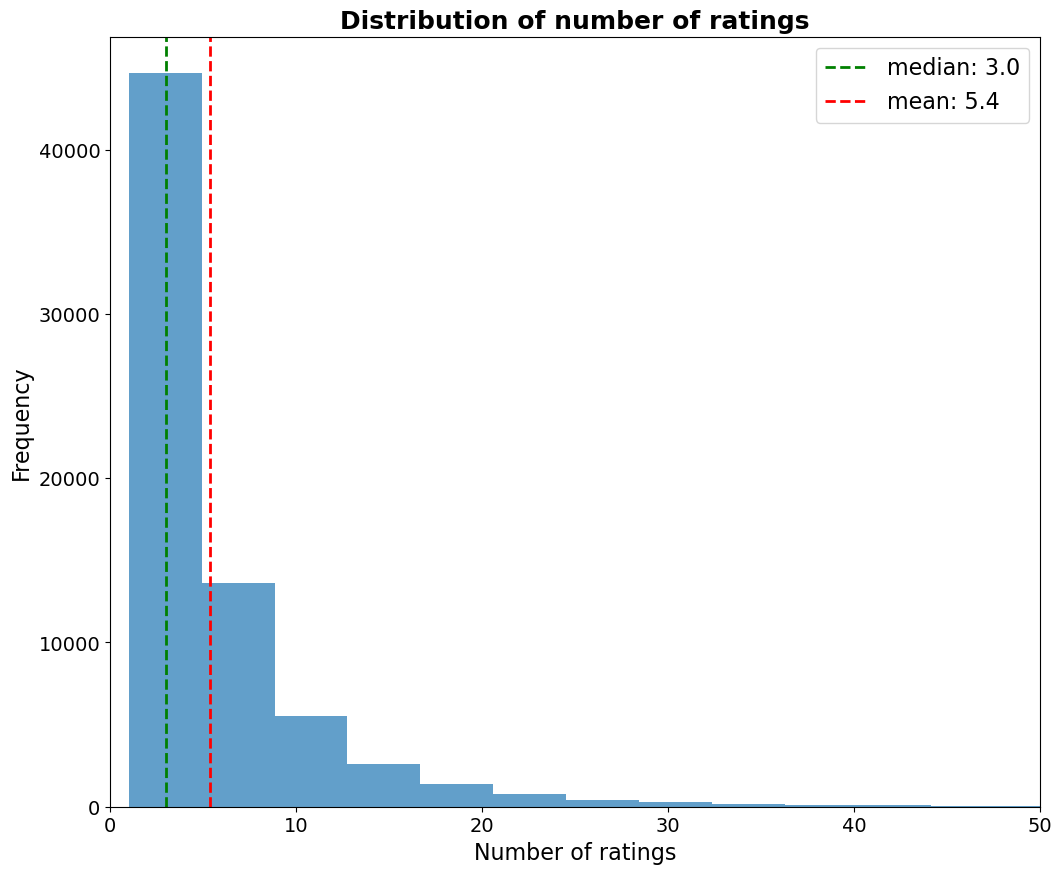

In [13]:
# plot for distribution of number of ratings 
plt.figure(figsize = (12, 10))

# histogram 
plt.hist(df["number_of_ratings"], 
         bins = 100, 
         alpha = 0.7)

# show median and mean value on the plot 
# median
plt.axvline(df["number_of_ratings"].median(), 
           color = "green", 
           linestyle = "dashed", 
           linewidth = 2, 
           label = f"median: {df['number_of_ratings'].median():.1f}")

# mean
plt.axvline(df["number_of_ratings"].mean(), 
           color = "red", 
           linestyle = "dashed", 
           linewidth = 2, 
           label= f"mean: {df['number_of_ratings'].mean():.1f}")

# aesthetics 
# title
plt.title("Distribution of number of ratings", 
          fontweight = "bold", 
          fontsize = 18)

# x axis 
plt.xlabel("Number of ratings", 
           fontsize = 16)
# limit
plt.xlim(0, 50)

# y axis
plt.ylabel("Frequency", 
           fontsize = 16)
# size for both x and y ticks 
plt.tick_params(axis = "both", 
                labelsize = 14)

# legend 
plt.legend(fontsize = 16)

# show the plot
plt.show()

In [14]:
# filter out the professors with less than 5 ratings (mean)
df_filtered = df[df["number_of_ratings"] >= 5].copy()

In [15]:
# check the distribution and information about the data after filter 
df_filtered["number_of_ratings"].describe()

count    25368.000000
mean        11.150662
std         11.327791
min          5.000000
25%          6.000000
50%          8.000000
75%         12.000000
max        393.000000
Name: number_of_ratings, dtype: float64

The distribution of the number of ratings is highly right skewed, with a median of 3 and a mean of 5.4. Most professors receive only a small number of ratings, which leads to unstable and potentially extreme average values. To address this, we set a minimum threshold of five ratings and excluded professors with fewer than five evaluations. This cutoff is close to the mean and removes cases where average ratings are driven by very sparse data, while preserving the majority of the sample and improving the reliability of comparisons across professors. After applying this filter, 25,368 professors remain in the analysis dataset.


In [16]:
# info about the dataset 
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25368 entries, 3 to 89891
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   average_rating                        25368 non-null  float64
 1   average_difficulty                    25368 non-null  float64
 2   number_of_ratings                     25368 non-null  float64
 3   received_a_pepper                     25368 non-null  float64
 4   would_take_again                      12160 non-null  float64
 5   number_of_ratings_online              25368 non-null  float64
 6   male_gender                           25368 non-null  int64  
 7   female_gender                         25368 non-null  int64  
 8   major                                 25368 non-null  object 
 9   university                            25368 non-null  object 
 10  state                                 25368 non-null  object 
 11  tough_grader        

### Categorical variables 
In this section, we address the handling of categorical variables. Teaching style tags were normalized by dividing each tag count by the total number of tags received by a professor, converting raw counts into proportions. This normalization controls for differences in the total number of ratings and ensures that tag values are comparable across professors. Cases with no assigned tags resulted in undefined values after normalization and were set to zero, reflecting the absence of tag information rather than meaningful signal.

In addition, we examine the gender indicators provided in the dataset. The male and female variables are treated as categorical indicators.

In [17]:
# distribution of all tags before normalization 
# starting from 11th variable 
# .describe 
df_filtered.iloc[:, 11:].describe()

,tough_grader,good_feedback,respected,lots_to_read,participation_matters,dont_skip_class_or_you_will_not_pass,lots_of_homework,inspirational,pop_quizzes,accessible,so_many_papers,clear_grading,hilarious,test_heavy,graded_by_few_things,amazing_lectures,caring,extra_credit,group_projects,lecture_heavy
count,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000
mean,2.036976,2.640374,1.920451,1.548841,1.778185,1.838261,1.600047,1.216809,0.393843,0.827854,0.286187,1.505401,1.420293,0.385722,0.336447,1.423329,2.358050,1.159256,0.533783,1.094056
std,3.279020,4.120596,3.634944,2.718146,2.903643,2.988417,3.058181,2.803210,1.420362,1.794848,0.943474,2.408472,3.664116,1.241309,0.854666,3.159003,3.540912,2.935454,1.661896,1.981580
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,3.000000,3.000000,3.000000,2.000000,2.000000,2.250000,2.000000,1.000000,0.000000,1.000000,0.000000,2.000000,2.000000,0.000000,0.000000,2.000000,3.000000,1.000000,0.000000,1.000000
max,112.000000,171.000000,186.000000,82.000000,82.000000,110.000000,141.000000,119.000000,97.000000,63.000000,64.000000,77.000000,224.000000,81.000000,39.000000,136.000000,127.000000,128.000000,92.000000,38.000000


In [18]:
# calculate total # of tags for each professor
total_tag_counts = df_filtered[df_tags_column_names].sum(axis = 1)

# normalize tag columns to be between 0 and 1 by dividing tag counts by total tag counts
for col in df_tags_column_names:
    df_filtered[col] = df_filtered[col] / total_tag_counts

# fill na values with 0 that resulted from divide by zero issues
df_filtered[df_tags_column_names] = df_filtered[df_tags_column_names].fillna(0)

In [19]:
# look at the distribution of tags after the normalization 
df_filtered.iloc[:, 11:].describe()

,tough_grader,good_feedback,respected,lots_to_read,participation_matters,dont_skip_class_or_you_will_not_pass,lots_of_homework,inspirational,pop_quizzes,accessible,so_many_papers,clear_grading,hilarious,test_heavy,graded_by_few_things,amazing_lectures,caring,extra_credit,group_projects,lecture_heavy
count,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000
mean,0.085069,0.100868,0.068629,0.062054,0.069651,0.069879,0.064489,0.041886,0.015234,0.028761,0.012109,0.058709,0.049038,0.013922,0.014433,0.047059,0.088719,0.041532,0.021918,0.045526
std,0.107520,0.091155,0.074261,0.084513,0.078161,0.078915,0.086387,0.061327,0.044127,0.045961,0.034345,0.067916,0.075274,0.035435,0.035939,0.064779,0.082976,0.068912,0.052664,0.071531
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.021277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.047619,0.083333,0.055556,0.025000,0.052632,0.052632,0.029168,0.000000,0.000000,0.000000,0.000000,0.044776,0.000000,0.000000,0.000000,0.000000,0.074074,0.000000,0.000000,0.000000
75%,0.136364,0.153846,0.111111,0.100000,0.111111,0.111111,0.100000,0.068966,0.000000,0.050000,0.000000,0.090909,0.076923,0.000000,0.000000,0.076923,0.142857,0.065217,0.000000,0.071429
max,1.000000,1.000000,0.600000,1.000000,1.000000,1.000000,1.000000,0.500000,0.500000,0.666667,0.500000,0.666667,0.625000,1.000000,0.500000,0.666667,1.000000,0.862069,0.545455,1.000000


Now, we are looking at gender variables. 

In [20]:
# check male and female gender error, where both are 1, or both 0
both_11 = df_filtered[(df_filtered["male_gender"] == 1) & (df_filtered["female_gender"] == 1)].shape[0]
both_00 = df_filtered[(df_filtered["male_gender"] == 0) & (df_filtered["female_gender"] == 0)].shape[0]

# print the results 
print(f"Number of professors with both male and female gender as 1: {both_11}")
print(f"Number of professors with both male and female gender as 0: {both_00}")

Number of professors with both male and female gender as 1: 776
Number of professors with both male and female gender as 0: 6170


This is a clear data error and should be removed. 

In [21]:
# drop rows where both male and female gender are 1 or 0
df_filtered_final = df_filtered[~((df_filtered["male_gender"] == 1) & (df_filtered["female_gender"] == 1)) & 
                          (~((df_filtered["male_gender"] == 0) & (df_filtered["female_gender"] == 0)))].copy()

# check the results
df_filtered_final.info()


<class 'pandas.core.frame.DataFrame'>
Index: 18422 entries, 5 to 89890
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   average_rating                        18422 non-null  float64
 1   average_difficulty                    18422 non-null  float64
 2   number_of_ratings                     18422 non-null  float64
 3   received_a_pepper                     18422 non-null  float64
 4   would_take_again                      8849 non-null   float64
 5   number_of_ratings_online              18422 non-null  float64
 6   male_gender                           18422 non-null  int64  
 7   female_gender                         18422 non-null  int64  
 8   major                                 18422 non-null  object 
 9   university                            18422 non-null  object 
 10  state                                 18422 non-null  object 
 11  tough_grader        

After data pre-processing, we are left with ~18k rows. Now we will proceed answering research questions. 

## Q1. Activists have asserted that there is a strong gender bias in student evaluations of professors, with male professors enjoying a boost in rating from this bias...We would like you to answer the question whether there is evidence of a pro-male gender bias in this dataset.


In [28]:
# separate the average ratings into two groups based on gender
# Male = 1, Male = 0
df1_male = df_filtered_final[df_filtered_final["male_gender"] == 1].copy()
df1_female = df_filtered_final[df_filtered_final["male_gender"] == 0].copy()

In [29]:
# count number of professors in each group
print(f"Number of male professors: {df1_male.shape[0]}")
print(f"Number of female professors: {df1_female.shape[0]}")

Number of male professors: 10015
Number of female professors: 8407


A difference is noticeable, but not very large. We can proceed with the analysis. 

C:\Users\nyuss\AppData\Local\Temp\ipykernel_28036\2381853625.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered_final,


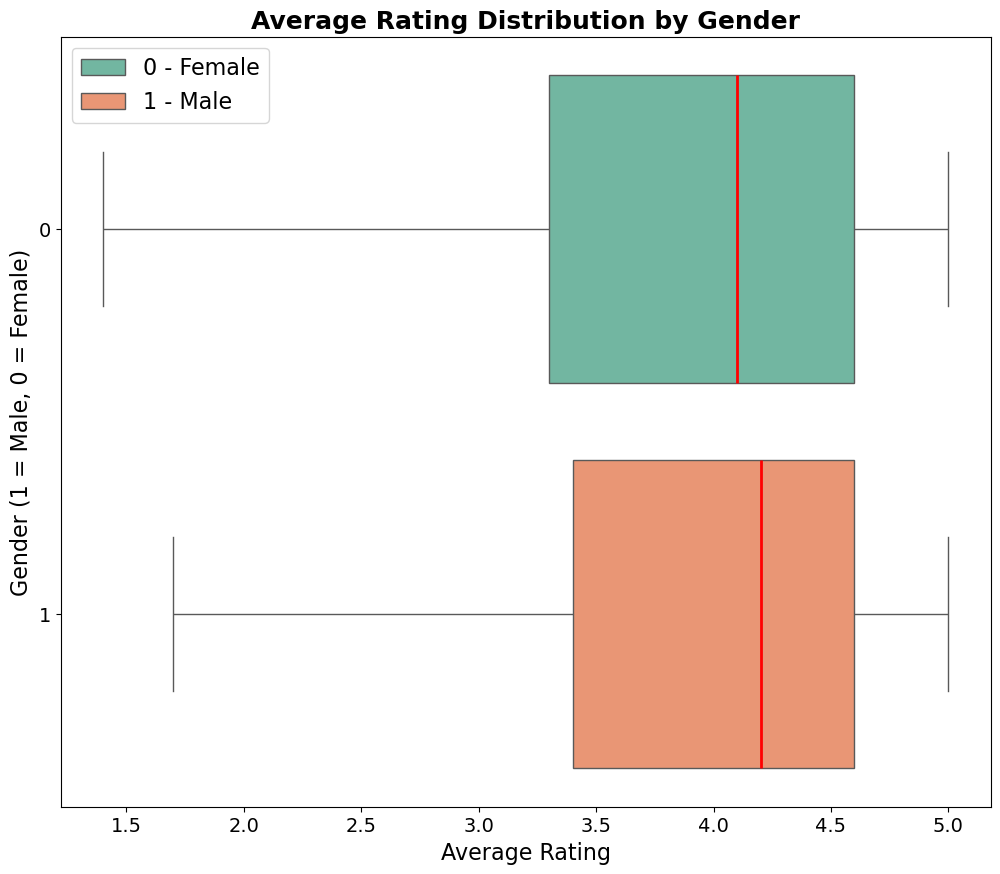

In [30]:
# compare distributions of average rating between male and female professors
plt.figure(figsize=(12, 10))

# box plot for male and female professors 
sns.boxplot(data=df_filtered_final, 
            x='average_rating', 
            y='male_gender', 
            palette = "Set2", 
            showfliers = False, 
            medianprops = {"color": "red", "linewidth": 2}, 
            orient= "horizontal")

# aesthetics 
plt.title('Average Rating Distribution by Gender', 
          fontweight = "bold",
          fontsize = 18)

# xlabel
plt.xlabel('Average Rating', 
           fontsize = 16)
# ylabel
plt.ylabel('Gender (1 = Male, 0 = Female)', 
           fontsize = 16)

# legend
plt.legend(['0 - Female', 
            '1 - Male'], 
            fontsize = 16,
           loc = "upper left")
# ticks 
plt.tick_params(axis = "both", 
                labelsize = 14)

plt.show()

The boxplot suggests a small difference in average ratings by gender. The distributions for male and female professors overlap substantially, but the male distribution appears slightly shifted to the right, with a higher median average rating. The spread of ratings is similar across genders, indicating comparable variability. To further test the difference, we have to apply a significance test. 

### Mann-Whitney U Test (one-tailed) 

`Rationale for the test:` For this question, we test whether male professors receive higher average ratings than female professors. Average ratings are bounded, derived from ordinal Likert-scale responses, and do not reliably satisfy normality assumptions at the individual professor level. Population parameters such as the true mean and variance are unknown.

We therefore use a one-sided Mann-Whitney U test, which is appropriate for comparing central tendency between two independent groups without assuming normality. This test evaluates whether ratings for one group tend to be systematically higher than those for the other, consistent with the directional hypothesis of pro-male bias.

`Null hypothesis (H0):` The median average rating for male professors is equal to the median average rating for female professors.

`Alternative hypothesis (Ha):` The median average rating for male professors is higher than the median average rating for female professors.

`Significance level:` 0.005

`Interpretation:` The p-value represents the probability of observing a difference in average ratings at least as extreme as the one observed, assuming the null hypothesis is true.
- If the p-value is smaller than 0.005, we reject H0 and conclude that there is statistically significant evidence of a pro-male bias in average ratings.
- If the p-value is larger than 0.005, we fail to reject H0 and conclude that the observed difference is consistent with random variation and does not provide sufficient evidence of gender bias.

In [31]:
# conduct mann-whitney u test for average rating using our function
u_stat, p_value = stats.mannwhitneyu(df1_male['average_rating'], 
                                     df1_female['average_rating'], 
                                     alternative='greater')
# interpretation 
significance(0.005, p_value)


p-value: 0.00024523
p = 0.00024523 < α = 0.005 = Reject H0 (statistically significant).


Our p-value (0.00024523) is smaller than the significance threshold of 0.005, so we reject the null hypothesis and conclude that the median average rating for male professors is higher than that for female professors.

This result does not establish causal evidence of pro-male rating bias, as the data are observational, not randomized, and we do not control for all potential confounders such as course type, institution, teaching experience, or selection effects in who chooses to rate professors.

However, we do find statistical evidence of a systematic difference in ratings by gender, with male professors receiving higher typical ratings in this dataset. This pattern is consistent with, but does not by itself prove, the presence of pro-male bias in average professor ratings.

## Q2. Is there a gender difference in the spread (variance/dispersion) of the ratings distribution? Again, it is advisable to consider the statistical significance of any observed gender differences in this spread. 

In [32]:
# again_separate the average ratings into two groups based on gender
# Male = 1, Male = 0
df2_male = df_filtered_final[df_filtered_final["male_gender"] == 1].copy()
df2_female = df_filtered_final[df_filtered_final["male_gender"] == 0].copy()

In [33]:
# count number of professors in each group
print(f"Number of male professors: {df2_male.shape[0]}")
print(f"Number of female professors: {df2_female.shape[0]}")


Number of male professors: 10015
Number of female professors: 8407


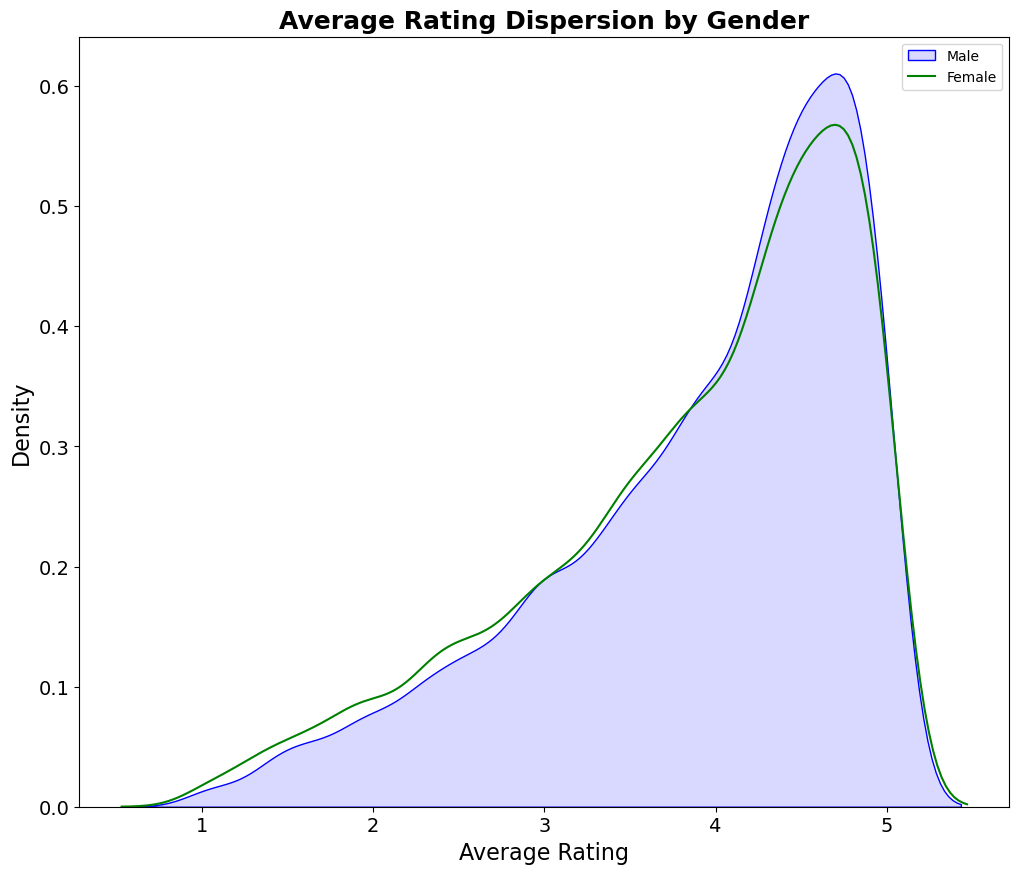

In [35]:
# plot the variance of average rating dipersion between male and female professors
# kernel density plot 
plt.figure(figsize=(12, 10))

# plot
sns.kdeplot(df2_male['average_rating'], 
           label='Male', 
           color='blue', 
           fill=True, 
           legend= True, 
           alpha=0.15
           )
sns.kdeplot(df2_female['average_rating'],
              label='Female', 
              color='green', 
              fill=False, 
              legend= True)

# aesthetics
plt.title('Average Rating Dispersion by Gender', 
          fontweight = "bold",
          fontsize = 18)
# xlabel
plt.xlabel('Average Rating',
              fontsize = 16)
# ylabel
plt.ylabel('Density',
                fontsize = 16)

# axis 
plt.tick_params(axis = "both", 
                labelsize = 14)
# legend 
plt.legend()
# ticks
plt.show()

The density curves for average ratings by gender are highly similar, indicating comparable dispersion for male and female professors. Both distributions cover a similar range of ratings and exhibit similar tail behavior, suggesting no substantial difference in variability. While the male distribution appears slightly shifted to the right, consistent with higher typical ratings observed in Q1, the overall spread and shape of the distributions closely align.

From a visual inspection, we do not observe meaningful differences in variance or dispersion between the two groups. Any differences in spread appear minor relative to the overall similarity of the distributions and are unlikely to reflect a practically important gender difference in rating variability.

This visual evidence suggests that gender differences in ratings are primarily related to central tendency rather than dispersion, motivating a formal statistical test of variance in the subsequent analysis.

### Levene's test 

`Rationale for the test:` This question asks whether male and female professors differ in the spread of their average rating distributions. We need a test of dispersion, not a test of location. Average ratings are bounded (1 to 5) and do not satisfy normality assumptions, so classical variance tests that rely on normality, such as an F-test, are not appropriate. We therefore use Levene's test because it tests equality of variance while remaining robust under non-normal data. We use the median-centered version to further reduce sensitivity to skewness and outliers. The test is two-tailed because the question asks whether dispersion differs in either direction, not whether one gender has higher variance.

`Null hypothesis (H0):` The dispersion (variance) of average ratings for male professors is equal to the dispersion of average ratings for female professors.

`Alternative hypothesis (Ha):` The dispersion of average ratings significantly differs between male and female professors.

`Significance level:` 0.005

If the p-value is smaller than 0.005, we reject H0 and conclude that the dispersion of average ratings differs significantly by gender.

If the p-value is larger than 0.005, we fail to reject H0, indicating that the observed difference in dispersion is consistent with random variation and that the data do not provide sufficient statistical evidence of a gender difference in rating variability.


In [36]:
# dispersion of average ratings 
# levene's test for equal variances
levene_stat, levene_p_value = stats.levene(df2_male['average_rating'], 
                                      df2_female['average_rating'], 
                                      center='median')

# check the result 
significance(0.005, levene_p_value)

p-value: 5.97717e-06
p = 5.97717e-06 < α = 0.005 = Reject H0 (statistically significant).


Since the p-value (0.00000598) is smaller than the significance level α = 0.005, we reject the null hypothesis. This provides statistically significant evidence that the dispersion of average ratings differs between male and female professors. The observed difference in spread is unlikely to be due to random variation alone.

## Q3. What is the likely size of both of these effects (gender bias in average rating, gender bias in spread of average rating), as estimated from this dataset? Please use 95% confidence and make sure to report each/both. 

### Effect size of gender bias in average rating

Because the ratings data are derived from ordinal Likert-scale responses and violate normality assumptions, we do not use parametric effect size measures such as Cohen's d or Hedges' g, which rely on normality and equal variances. Instead, we require a non-parametric effect size that is interpretable and appropriate for rank-based comparisons.

We therefore use Cliff's Delta (δ), a non-parametric measure of effect size suitable for ordinal and non-normal data. Cliff's delta quantifies the degree of distributional non-overlap between two groups by comparing all pairwise observations. It ranges from −1 to +1, where 0 indicates complete overlap and larger absolute values indicate stronger separation between groups.

Following the recommendations in [Meissel and Yao (2024)](https://github.com/NBeibarys/Project-Hypothesis-Testing-of-MovieRatings-Using-Python/blob/main/project_guidelines/Using%20Cliff%E2%80%99s%20Delta%20as%20a%20Non-Parametric%20Effect%20Size%20Measure.pdf), effect sizes are interpreted as:

|δ| < 0.15: negligible effect

0.15 ≤ |δ| < 0.33: small effect

0.33 ≤ |δ| < 0.47: medium effect

|δ| ≥ 0.47: large effect

The sign of δ indicates the direction of the effect relative to the reference group.



To estimate the uncertainty around the effect sizes, we compute 95% confidence intervals using bootstrapping. Bootstrapping is appropriate in this setting because it does not assume normality of the underlying data and is well suited for ordinal outcomes and non-parametric statistics.

For each effect, we repeatedly resample the observed data with replacement and recompute the corresponding effect size on each bootstrap sample. The empirical distribution of these bootstrap estimates is then used to construct percentile-based 95% confidence intervals.

This approach allows us to quantify the likely range of both:
- the location effect (gender difference in average ratings, measured via Cliff's delta), and
- the dispersion effect (gender difference in rating spread, measured via robust dispersion statistics), without relying on parametric assumptions. As a result, the reported confidence intervals reflect the variability inherent in the observed data rather than model-based assumptions.

In [37]:
 # divide average ratings by groups of gender and convert to arrays (bootstrap expects that)
df3_male = df_filtered_final[df_filtered_final["male_gender"] == 1].copy()
df3_female = df_filtered_final[df_filtered_final["male_gender"] == 0].copy()

# define function for effect size 
def cliffs_delta_trap(sample1, sample2, axis = 0):
    return cd(sample1, sample2)[0]

# Perform the bootstrap
result = stats.bootstrap(
    (df3_male['average_rating'].to_numpy(), 
    df3_female['average_rating'].to_numpy()), 
    statistic=cliffs_delta_trap,
    confidence_level=0.95, 
    random_state= n_number, 
    vectorized= False,
    method='BCa', 
    n_resamples=10000)

# compute the confidence interval
ci_lower, ci_upper = result.confidence_interval.low, result.confidence_interval.high

# print the results 
# point estimate
print(f"Effect size (Cliffs delta): {cd(df3_male['average_rating'], 
                                        df3_female['average_rating'])[0]:.4f}")

# confidence interval
print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")




Effect size (Cliffs delta): 0.0297
95% CI: [0.0127, 0.0466]


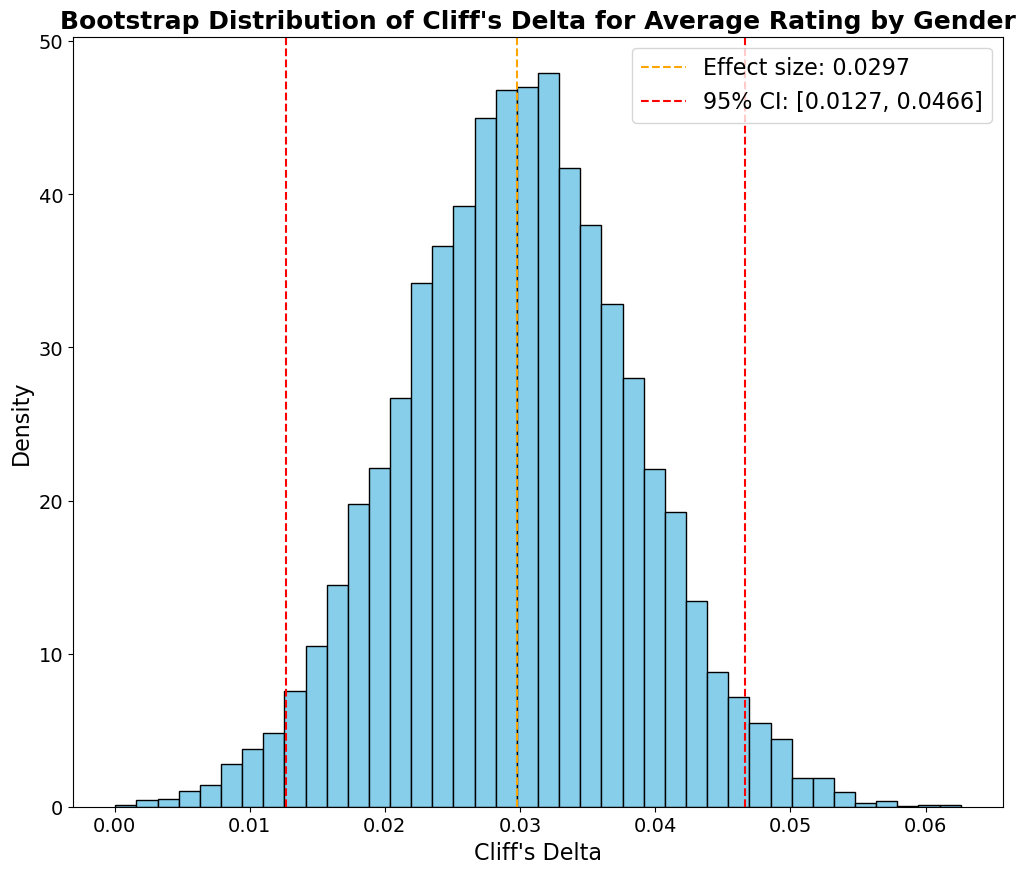

In [38]:
# plot boostrap distribution of cliffs delta
# figure size 
plt.figure(figsize=(12, 10))

# plot
plt.hist(result.bootstrap_distribution, 
         bins=40, 
         density=True, 
         color = "skyblue",
         edgecolor = "black",
         fill = True)

# point estimate line
plt.axvline(cd(df3_male['average_rating'].to_numpy(), 
                df3_female['average_rating'].to_numpy())[0], 
            color = "orange", 
            linestyle = "dashed", 
            label = f"Effect size: {cd(df3_male['average_rating'].to_numpy(), 
                                            df3_female['average_rating'].to_numpy())[0]:.4f}"
            )

# confidence interval lines
# lower
plt.axvline(ci_lower, 
            color = "red", 
            linestyle = "dashed", 
            label = f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]"
            )
# upper
plt.axvline(ci_upper, 
            color = "red", 
            linestyle = "dashed")

# aesthetics
# title 
plt.title("Bootstrap Distribution of Cliff's Delta for Average Rating by Gender", 
          fontweight = "bold",
          fontsize = 18)

# x and y axis labels
plt.xlabel("Cliff's Delta", 
           fontsize = 16)
plt.ylabel("Density", 
           fontsize = 16)

# ticks 
plt.tick_params(axis = "both", 
                labelsize = 14)

# legend 
plt.legend(fontsize = 16)

# show the plot 
plt.show()
         

A 95 percent confidence interval means that, over repeated samples, 95 percent of such intervals would contain the true Cliff’s delta. In this case, the estimated Cliff’s delta lies between 0.0127 and 0.0466, with a point estimate of 0.0297. This corresponds to a negligible effect size, meaning that the distributions of average ratings for male and female professors are almost entirely overlapping. Although this difference is statistically detectable given the large sample size, it does not represent a practically meaningful difference in central tendency and provides little evidence of substantive gender bias in average ratings.

Now we will compute a point estimate and 95% confidence interval for dispersion difference effect size. To measure the effect size of dispersion, we substract the female variance from male variance. 

### Effect size of gender bias in dispersion of average rating 

In [39]:
# variance difference in average rating for male and female professors
def variance_diff(sample1, sample2, axis = 0):
    # compute variance for each sample
    variance1 = np.var(sample1, ddof = 1)
    variance2 = np.var(sample2, ddof = 1)
    return variance1 - variance2   # male minus female

# compute the bootstrap
result_variance = stats.bootstrap(
    data=(df3_male['average_rating'].to_numpy(), 
    df3_female['average_rating'].to_numpy()),
    statistic=variance_diff,
    confidence_level=0.95,
    n_resamples=10000,
    method='BCa',
    random_state=n_number,
    vectorized=False
)

# compute the confidence interval
ci_lower_variance, ci_upper_variance = result_variance.confidence_interval.low, result_variance.confidence_interval.high

# print the results 
# point estimate
print(f"Effect size (variance difference): {variance_diff(df3_male['average_rating'], df3_female['average_rating'])}")
# confidence interval
print(f"95% CI: [{ci_lower_variance:.4f}, {ci_upper_variance:.4f}]")



Effect size (variance difference): -0.07755275266973649
95% CI: [-0.1128, -0.0411]


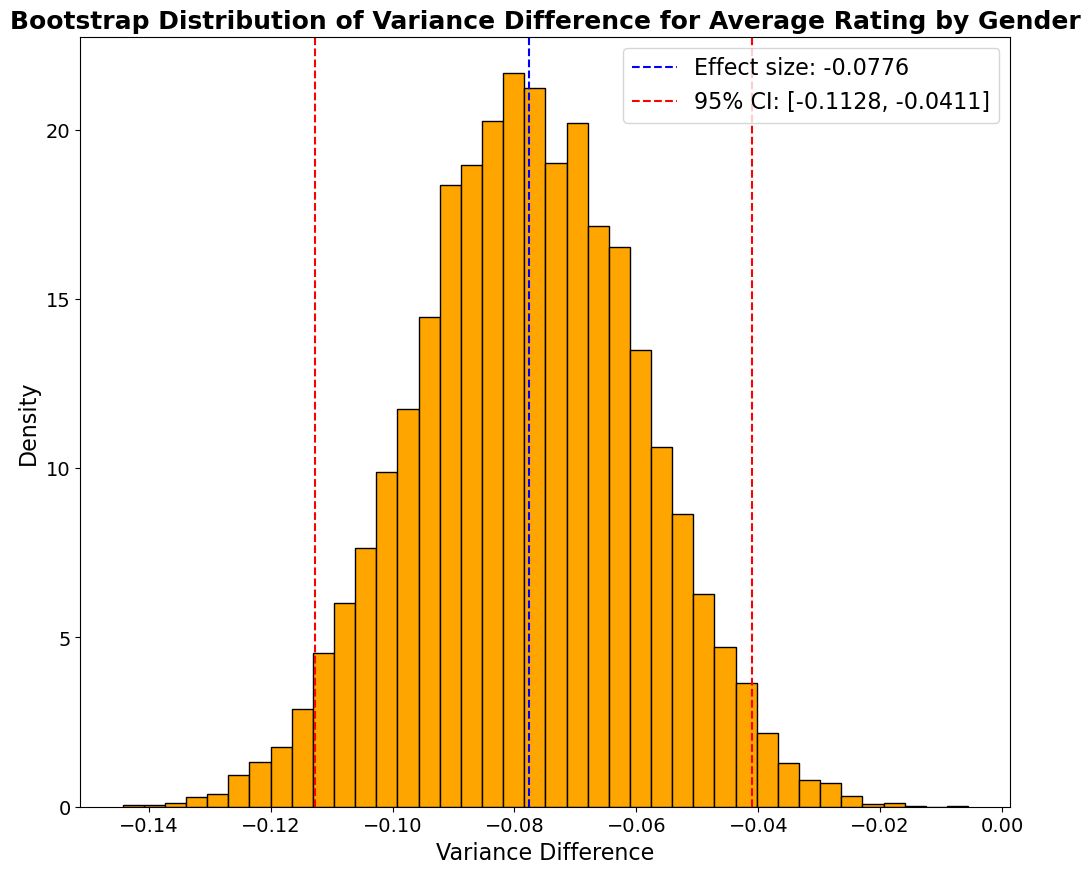

In [40]:
# plot boostrap distribution of variance difference
# figure size 
plt.figure(figsize=(12, 10))

# plot
plt.hist(result_variance.bootstrap_distribution, 
         bins=40, 
         density=True, 
         color = "orange",
         edgecolor = "black",
         fill = True)

# point estimate line
plt.axvline(variance_diff(df3_male['average_rating'], 
                df3_female['average_rating']), 
            color = "blue", 
            linestyle = "dashed", 
            label = f"Effect size: {variance_diff(df3_male['average_rating'], df3_female['average_rating']):.4f}"
            )

# confidence interval lines
# lower
plt.axvline(ci_lower_variance, 
            color = "red", 
            linestyle = "dashed", 
            label = f"95% CI: [{ci_lower_variance:.4f}, {ci_upper_variance:.4f}]"
            )
# upper
plt.axvline(ci_upper_variance, 
            color = "red", 
            linestyle = "dashed")

# aesthetics
# title 
plt.title("Bootstrap Distribution of Variance Difference for Average Rating by Gender", 
          fontweight = "bold",
          fontsize = 18)

# x and y axis labels
plt.xlabel("Variance Difference", 
           fontsize = 16)
plt.ylabel("Density", 
           fontsize = 16)

# ticks 
plt.tick_params(axis = "both", 
                labelsize = 14)

# legend 
plt.legend(fontsize = 16)

# show the plot 
plt.show()

# show the plot 
plt.show()
         


The estimated variance difference in average ratings between male and female professors is −0.0776, with a 95 percent CI from −0.1128 to −0.0411. The interval lies entirely below zero, indicating that average ratings for female professors exhibit slightly greater dispersion than those for male professors. However, the magnitude of this difference is very small in absolute terms. This suggests that, although the difference in spread is statistically detectable due to the large sample size, it is negligible in practice and provides little evidence of meaningful gender bias in rating variability.

## Q4.  Is there a gender difference in the tags awarded by students? Make sure to test each of the 20 tags for a potential gender difference and report which of them exhibit a statistically significant difference. Comment on the 3 most gendered (lowest p-value) and least gendered (highest p-value) tags for a potential gender difference and report which of them exhibit a statistically significant difference. Comment on the 3 most gendered (lowest p-value) and least gendered (highest p-value) tags.

`Rationale for the test:` Each teaching tag is converted into a proportion of all tags awarded to a professor in order to account for differences in the total number of ratings. These tag proportions are bounded between 0 and 1 and exhibit skewness, violating normality and equal variance assumptions. Parametric tests are therefore not appropriate.

To compare tag distributions between male and female professors, we use a two-tailed Mann-Whitney U test. This non-parametric test is suitable for comparing two independent groups on ordinal or non-normal data and evaluates whether one group tends to receive systematically higher or lower tag proportions than the other.

`Null hypothesis (H0):` The distribution of tag proportions is the same for male and female professors.

`Alternative hypothesis (Ha):` The distribution of tag proportions significantly differs between male and female professors.

`Significance level:` 0.005

The p-value represents the probability of observing a difference in tag proportions, or a more extreme one, assuming the null hypothesis is true.

If the p-value is smaller than 0.005, we reject H0 and conclude that the tag is awarded in significantly different proportions to male and female professors.
If the p-value is larger than 0.005, we fail to reject H0 and conclude that any observed difference is consistent with random variation.

This test is applied separately to each of the 20 teaching tags in the dataset in order to identify which tags exhibit statistically significant gender differences.

In [42]:
# filter our the data for this question 
df4_male = df_filtered_final[df_filtered_final["male_gender"] == 1].copy()
df4_female = df_filtered_final[df_filtered_final["male_gender"] == 0].copy()

# filter mask for all tags columns
tag_columns = df_tags_column_names
alpha = 0.005

# list for all tags 
results_q4 = []

# for loop for separating each movie subset into two groups and conducting the non-parametric test
for tag in tag_columns: 
    # separating into two groups
    males = df4_male[tag]
    females = df4_female[tag]

    # conducting the test 
    u_statistic, p_value = stats.mannwhitneyu(males, females, alternative= 'two-sided')
    
    # save data as well
    results_q4.append({
    "tag": tag,
    "n_female": len(females),
    "n_male": len(males),
    "U": u_statistic,
    "p_value": p_value,
    "significant": p_value < alpha
    })
        
    # # use the significance function created 
    # print(f"{tag} Result:")
    # print(f"{significance(0.005, p_value)}\n")

# check the results
results_q4_df = pd.DataFrame(results_q4).sort_values(by = 'p_value', ascending= False)
styled = results_q4_df.style.set_properties(**{
    "background-color": "white",
    "color": "black", 
     "border": "1px solid black"
}).format({"p_value": "{:.6e}"})

# sort by p-value
styled

,tag,n_female,n_male,U,p_value,significant
8,pop_quizzes,8407,10015,42356129.000000,2.698978e-01,False
9,accessible,8407,10015,42929904.500000,9.133809e-03,False
0,tough_grader,8407,10015,41056014.500000,2.637471e-03,True
11,clear_grading,8407,10015,40888751.000000,5.379880e-04,True
7,inspirational,8407,10015,43455897.500000,4.188542e-05,True
5,dont_skip_class_or_you_will_not_pass,8407,10015,40573252.500000,1.282860e-05,True
13,test_heavy,8407,10015,43444751.000000,8.194516e-08,True
3,lots_to_read,8407,10015,40243731.000000,5.192685e-08,True
6,lots_of_homework,8407,10015,40193393.000000,1.974495e-08,True
10,so_many_papers,8407,10015,40325013.000000,1.719188e-13,True


We tested all 20 tag proportions for gender differences using two tailed Mann-Whitney U tests at a significance level of 0.005. Most tags show statistically detectable gender differences, while a small number do not. The least gendered tags are pop_quizzes and accessible, which have the highest p values and show no evidence of a gender difference, and tough_grader, which shows only weak evidence. The most gendered tags are hilarious, amazing_lectures, and a participation_matters, which have the lowest p values and the strongest statistical evidence of a difference in tag proportions by gender. 

## Q5. Is there a gender difference in terms of average difficulty? Again, a significance test is indicated.

In [44]:
# separate into two groups based on gender
# Male = 1, Male = 0
df5_male = df_filtered_final[df_filtered_final["male_gender"] == 1].copy()
df5_female = df_filtered_final[df_filtered_final["male_gender"] == 0].copy()

In [45]:
# check quantity 
# it is the same number of rows, so this code is just in case
print(f"Number of male professors: {df5_male.shape[0]}")
print(f"Number of female professors: {df5_female.shape[0]}")

Number of male professors: 10015
Number of female professors: 8407


C:\Users\nyuss\AppData\Local\Temp\ipykernel_28036\2358968866.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered_final,


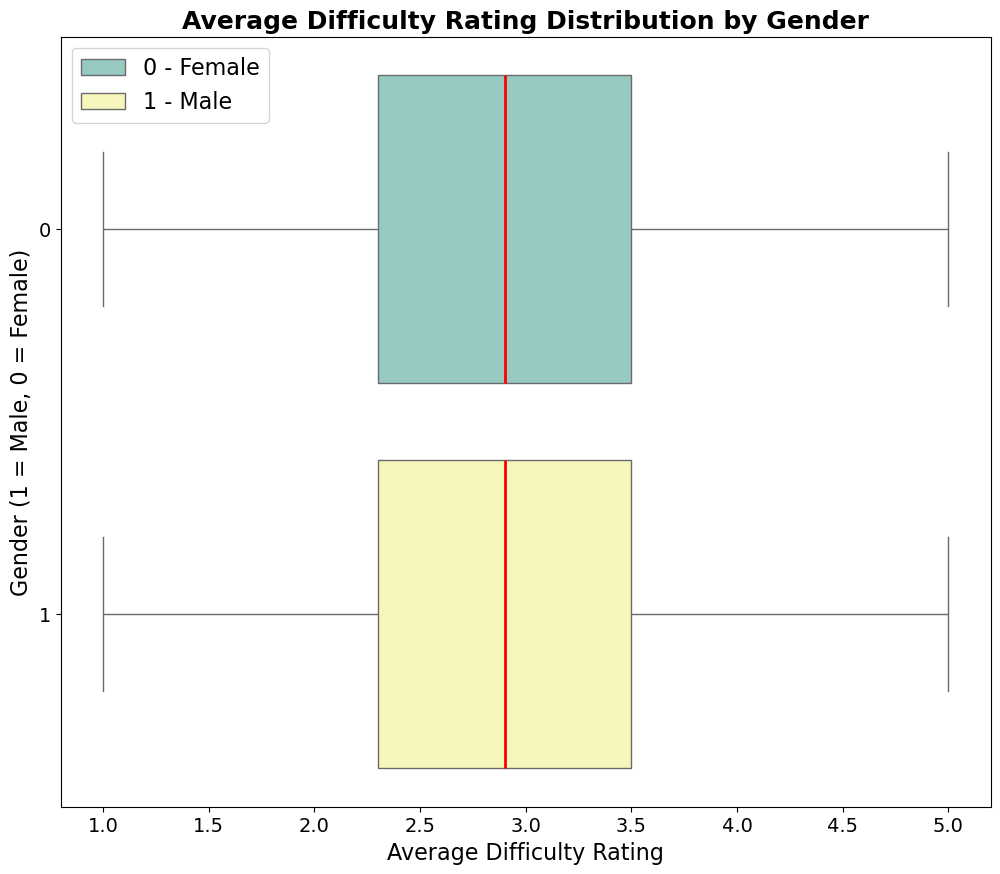

In [46]:
# compare distributions of average rating between male and female professors
plt.figure(figsize=(12, 10))

# box plot for male and female professors 
sns.boxplot(data=df_filtered_final, 
            x='average_difficulty', 
            y='male_gender', 
            palette = "Set3", 
            showfliers = False, 
            medianprops = {"color": "red", "linewidth": 2}, 
            orient= "horizontal")

# aesthetics 
plt.title('Average Difficulty Rating Distribution by Gender', 
          fontweight = "bold",
          fontsize = 18)

# xlabel
plt.xlabel('Average Difficulty Rating', 
           fontsize = 16)
# ylabel
plt.ylabel('Gender (1 = Male, 0 = Female)', 
           fontsize = 16)

# legend
plt.legend(['0 - Female', 
            '1 - Male'], 
            fontsize = 16,
           loc = "upper left")
# ticks 
plt.tick_params(axis = "both", 
                labelsize = 14)

plt.show()

The box plots of average difficulty ratings for male and female professors show substantial overlap and do not suggest a clear difference in typical difficulty. Visually, there is no strong evidence of a difference between the two groups. To formally assess whether any difference exists, we apply a two-tailed Mann-Whitney U test.

### Mann-Whitney U Test (two-tailed)

`Rationale for the test`: We use a two-tailed Mann-Whitney U test to compare average difficulty ratings by gender. This test is appropriate because average ratings are ordinal and non-normal.

`Null hypothesis (H0):` Average difficulty ratings for male professors are not different than average difficulty ratings of female professors.

`Alternative hypothesis (Ha):` Average difficulty ratings for male professors are significantly different from average difficulty ratings of female professors.

`Significance level:` 0.005

`Interpretation:` If the p-value is smaller than 0.005, it means such a result would be very unlikely by chance under the null hypothesis, so we reject the H0 and conclude that average difficulty ratings for male professors are significantly different from average difficulty ratings of female professors.

If the p-value is larger than 0.005, then the observed difference could easily occur by random variation, so we fail to reject the H0, meaning the data do not provide enough statistical evidence to conclude that there is a significant difference in average difficulty ratings by gender.

In [47]:
# conduct mann-whitney u test for average rating using our function
u_stat, p_value = stats.mannwhitneyu(df5_male['average_difficulty'], 
                                     df5_female['average_difficulty'], 
                                     alternative='two-sided')
# interpretation 
significance(0.005, p_value)

p-value: 0.828753
p = 0.828753 ≥ α = 0.005 = Fail to reject H0 (not statistically significant).


The Mann-Whitney U test yielded a p-value of 0.828753, which is substantially larger than the significance level of 0.005. Therefore, we fail to reject the null hypothesis.

This result indicates that the observed differences in average difficulty ratings between male and female professors are consistent with random variation. The data provide no statistical evidence of a gender difference in perceived course difficulty.

## Q6. Please quantify the likely size of this effect at 95% confidence

Because average difficulty ratings are ordinal and non-normal, parametric effect size measures such as Cohen's d and Hedges' g are not appropriate. As introduced earlier in this report, we therefore use Cliff's delta (δ) as a non-parametric measure of effect size suitable for ordinal data (Meissel & Yao, 2024).

Cliff's delta is interpreted using the same thresholds defined previously: negligible (|δ| < 0.15), small (0.15 ≤ |δ| < 0.33), medium (0.33 ≤ |δ| < 0.47), and large (|δ| ≥ 0.47).

We apply this measure here to quantify the magnitude of any gender difference in average difficulty ratings, complementing the hypothesis test results.

In [49]:
 # divide average difficulty ratings by groups of gender and convert to arrays (bootstrap expects that)
df6_male = df_filtered_final[df_filtered_final["male_gender"] == 1].copy()
df6_female = df_filtered_final[df_filtered_final["male_gender"] == 0].copy()

# define function for effect size 
def cliffs_delta_trap(sample1, sample2, axis = 0):
    return cd(sample1, sample2)[0]

# Perform the bootstrap
result_q6 = stats.bootstrap(
    (df6_male['average_difficulty'].to_numpy(), 
    df6_female['average_difficulty'].to_numpy()), 
    statistic=cliffs_delta_trap,
    confidence_level=0.95, 
    random_state= n_number, 
    vectorized= False,
    method='BCa', 
    n_resamples=10000)

# compute the confidence interval
ci_lower_q6, ci_upper_q6 = result_q6.confidence_interval.low, result_q6.confidence_interval.high

# print the results 
# point estimate
print(f"Effect size (Cliffs delta): {cd(df6_male['average_difficulty'], 
                                        df6_female['average_difficulty'])[0]:.4f}")

# confidence interval
print(f"95% CI: [{ci_lower_q6:.4f}, {ci_upper_q6:.4f}]")


Effect size (Cliffs delta): 0.0018
95% CI: [-0.0152, 0.0182]


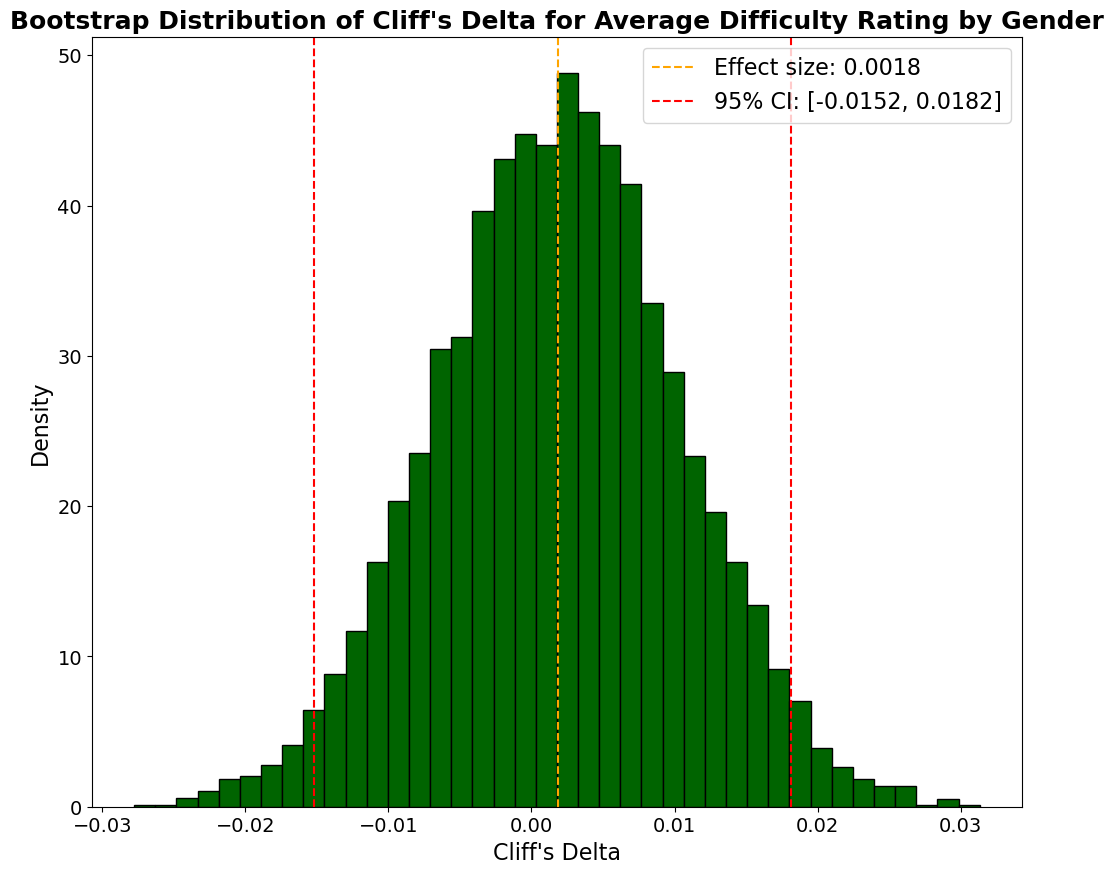

In [50]:
# plot boostrap distribution of cliffs delta
# figure size 
plt.figure(figsize=(12, 10))

# plot
plt.hist(result_q6.bootstrap_distribution, 
         bins=40, 
         density=True, 
         color = "darkgreen",
         edgecolor = "black",
         fill = True)

# point estimate line
plt.axvline(cd(df6_male['average_difficulty'].to_numpy(), 
                df6_female['average_difficulty'].to_numpy())[0], 
            color = "orange", 
            linestyle = "dashed", 
            label = f"Effect size: {cd(df6_male['average_difficulty'].to_numpy(), 
                                            df6_female['average_difficulty'].to_numpy())[0]:.4f}"
            )

# confidence interval lines
# lower
plt.axvline(ci_lower_q6, 
            color = "red", 
            linestyle = "dashed", 
            label = f"95% CI: [{ci_lower_q6:.4f}, {ci_upper_q6:.4f}]"
            )
# upper
plt.axvline(ci_upper_q6, 
            color = "red", 
            linestyle = "dashed")

# aesthetics
# title 
plt.title("Bootstrap Distribution of Cliff's Delta for Average Difficulty Rating by Gender", 
          fontweight = "bold",
          fontsize = 18)

# x and y axis labels
plt.xlabel("Cliff's Delta", 
           fontsize = 16)
plt.ylabel("Density", 
           fontsize = 16)

# ticks 
plt.tick_params(axis = "both", 
                labelsize = 14)

# legend 
plt.legend(fontsize = 16)

# show the plot 
plt.show()

After computing a 95% confidence interval using bootstrap resampling, the estimated Cliff's delta lies between -0.0152 and 0.0182, with a point estimate of 0.0018. This corresponds to a negligible effect size, indicating that the distributions of average difficulty ratings for male and female professors almost completely overlap.

Because the confidence interval includes zero and remains well within the negligible range, there is no practical evidence of a meaningful gender difference in perceived course difficulty. This result reinforces the hypothesis test findings and suggests that any statistically detectable differences are not substantively important at the user-experience level.

## Q7 - Build a regression model predicting average rating from all numerical predictors (the ones in the rmpCapstoneNum.csv) file. Make sure to include the R2 and RMSE of this model. Which of these factors is most strongly predictive of average rating? 

### Linear Regression

In [22]:
# copy the data for the question 
df_7 = df_filtered_final[df_num_column_names].copy()

# drop female_gender as it is redundant (we have male_gender binary variable already)
df_7 = df_7.drop(columns = ['female_gender'])
# check 
df_7.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18422 entries, 5 to 89890
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   average_rating            18422 non-null  float64
 1   average_difficulty        18422 non-null  float64
 2   number_of_ratings         18422 non-null  float64
 3   received_a_pepper         18422 non-null  float64
 4   would_take_again          8849 non-null   float64
 5   number_of_ratings_online  18422 non-null  float64
 6   male_gender               18422 non-null  int64  
dtypes: float64(6), int64(1)
memory usage: 1.1 MB


In [23]:
# split the data into x and y 
# x 
x_7 = df_7.drop(columns = "average_rating")

# y 
y_7 = df_7["average_rating"]

# split the data into train and test data 
x_train_7, x_test_7, y_train_7, y_test_7 = train_test_split(x_7, y_7, test_size=0.2, random_state=n_number)

# check distributions of the data 
print(f'Number of rows for train data:{y_train_7.shape[0]}\n')
print(f'Number of rows for test data:{y_test_7.shape[0]}\n')

Number of rows for train data:14737

Number of rows for test data:3685



In [24]:
# correlation matrix for x and y 
corr7_yx = x_train_7.corrwith(y_train_7, 
                              method = 'pearson').sort_values(ascending= False)
# check 
corr7_yx

would_take_again            0.878465
received_a_pepper           0.454502
number_of_ratings           0.046599
male_gender                 0.034578
number_of_ratings_online   -0.019484
average_difficulty         -0.612096
dtype: float64

The correlations indicate that average ratings are driven primarily by student satisfaction and course rigor rather than demographics. Would take again shows an extremely strong positive association with ratings, while average difficulty exhibits a strong negative relationship, suggesting that harder courses tend to receive lower evaluations. Received a pepper has a moderate positive association, whereas gender, number of ratings, and online share show near-zero correlations, indicating minimal influence. These results suggest that instructional experience and perceived difficulty dominate rating outcomes, while demographic and exposure-related variables contribute little explanatory value.

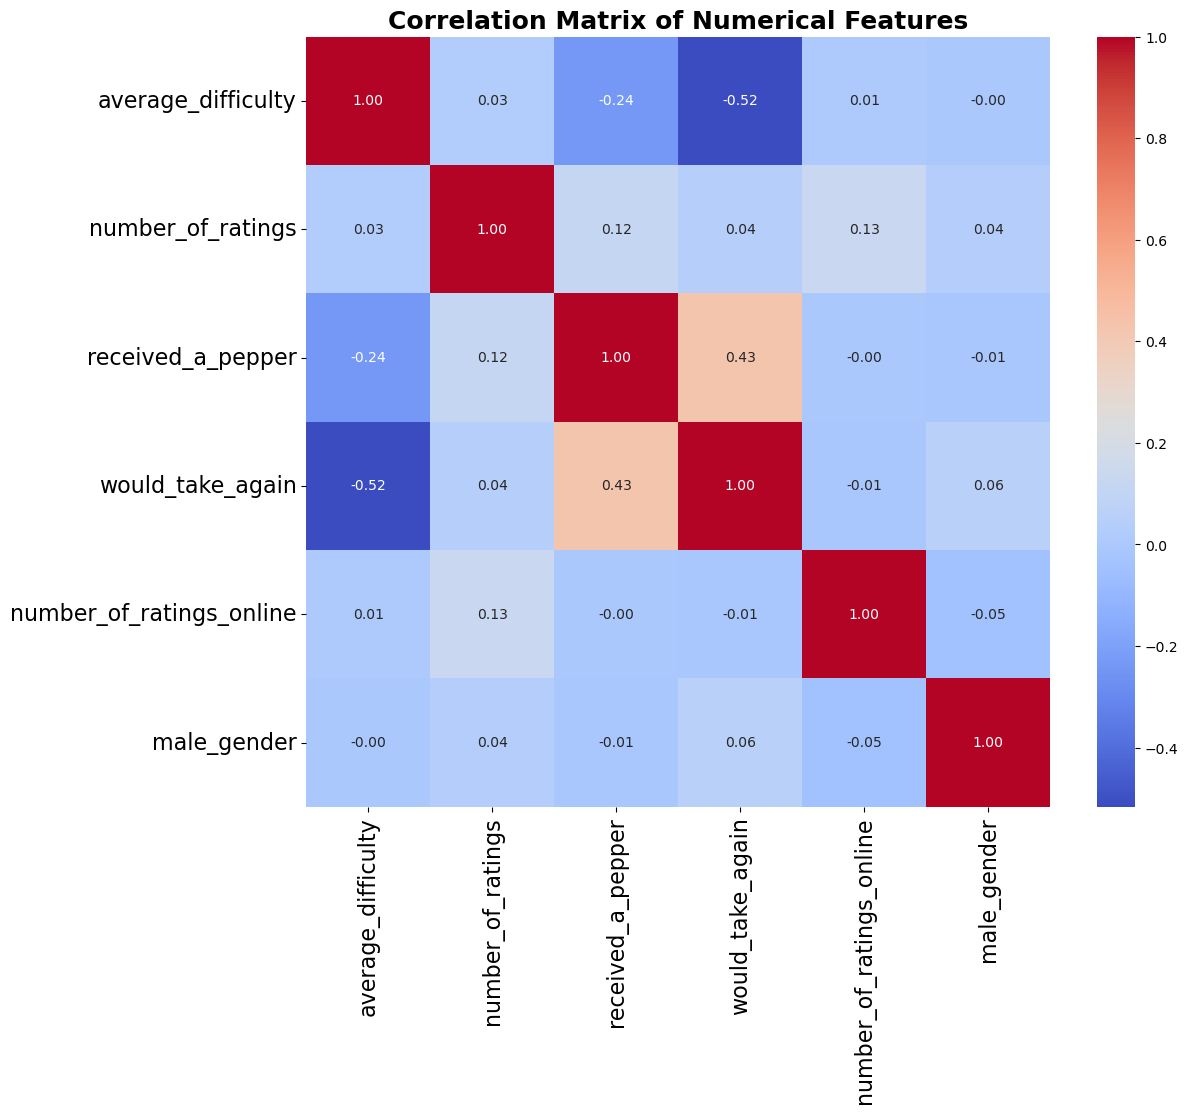

In [ ]:
# correlation of features with each other 
corr7_x = x_train_7.corr()

# Plot the heatmap using Seaborn
plt.figure(figsize=(12, 10)) # Adjust the figure size as needed

# plot itself
sns.heatmap(corr7_x, annot=True, cmap='coolwarm', fmt=".2f")

# aesthetics 
# title 
plt.title('Correlation Matrix of Numerical Features', fontweight = "bold", fontsize = 18)

# ticks
plt.tick_params(labelsize = 16)

# show the plot
plt.show()

The correlation matrix shows no strong pairwise correlations among the numerical predictors, indicating no evidence of multicollinearity. Most correlations are close to zero, including those involving gender, number of ratings, and online ratings. The largest association appears between average difficulty and “would take again” (≈ ~0.52), which reflects a meaningful but expected relationship rather than redundancy. Overall, the predictors capture distinct aspects of professor evaluation and can be included jointly in downstream models without collinearity concerns.

#### KNN Imputation 

Only the variable would_take_again contains missing values. Dropping these observations would remove a substantial amount of information, especially because this variable shows a strong association with average rating.

We therefore apply KNN imputation to recover missing values in would_take_again by leveraging similarity across the remaining numerical predictors. This method preserves local structure in the data and avoids the strong distributional assumptions imposed by mean or regression based imputation, which is appropriate given the bounded and ordinal nature of the ratings.

The number of neighbors governs the bias variance tradeoff of the imputation. To avoid introducing noise, we tune this parameter within a cross validated pipeline, ensuring that the imputed values improve out of sample performance.

We deliberately do not include a missing indicator for would_take_again. Although missingness exhibits statistical correlation with ratings, it reflects survey response behavior rather than any interpretable course characteristic. Including such indicators risks capturing artifacts of the data collection process rather than substantive effects and reduces the interpretability and external validity of the model. For this reason, missingness is handled solely through imputation.

In [28]:
# fixed cross-validation
cv = KFold(n_splits=5, 
           shuffle=True, 
           random_state=n_number
           )

# pipeline for tuning 
knn_pipe = Pipeline([
    ("imputer", KNNImputer()),
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

# define objective function for optuna 
def objective(trial):
    # parameters to tune
    params = {
        "imputer__n_neighbors": trial.suggest_int("imputer__n_neighbors", 2, 25),
        "imputer__weights": trial.suggest_categorical("imputer__weights", ["uniform", "distance"]),
        "imputer__add_indicator": trial.suggest_categorical("imputer__add_indicator", [False])
    }

    # clone our model and set parameters 
    pipe = clone(knn_pipe)
    pipe.set_params(**params)

    # cross-validation score with tuned parameters 
    scores = cross_val_score(
        pipe,
        x_train_7,
        y_train_7,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1
    )

    # return average RMSE 
    return -scores.mean()

# start the study for knn imputer tuning
study_knn = start_study_optuna(
    objective=objective,
    n_trials=25,
    sampler_seed=n_number,
    direction="minimize"
)

# set the best parameters to the pipeline
knn_pipe.set_params(**study_knn.best_params)

# check the model performance with the best parameters 
score_model(
    knn_pipe,
    x_train_7,
    x_test_7,
    y_train_7,
    y_test_7
)


[I 2026-01-23 18:37:40,666] A new study created in memory with name: no-name-3b7d8f38-41c0-4597-8444-4d922a1ecab1
[I 2026-01-23 18:37:46,491] Trial 0 finished with value: 0.599873317405424 and parameters: {'imputer__n_neighbors': 8, 'imputer__weights': 'distance', 'imputer__add_indicator': False}. Best is trial 0 with value: 0.599873317405424.
[I 2026-01-23 18:37:51,958] Trial 1 finished with value: 0.6003506906570315 and parameters: {'imputer__n_neighbors': 6, 'imputer__weights': 'distance', 'imputer__add_indicator': False}. Best is trial 0 with value: 0.599873317405424.
[I 2026-01-23 18:37:57,676] Trial 2 finished with value: 0.6030686268405857 and parameters: {'imputer__n_neighbors': 4, 'imputer__weights': 'distance', 'imputer__add_indicator': False}. Best is trial 0 with value: 0.599873317405424.
[I 2026-01-23 18:38:03,469] Trial 3 finished with value: 0.5988070198572264 and parameters: {'imputer__n_neighbors': 17, 'imputer__weights': 'distance', 'imputer__add_indicator': False}. B

Best Params: {'imputer__n_neighbors': 20, 'imputer__weights': 'uniform', 'imputer__add_indicator': False}


{'Training RMSE': 0.5832186729906556,
 'Training R2': 0.6018345961910545,
 'Testing RMSE': 0.5826782249696487,
 'Testing R2': 0.6168627535619247}

The tuned preprocessing pipeline shows stable cross-validation performance. The best Optuna trial (trial 15) achieves a mean CV RMSE of 0.5832. The train and test results are also consistent, RMSE is 0.5832 on training and 0.5827 on testing, R² is 0.6018 on training and 0.6169 on testing. This alignment suggests good generalization and no clear overfitting.

We use this tuned preprocessing plus linear regression setup as our baseline. It gives a fair reference point because the preprocessing is selected using cross-validation, so the baseline reflects expected out-of-sample behavior.

Next, we compare the tuned KNN-based imputation strategy against simpler imputation methods. In particular, we evaluate whether replacing KNN imputation with less complex approaches, such as mean or median imputation, leads to comparable out-of-sample performance. This comparison allows us to assess whether the additional complexity of KNN imputation is justified, or whether simpler imputers are sufficient for this problem.

In [29]:
# fixed CV
cv = KFold(n_splits=5, shuffle=True, random_state=n_number)

# pipelines for comparison
pipelines = {
    "KNNImputer (tuned)": Pipeline([
        # imputer 
        ("imputer", KNNImputer(n_neighbors=20, 
                               weights="uniform", 
                               add_indicator=False)),

        # scaler 
        ("scaler", StandardScaler()),

        # model 
        ("model", LinearRegression())
    ]),

    "SimpleImputer (mean)": Pipeline([
        ("imputer", SimpleImputer(strategy="mean", 
                                  add_indicator=False)),
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),
    "SimpleImputer (median)": Pipeline([
        ("imputer", SimpleImputer(strategy="median", 
                                  add_indicator=False)),
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),
}

# compare the pipelines
rows = []
for name, pipe in pipelines.items():
    results = cross_validate(
        pipe,
        x_train_7,
        y_train_7,
        cv=cv,
        scoring=("r2", "neg_root_mean_squared_error"),
        return_train_score=False,
        n_jobs=-1
    )
    rows.append({
        "model": name,
        "R2_mean": results["test_r2"].mean(),
        "RMSE_mean": (-results["test_neg_root_mean_squared_error"]).mean()
    })

# create a dataframe for comparison
compare_imputers_df = (
    pd.DataFrame(rows)
      .sort_values("RMSE_mean", 
                   ascending= True)
      .reset_index(drop=True)
)

# check the results
compare_imputers_df

,model,R2_mean,RMSE_mean
0,KNNImputer (tuned),0.601389,0.583237
1,SimpleImputer (mean),0.561377,0.611883
2,SimpleImputer (median),0.551823,0.618515


The comparison confirms that KNN imputation provides a clear advantage over simpler imputation strategies. The tuned KNN imputer achieves the best cross-validation performance, with an RMSE of 0.583 and an R² of 0.601. In contrast, both mean and median imputation lead to noticeably worse results, with higher RMSE and lower R².

This gap indicates that missing values in would_take_again are not random and that borrowing information from similar observations improves predictive accuracy. Simpler imputers fail to capture this structure and introduce additional noise, resulting in inferior out-of-sample performance.

Given these results, we retain the tuned KNN imputation strategy as part of the preprocessing pipeline.

Next, we move to regularized modeling by fitting a Lasso regression on top of this optimized preprocessing setup. The goal is to assess whether introducing sparsity can simplify the model and improve interpretability without sacrificing out-of-sample performance.

#### Lasso Regression

In [26]:
# model with all variables 
# pipeline for Lasso model
pipeline_q7 = Pipeline([
    ("imputer", KNNImputer(n_neighbors=20, 
                           weights= 'uniform', 
                           add_indicator= False
                           )),
    ("scaler", StandardScaler()),
    ("model", LassoCV(
        cv = 5, 
        random_state = n_number,
        alphas= 100, 
        max_iter= 10000
    ))
])

# cross-validation 
cv = KFold(n_splits=5, 
           shuffle=True, 
           random_state=n_number)

# run cross-validation
cv_results_raw_7 = cross_validate(
    pipeline_q7,
    x_train_7,
    y_train_7,
    cv=cv,
    scoring=("r2", "neg_root_mean_squared_error"),
    return_train_score=False, 
    return_estimator = True
)

# results 
cv_results_7 = [{
    "model": "LassoCV (all features)", 
    "R2_mean": cv_results_raw_7["test_r2"].mean(),
    "RMSE_mean": (-cv_results_raw_7["test_neg_root_mean_squared_error"]).mean()
}]

# save to dataframe for comparison later 
compare_models_q7_df = pd.DataFrame(cv_results_7).sort_values("RMSE_mean").reset_index(drop = True)

# check 
compare_models_q7_df

,model,R2_mean,RMSE_mean
0,LassoCV (all features),0.601358,0.58326


In [27]:
# check the model on test data 
score_model(pipeline_q7, 
            x_train_7, 
            x_test_7, 
            y_train_7, 
            y_test_7)

{'Training RMSE': 0.5832380316346232,
 'Training R2': 0.6018081633260812,
 'Testing RMSE': 0.5827759594486576,
 'Testing R2': 0.6167342131153808}

The Lasso model achieves nearly identical cross-validated performance compared to the baseline. The change in RMSE is negligible and within expected sampling variability. This suggests that the baseline model already captures the dominant linear relationships in the data, and additional regularization does not provide a meaningful predictive advantage.

The value of Lasso in this setting is therefore interpretability rather than accuracy. By shrinking weaker coefficients toward zero, it confirms that only a small subset of predictors contributes materially to the model, while maintaining essentially the same out-of-sample performance.

In [28]:
# extract feature weights from the model
model = pipeline_q7.named_steps["model"]

# feature names
feature_names = x_train_7.columns.to_list()
# coefficients
coef = model.coef_

# build dataframe
weights_df_7 = pd.DataFrame({
    "tag": feature_names,
    "weight": coef
})

# sort by absolute weight
weights_df_7["abs_weight"] = weights_df_7["weight"].abs()
weights_df_7 = weights_df_7.sort_values("abs_weight", ascending=False)

# cleanup
weights_df_7 = weights_df_7.drop(columns="abs_weight").reset_index(drop=True)

# check 
weights_df_7

,tag,weight
0,would_take_again,0.456416
1,average_difficulty,-0.270995
2,received_a_pepper,0.118806
3,number_of_ratings,0.016933
4,male_gender,-0.007128
5,number_of_ratings_online,-0.000000


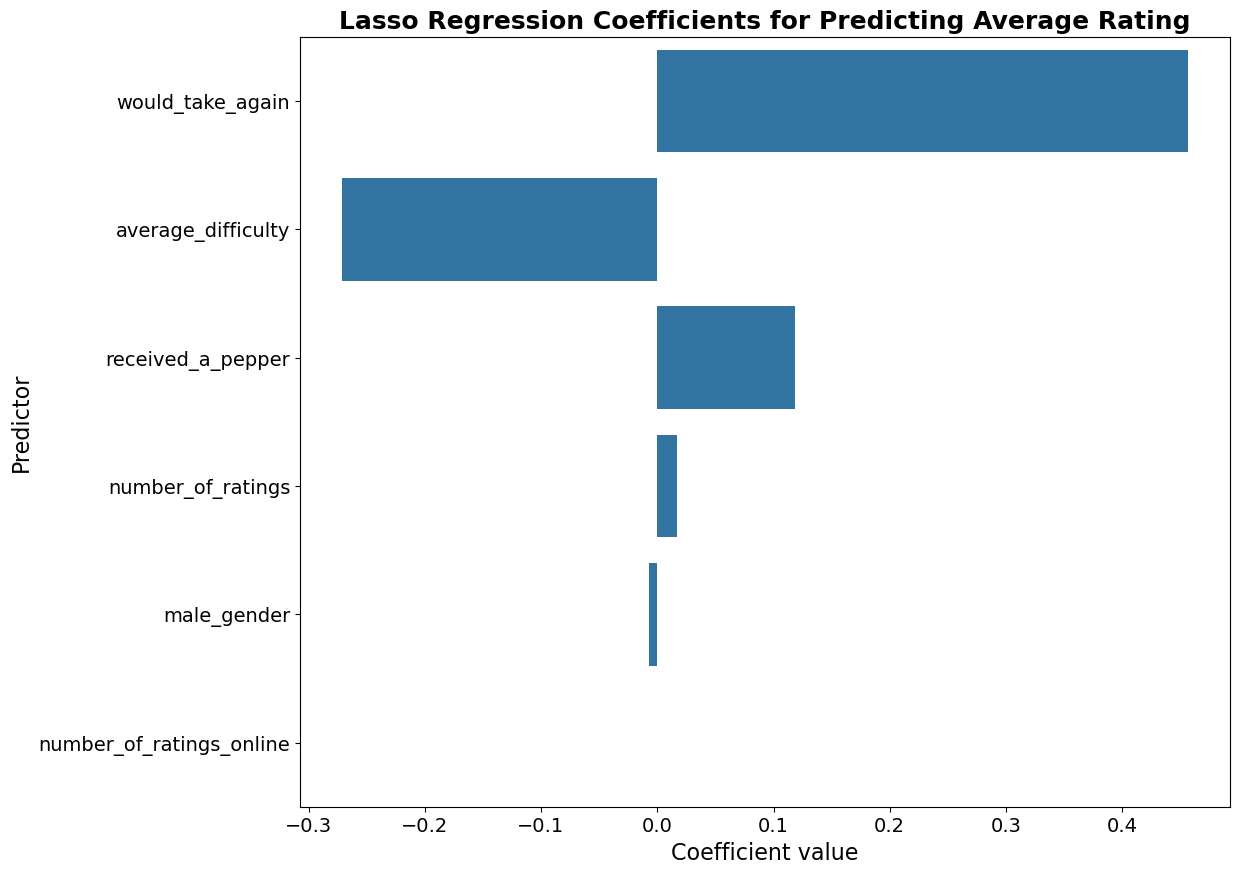

In [30]:
# plot weights of the multiple linear regression model 
# figure size 
plt.figure(figsize = (12, 10))

# bar plot 
sns.barplot(y = weights_df_7["tag"], 
        x = weights_df_7["weight"])

# aesthetics
# title 
plt.title("Lasso Regression Coefficients for Predicting Average Rating", 
          fontweight="bold", 
          fontsize=18)

# axis labels
plt.xlabel("Coefficient value", fontsize=16)
plt.ylabel("Predictor", fontsize=16)

# ticks
plt.tick_params(axis="both", labelsize=14)

# show plot
plt.show()

To focus the model on meaningful predictors, we retain variables whose absolute standardized coefficients exceed 5 percent. This cutoff removes predictors with negligible contribution while keeping variables that materially affect predicted ratings.

Based on the Lasso results, three variables meet this criterion.

`would_take_again (0.456)`
- This is the strongest positive predictor. Professors whom students are willing to take again receive substantially higher ratings. This variable captures core teaching quality and overall student satisfaction.

`average_difficulty (-0.271)`
- This shows a strong negative relationship. Higher perceived difficulty is associated with lower ratings, even after controlling for other factors. This suggests that difficulty directly shapes student evaluations.

`received_a_pepper (0.119)`
- This has a moderate positive effect. Perceived attractiveness correlates with higher ratings, but the magnitude is much smaller than the effect of teaching related variables.

All remaining variables, including gender, number of ratings, and online rating volume, have coefficients close to zero and are excluded. Their limited weights indicate minimal incremental predictive value once the main drivers are accounted for.

This selection step yields a simpler and more interpretable model driven primarily by student experience and course perception rather than demographic or exposure related noise. We now evaluate the performance of this reduced model.

In [31]:
# select features with |weight| >= 0.05
selected_features = (
weights_df_7
.loc[weights_df_7["weight"].abs() >= 0.05, "tag"]
.tolist()
)

# reduce training data 
x_train_reduced_7 = x_train_7[selected_features]
x_test_reduced_7 = x_test_7[selected_features]

# cross-validation 
cv = KFold(n_splits=5, 
           shuffle=True, 
           random_state=n_number)

# pipeline for model 
pipeline_q7_reduced = Pipeline([
    ("imputer", KNNImputer(n_neighbors=20, 
                           weights= 'uniform', 
                           add_indicator= False)),
    ("scaler", StandardScaler()),
    ("model", LassoCV(
        cv = cv, 
        random_state = n_number,
        alphas = 100, 
        max_iter= 10000
    ))
])

# run cross-validation
cv_results_raw_7_reduced = cross_validate(
    pipeline_q7_reduced,
    x_train_reduced_7,
    y_train_7,
    cv=cv,
    scoring=("r2", "neg_root_mean_squared_error"),
    return_train_score=False, 
    return_estimator = True
)

# save results 
cv_results_7.append({
    "model": "LassoCV (reduced features)",
    "R2_mean": cv_results_raw_7_reduced["test_r2"].mean(),
    "RMSE_mean": (-cv_results_raw_7_reduced["test_neg_root_mean_squared_error"]).mean()}
)

# create dataframe 
compare_models_q7_df = pd.DataFrame(cv_results_7).sort_values(by = "RMSE_mean").reset_index(drop = True)

# check results 
compare_models_q7_df

,model,R2_mean,RMSE_mean
0,LassoCV (reduced features),0.616401,0.572178
1,LassoCV (all features),0.601358,0.583260


In [32]:
print("Model performance with all features:\n")
# check the model on test data 
score_model(pipeline_q7, 
            x_train_7, 
            x_test_7, 
            y_train_7, 
            y_test_7)

Model performance with all features:



{'Training RMSE': 0.5832380316346232,
 'Training R2': 0.6018081633260812,
 'Testing RMSE': 0.5827759594486576,
 'Testing R2': 0.6167342131153808}

In [33]:
print("Model performance with the most important features:\n")
# check on test data again 
score_model(pipeline_q7_reduced, 
            x_train_reduced_7, 
            x_test_reduced_7, 
            y_train_7, 
            y_test_7)

Model performance with the most important features:



{'Training RMSE': 0.5698553493853484,
 'Training R2': 0.6198719304932935,
 'Testing RMSE': 0.5656309773299064,
 'Testing R2': 0.638953475637948}

The reduced Lasso model consistently outperforms the full-feature baseline across all evaluation settings. In cross-validation, RMSE decreases from 0.583 to 0.572 and R² increases from 0.601 to 0.616, indicating a meaningful improvement in out-of-sample performance.

The same pattern holds on the hold-out set. Test RMSE drops from 0.583 to 0.566, while test R² increases from 0.617 to 0.639. Training and testing metrics remain closely aligned, suggesting that the performance gain is not driven by overfitting.

These results indicate that several predictors in the full model contribute noise rather than signal. Removing them improves generalization and yields a simpler model with better predictive accuracy.

Overall, the reduced model achieves a better tradeoff between performance and complexity. It shows that ratings are primarily driven by teaching experience and course perception, while demographic and exposure-related variables add little once the core predictors are included.

### Extra: Feature Engineering
#### Do ratings change linearly with difficulty and volume?

To test for nonlinear relationships, we introduced polynomial and logarithmic transformations of selected predictors. Because these transformations induce multicollinearity, we employed ElasticNetCV, which combines L1 and L2 regularization to stabilize coefficient estimates while controlling overfitting.

In [34]:
# transform average difficulty and number of ratings 
# average difficulty in a square 
x_train_7["average_difficulty^2"] = np.square(x_train_7["average_difficulty"])
x_test_7["average_difficulty^2"] = np.square(x_test_7["average_difficulty"])

# log number of ratings 
x_train_7["number_of_ratings_log"] = np.log(1 + x_train_7["number_of_ratings"])
x_test_7["number_of_ratings_log"] = np.log(1 + x_test_7["number_of_ratings"])
    
x_train_7["number_of_ratings_online_log"] = np.log(1 + x_train_7["number_of_ratings_online"])

x_test_7["number_of_ratings_online_log"] = np.log(1 + x_test_7["number_of_ratings_online"])

In [36]:
# fixed cv
cv = KFold(n_splits = 5, 
           shuffle = True, 
           random_state = n_number)

# pipeline to test transformations
pipeline_q7_transform = Pipeline([
    # null values imputer 
    ("imputer", KNNImputer(n_neighbors= 20, 
                           weights = "uniform", 
                           add_indicator= False)),
    
    # data standardization (scaler)
    ("scaler", StandardScaler()), 

    # model 
    ("model", ElasticNetCV(
        cv = cv, 
        alphas = 100, 
        max_iter= 10000, 
        random_state = n_number
    ))
])

# run cross_validation
cv_results_transformation_raw_7 = cross_validate(
    pipeline_q7_transform, 
    x_train_7, 
    y_train_7, 
    cv = cv, 
    scoring = ("r2", "neg_root_mean_squared_error"), 
    return_train_score = False, 
    return_estimator = True
)

# save results 
cv_results_transformation_7 = {
    "R2_mean": cv_results_transformation_raw_7["test_r2"].mean(),
    "RMSE_mean": -cv_results_transformation_raw_7["test_neg_root_mean_squared_error"].mean()

}

# save results 
cv_results_7.append({
    "model": "ElasticNetCV (with transformations)",
    "R2_mean": cv_results_transformation_raw_7["test_r2"].mean(),
    "RMSE_mean": (-cv_results_transformation_raw_7["test_neg_root_mean_squared_error"]).mean()}
)

# create dataframe 
compare_models_q7_df = pd.DataFrame(cv_results_7).sort_values(by = "RMSE_mean").reset_index(drop = True)

# check results 
compare_models_q7_df



,model,R2_mean,RMSE_mean
0,LassoCV (reduced features),0.616401,0.572178
1,ElasticNetCV (with transformations),0.616248,0.572240
2,LassoCV (all features),0.601358,0.583260


In [69]:
# check on test data
print("Reduced LassoCV performance on test data:\n")
score_model(pipeline_q7_transform, 
            x_train_7, 
            x_test_7, 
            y_train_7, 
            y_test_7)

Reduced LassoCV performance on test data:



{'Training RMSE': 0.5665413749005677,
 'Training R2': 0.6242803185248856,
 'Testing RMSE': 0.5658051137967789,
 'Testing R2': 0.6387311361745465}

In [71]:
# results of reduced model on test data 
print("ElasticNetCV with transformations performance on test data:\n")
score_model(pipeline_q7_reduced, 
            x_train_reduced_7, 
            x_test_reduced_7, 
            y_train_7, 
            y_test_7)

ElasticNetCV with transformations performance on test data:



{'Training RMSE': 0.5698553493853484,
 'Training R2': 0.6198719304932935,
 'Testing RMSE': 0.5656309773299064,
 'Testing R2': 0.638953475637948}

The ElasticNet model with nonlinear transformations does not meaningfully outperform the reduced Lasso model on either cross-validation or test data. Performance differences are within noise, suggesting that most predictive power is already captured by the reduced feature set.

Next, we examine coefficient magnitudes to identify and remove insignificant variables. We also test whether retaining only the squared difficulty term improves model parsimony and interpretability relative to the linear difficulty term.

In [40]:
# extract feature weights from the model
model = pipeline_q7_transform.named_steps["model"]

# feature names
feature_names = x_train_7.columns.to_list()
# coefficients
coef = model.coef_

# build dataframe
weights_df_7 = pd.DataFrame({
    "tag": feature_names,
    "weight": coef
})

# sort by absolute weight
weights_df_7["abs_weight"] = weights_df_7["weight"].abs()
weights_df_7 = weights_df_7.sort_values("abs_weight", ascending=False)

# cleanup
weights_df_7 = weights_df_7.drop(columns="abs_weight").reset_index(drop=True)

# check 
weights_df_7

,tag,weight
0,would_take_again,0.460098
1,average_difficulty^2,-0.435635
2,average_difficulty,0.196419
3,received_a_pepper,0.150459
4,number_of_ratings_log,0.010102
5,number_of_ratings_online_log,-0.009538
6,number_of_ratings_online,0.007625
7,male_gender,0.006240
8,number_of_ratings,0.000642


The coefficient magnitudes from the ElasticNet model confirm the expected structure:
- `would_take_again` remains the dominant predictor.
- `average_difficulty²` has a strong negative coefficient, indicating a nonlinear relationship between difficulty and rating.
- The linear `average_difficulty` term is substantially weaker once the squared term is included.

Other variables have negligible coefficients and contribute little to predictive performance. Given the clear nonlinear effect of difficulty, we remove the linear average_difficulty term and retain only its squared transformation. This results in a parsimonious model with three primary predictors.

Next, we assess whether introducing the squared term materially increases multicollinearity. If multicollinearity remains controlled, we refit the model using LassoCV rather than ElasticNetCV, since Lasso provides comparable regularization with lower computational cost.

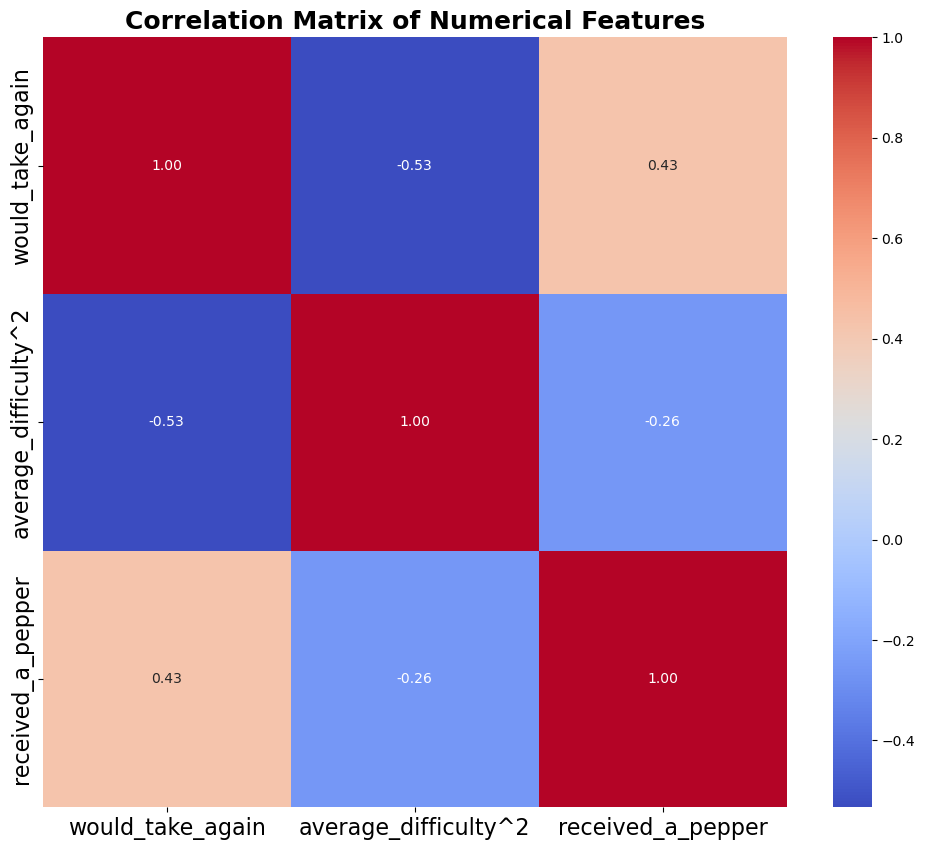

In [72]:
# select features with |weight| >= 0.05
selected_features = ["would_take_again", 
                     "average_difficulty^2", 
                     "received_a_pepper"]

# reduce training data 
x_train_transformation_reduced_7 = x_train_7[selected_features]
x_test_transformation_reduced_7 = x_test_7[selected_features]


# correlations between predictors 
corr_pred_transformation_reduced_7 = x_train_transformation_reduced_7.corr()

# Plot the heatmap using Seaborn
plt.figure(figsize=(12, 10)) # Adjust the figure size as needed

# plot itself
sns.heatmap(corr_pred_transformation_reduced_7, annot=True, cmap='coolwarm', fmt=".2f")

# aesthetics 
# title 
plt.title('Correlation Matrix of Numerical Features', fontweight = "bold", fontsize = 18)

# ticks
plt.tick_params(labelsize = 16)

# show the plot
plt.show()


The correlation matrix for the reduced feature set shows no evidence of severe multicollinearity:
- Correlations are all well below common concern thresholds of |0.7-0.8|.
- The strongest relationship is between `would_take_again` and `average_difficulty²` at -0.53, which reflects a meaningful behavioral association rather than redundancy.
- `received_a_pepper` shows only moderate correlation with the other predictors.

These results indicate that introducing the squared difficulty term does not materially inflate multicollinearity once the linear difficulty term is removed.
Given this, regularization via ElasticNet is no longer strictly necessary, and we proceed by refitting the model using LassoCV for improved simplicity and computational efficiency.

In [45]:
# cross-validation 
cv = KFold(n_splits=5, 
           shuffle=True, 
           random_state=n_number)

# pipeline for model 
pipeline_q7_transformation_reduced = Pipeline([
    ("imputer", KNNImputer(n_neighbors=20, 
                           weights= 'uniform', 
                           add_indicator= False)),
    ("scaler", StandardScaler()),
    ("model", LassoCV(
        cv = cv, 
        random_state = n_number,
        alphas = 100, 
        max_iter= 10000
    ))
])

# run cross-validation
cv_results_raw_7_transformation_reduced = cross_validate(
    pipeline_q7_transformation_reduced,
    x_train_transformation_reduced_7,
    y_train_7,
    cv=cv,
    scoring=("r2", "neg_root_mean_squared_error"),
    return_train_score=False, 
    return_estimator = True
)

# save results 
cv_results_7.append({
    "model": "LassoCV (with transformations and reduced variables)",
    "R2_mean": cv_results_raw_7_transformation_reduced["test_r2"].mean(),
    "RMSE_mean": (-cv_results_raw_7_transformation_reduced["test_neg_root_mean_squared_error"]).mean()
    })

# show as a dataframe
compare_models_q7_df = pd.DataFrame(cv_results_7).sort_values(by = "RMSE_mean").reset_index(drop = True)
compare_models_q7_df


,model,R2_mean,RMSE_mean
0,LassoCV (with transformations and reduced vari...,0.620632,0.568949
1,ElasticNetCV (with transformations and reduced...,0.620632,0.568950
2,LassoCV (reduced features),0.616401,0.572178
3,ElasticNetCV (with transformations),0.616248,0.572240
4,LassoCV (all features),0.601358,0.583260


In [73]:
# LassoCV (reduced features) performance on the test data
print("LassoCV (reduced features) performance on the test data\n")
score_model(pipeline_q7_reduced, 
            x_train_reduced_7, 
            x_test_reduced_7, 
            y_train_7,
            y_test_7)

LassoCV (reduced features) performance on the test data



{'Training RMSE': 0.5698553493853484,
 'Training R2': 0.6198719304932935,
 'Testing RMSE': 0.5656309773299064,
 'Testing R2': 0.638953475637948}

In [74]:
# LassoCV (transformation + reduced features) performance on the test data
print("LassoCV (transformation + reduced features) performance on the test data:\n")
score_model(pipeline_q7_transformation_reduced, 
            x_train_transformation_reduced_7, 
            x_test_transformation_reduced_7, 
            y_train_7, 
            y_test_7)

LassoCV (transformation + reduced features) performance on the test data:



{'Training RMSE': 0.5680857055527472,
 'Training R2': 0.6222291841292633,
 'Testing RMSE': 0.5612462433195867,
 'Testing R2': 0.6445293971194284}

Cross-validation results show that introducing nonlinear transformations improves model performance. The best cross-validated specification, LassoCV with transformations and reduced features, achieves an R² of approximately 0.621 and an RMSE of about 0.569, outperforming both the linear reduced model with an RMSE of roughly 0.572 and the full linear model with an RMSE near 0.583. ElasticNetCV produces nearly identical cross-validation metrics, indicating that multicollinearity is adequately controlled and that Lasso regularization is sufficient.

Evaluation on the held-out test set confirms this pattern. The reduced Lasso model attains a testing RMSE of about 0.566 and an R² of approximately 0.639, while the transformed reduced Lasso model further improves performance with a testing RMSE of roughly 0.561 and an R² near 0.645. These results motivate a final assessment of interaction effects to determine whether any additional structure remains unexploited.

#### Interactions

In [49]:
# create interaction variables 
# would take gain and difficulty 
x_train_7["wta_x_difficulty"] = (
x_train_7["would_take_again"] * x_train_7["average_difficulty"]
)

x_test_7["wta_x_difficulty"] = (
x_test_7["would_take_again"] * x_test_7["average_difficulty"]
)

x_train_7["wta_x_difficulty2"] = (
x_train_7["would_take_again"] * x_train_7["average_difficulty^2"]
)

x_test_7["wta_x_difficulty2"] = (
x_test_7["would_take_again"] * x_test_7["average_difficulty^2"]
)

# pepper and would take again 
x_train_7["pepper_x_wta"] = (
x_train_7["received_a_pepper"] * x_train_7["would_take_again"]
)

x_test_7["pepper_x_wta"] = (
x_test_7["received_a_pepper"] * x_test_7["would_take_again"]
)

# would take again and log_number of ratings 
x_train_7["wta_x_log_number_of_ratings"] = (x_train_7["would_take_again"] * x_train_7["number_of_ratings_online_log"])
x_train_7["wta_x_log_number_of_ratings"] = (x_train_7["would_take_again"] * x_train_7["number_of_ratings_online_log"])

x_train_7["wta_x_log_number_of_ratings_online"] = (x_train_7["would_take_again"] * x_train_7["number_of_ratings_online_log"])
x_train_7["wta_x_log_number_of_ratings_online"] = (x_train_7["would_take_again"] * x_train_7["number_of_ratings_online_log"])

x_test_7["wta_x_log_number_of_ratings"] = (x_test_7["would_take_again"] * x_test_7["number_of_ratings_online_log"])
x_test_7["wta_x_log_number_of_ratings"] = (x_test_7["would_take_again"] * x_test_7["number_of_ratings_online_log"])

x_test_7["wta_x_log_number_of_ratings_online"] = (x_test_7["would_take_again"] * x_test_7["number_of_ratings_online_log"])
x_test_7["wta_x_log_number_of_ratings_online"] = (x_test_7["would_take_again"] * x_test_7["number_of_ratings_online_log"])


In [51]:
# fixed cv
cv = KFold(n_splits = 5, 
           shuffle = True, 
           random_state = n_number)

# pipeline to test interactions
pipeline_q7_interactions = Pipeline([
    # null values imputer 
    ("imputer", KNNImputer(n_neighbors= 20, 
                           weights = "uniform", 
                           add_indicator= False)),
    
    # data standardization (scaler)
    ("scaler", StandardScaler()), 

    # model 
    ("model", ElasticNetCV(
        cv = cv, 
        alphas = 100, 
        max_iter= 10000, 
        random_state = n_number
    ))
])

# run cross_validation
cv_results_interactions_raw_7 = cross_validate(
    pipeline_q7_interactions, 
    x_train_7, 
    y_train_7, 
    cv = cv, 
    scoring = ("r2", "neg_root_mean_squared_error"), 
    return_train_score = False, 
    return_estimator = True
)

# save results 
cv_results_7.append({
    "model": "ElasticNet CV (interactions)",
    "R2_mean": cv_results_interactions_raw_7["test_r2"].mean(),
    "RMSE_mean": (-cv_results_interactions_raw_7["test_neg_root_mean_squared_error"]).mean()}
)

# create dataframe 
compare_models_q7_df = pd.DataFrame(cv_results_7).sort_values(by = "RMSE_mean").reset_index(drop = True)

# check results 
compare_models_q7_df




,model,R2_mean,RMSE_mean
0,ElasticNet CV (interactions),0.622001,0.567917
1,LassoCV (with transformations and reduced vari...,0.620632,0.568949
2,ElasticNetCV (with transformations and reduced...,0.620632,0.568950
3,LassoCV (reduced features),0.616401,0.572178
4,ElasticNetCV (with transformations),0.616248,0.572240
5,LassoCV (all features),0.601358,0.583260


In [52]:
# ElasticNet CV (interactions) performance on the test data:
print("ElasticNet CV (interactions) performance on the test data:")
score_model(pipeline_q7_interactions, 
            x_train_7, 
            x_test_7, 
            y_train_7, 
            y_test_7)

ElasticNet CV (interactions) performance on the test data:


{'Training RMSE': 0.5665413749005677,
 'Training R2': 0.6242803185248856,
 'Testing RMSE': 0.5658051137967789,
 'Testing R2': 0.6387311361745465}

In [75]:
# Lasso CV (transformation + reduced variables) performance on the test data:
print("Lasso CV (transformation + reduced variables) performance on the test data:")
score_model(pipeline_q7_transformation_reduced,
            x_train_transformation_reduced_7,
            x_test_transformation_reduced_7,
            y_train_7, 
            y_test_7)

Lasso CV (transformation + reduced variables) performance on the test data:


{'Training RMSE': 0.5680857055527472,
 'Training R2': 0.6222291841292633,
 'Testing RMSE': 0.5612462433195867,
 'Testing R2': 0.6445293971194284}

Cross-validation suggests that adding interaction terms yields a small improvement, with the ElasticNet interaction model achieving a CV RMSE of approximately 0.568 compared to about 0.569 for the best transformed main-effects model. However, this gain does not carry over to the test set. On held-out data, the interaction model attains a testing RMSE of roughly 0.566 and an R² of about 0.639, while the transformed reduced Lasso model achieves a lower testing RMSE of approximately 0.561 and a higher R² near 0.645. Given the marginal CV improvement, the lack of test-set gains, and the substantial increase in model complexity due to many interaction terms, the observed improvement is more likely attributable to noise rather than meaningful signal. At this stage, the best-performing and most stable model is the LassoCV with transformations and reduced features. We next examine coefficient magnitudes to further reduce the feature set and confirm whether a more parsimonious interaction specification can outperform the current benchmark.

In [54]:
# extract feature weights from the model
model = pipeline_q7_interactions.named_steps["model"]

# feature names
feature_names = x_train_7.columns.to_list()
# coefficients
coef = model.coef_

# build dataframe
weights_df_7 = pd.DataFrame({
    "tag": feature_names,
    "weight": coef
})

# sort by absolute weight
weights_df_7["abs_weight"] = weights_df_7["weight"].abs()
weights_df_7 = weights_df_7.sort_values("abs_weight", ascending=False)

# cleanup
weights_df_7 = weights_df_7.drop(columns="abs_weight").reset_index(drop=True)

# check 
weights_df_7

,tag,weight
0,average_difficulty^2,-0.409787
1,would_take_again,0.366029
2,received_a_pepper,0.275425
3,pepper_x_wta,-0.143366
4,wta_x_difficulty2,0.123690
5,number_of_ratings_online_log,-0.027645
6,wta_x_log_number_of_ratings,0.019372
7,wta_x_difficulty,0.012761
8,number_of_ratings_log,0.008482
9,wta_x_log_number_of_ratings_online,0.007925


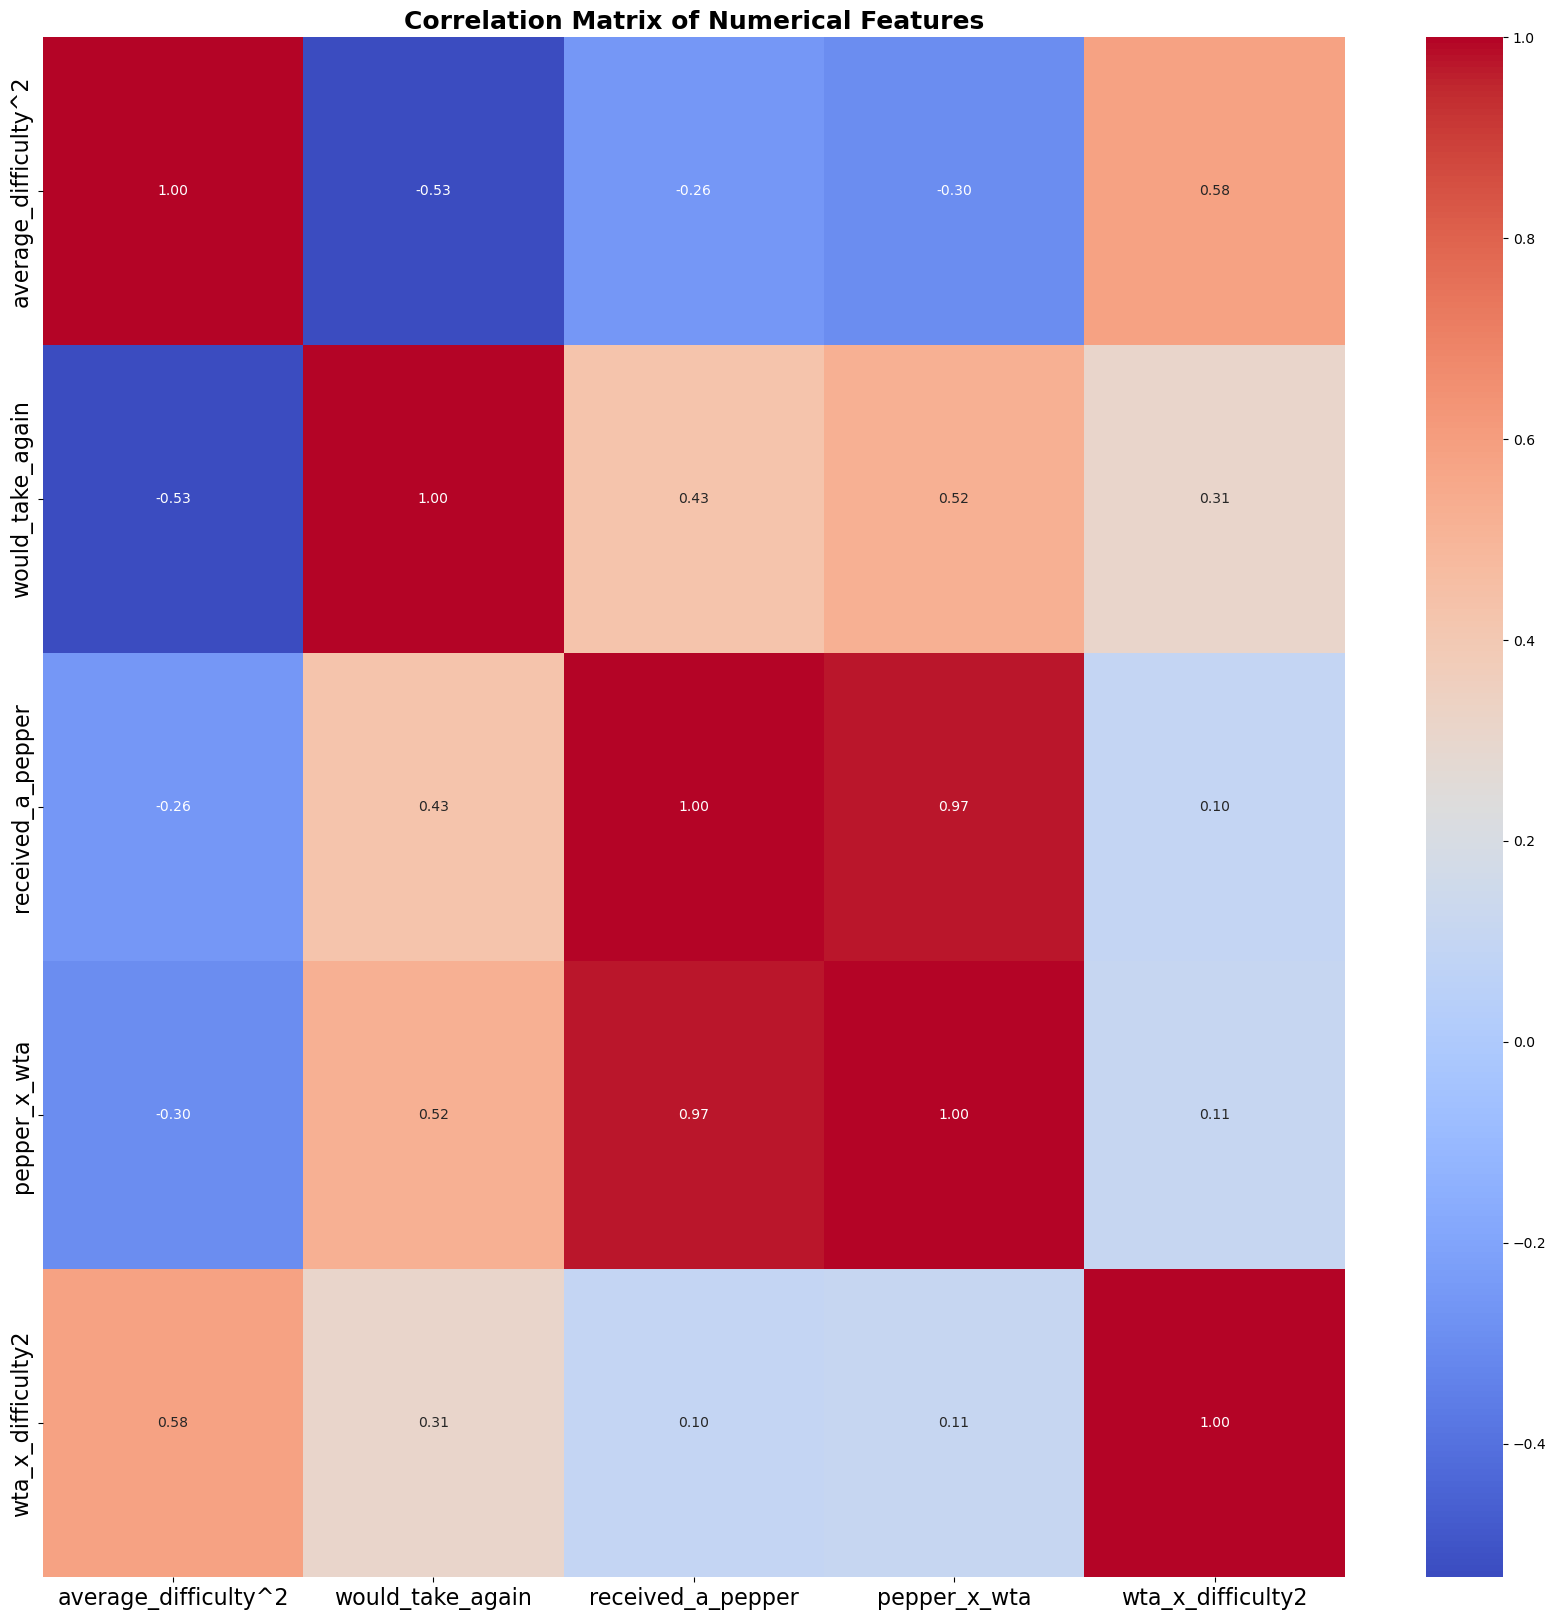

In [56]:
# select features with |weight| >= 0.05
selected_features = ["average_difficulty^2", 
                     "would_take_again",
                     "received_a_pepper", 
                     "pepper_x_wta",
                     "wta_x_difficulty2"]

# reduce training data 
x_train_interactions_reduced_7 = x_train_7[selected_features]
x_test_interactions_reduced_7 = x_test_7[selected_features]

# correlations between predictors 
corr_train_interactions_reduced_7 = x_train_interactions_reduced_7.corr()

# 3. Plot the heatmap using Seaborn
plt.figure(figsize=(21, 20)) # Adjust the figure size as needed

# plot itself
sns.heatmap(corr_train_interactions_reduced_7, annot=True, cmap='coolwarm', fmt=".2f")

# aesthetics 
# title 
plt.title('Correlation Matrix of Numerical Features', fontweight = "bold", fontsize = 18)

# ticks
plt.tick_params(labelsize = 16)

# show the plot
plt.show()

The correlation matrix for the interaction-augmented feature set shows substantial multicollinearity. In particular, the interaction term `pepper_x_wta` is almost perfectly correlated with `received_a_pepper (correlation ≈ 0.97)`, and `wta_x_difficulty²` exhibits moderate correlation with `average_difficulty² (≈ 0.58)`. These high correlations indicate strong redundancy introduced by interaction terms.

Under this level of multicollinearity, LassoCV alone becomes unstable, as it may arbitrarily select one of several highly correlated predictors. ElasticNet is therefore the appropriate choice, as its combined L1 and L2 penalties allow correlated features to be shrunk together while still performing variable selection. This justifies the use of ElasticNet for interaction models, even though Lasso was sufficient for the reduced main-effects specification.

In [57]:
# cross-validation 
cv = KFold(n_splits=5, 
           shuffle=True, 
           random_state=n_number)

# pipeline for model 
pipeline_q7_interactions_reduced = Pipeline([
    ("imputer", KNNImputer(n_neighbors=20, 
                           weights= 'uniform', 
                           add_indicator= False)),
    ("scaler", StandardScaler()),
    ("model", ElasticNetCV(
        cv = cv, 
        random_state = n_number,
        alphas = 100, 
        max_iter= 10000
    ))
])

# run cross-validation
cv_results_raw_7_interactions_reduced = cross_validate(
    pipeline_q7_interactions_reduced,
    x_train_interactions_reduced_7,
    y_train_7,
    cv=cv,
    scoring=("r2", "neg_root_mean_squared_error"),
    return_train_score=False, 
    return_estimator = True
)

# save results 
cv_results_7.append({
    "model": "ElasticNetCV (Interactions, reduced variables)",
    "R2_mean": cv_results_raw_7_interactions_reduced["test_r2"].mean(),
    "RMSE_mean": (-cv_results_raw_7_interactions_reduced["test_neg_root_mean_squared_error"]).mean()
    })

# show as a dataframe
compare_models_q7_df = pd.DataFrame(cv_results_7).sort_values(by = "RMSE_mean").reset_index(drop = True)
compare_models_q7_df



,model,R2_mean,RMSE_mean
0,"ElasticNetCV (Interactions, reduced variables)",0.625382,0.565384
1,ElasticNet CV (interactions),0.622001,0.567917
2,LassoCV (with transformations and reduced vari...,0.620632,0.568949
3,ElasticNetCV (with transformations and reduced...,0.620632,0.568950
4,LassoCV (reduced features),0.616401,0.572178
5,ElasticNetCV (with transformations),0.616248,0.572240
6,LassoCV (all features),0.601358,0.583260


In [58]:
# Lasso CV (transform + reduced variables) performance on test data:
print("Lasso CV (transform + reduced variables) performance on test data:\n")
score_model(pipeline_q7_transformation_reduced, 
            x_train_transformation_reduced_7, 
            x_test_transformation_reduced_7, 
            y_train_7, 
            y_test_7)

Lasso CV (transform + reduced variables) performance on test data:



{'Training RMSE': 0.5680857055527472,
 'Training R2': 0.6222291841292633,
 'Testing RMSE': 0.5612462433195867,
 'Testing R2': 0.6445293971194284}

In [60]:
# ElasticNet CV (interactions + reduced variables) performance on test data:
print("ElasticNet CV (interactions + reduced variables) performance on test data:\n")
score_model(pipeline_q7_interactions_reduced,
            x_train_interactions_reduced_7,
            x_test_interactions_reduced_7, 
            y_train_7, 
            y_test_7)

ElasticNet CV (interactions + reduced variables) performance on test data:



{'Training RMSE': 0.5672105931395734,
 'Training R2': 0.623392168149145,
 'Testing RMSE': 0.562808598345094,
 'Testing R2': 0.6425475779453074}

Although the interaction-based ElasticNet model achieves the best cross-validated RMSE of approximately 0.565, this improvement does not translate into superior test-set performance. On held-out data, the interaction model attains a testing RMSE of about 0.563 and an R² of roughly 0.643, which is slightly worse than the transformed reduced Lasso model, whose testing RMSE is approximately 0.561 with an R² near 0.645. Given the marginal cross-validation gains, the lack of test-set improvement, and the increased multicollinearity and complexity introduced by interaction terms, we conclude that the interaction specification is not worth the additional model complexity. From both an interpretability and stability perspective, the LassoCV model with nonlinear transformations and a reduced feature set represents the best balance of performance and parsimony.

At this stage, we shift our objective from balancing interpretability and performance to pure performance maximization. We therefore evaluate more flexible, nonlinear models capable of capturing complex interactions automatically. Specifically, we consider LightGBM and XGBoost, which are well-suited for tabular data and efficiently model higher-order interactions. We do not pursue standalone decision trees or random forests, as single trees are prone to high variance and random forests typically underperform gradient-boosted methods in predictive accuracy while offering less efficient bias reduction.

### Extra: Prediction Accuracy Optimization

##### LightGBM

We first evaluate whether LightGBM benefits from our tuned KNN imputation compared to simpler missing-value strategies. Specifically, we compare four preprocessing options, tuned KNN imputation, mean imputation, median imputation, and no imputation. For each option, we measure cross-validated RMSE and R² using the same 5-fold split to ensure a fair comparison.

After selecting the imputation strategy that yields the best cross-validated RMSE, we fix this preprocessing choice and tune the LightGBM hyperparameters with Optuna. This two-stage approach separates preprocessing selection from model tuning and ensures that hyperparameter optimization is performed on the strongest preprocessing setup.

In [61]:
# fixed cross-validation 
cv = KFold(n_splits = 5, 
           shuffle = True, 
           random_state = n_number)

# pipelines for comparison
pipelines_q7_lgbm = {
    "LGBMRegressor (no imputation)": Pipeline([
        # scaler 
        ("scaler", StandardScaler()), 

        # model 
        ("model", LGBMRegressor(random_state = n_number, 
                                objective = "regression", 
                                metric = "rmse",
                                n_jobs = 1, 
                                verbosity = -1))
    ]), 

    "LGBMRegreessor (KNNImputer)": Pipeline([
        # imputer
        ("imputer", KNNImputer(n_neighbors=20, 
                               weights="uniform", 
                               add_indicator=False)),

        # scaler 
        ("scaler", StandardScaler()),   

        # model 
        ("model", LGBMRegressor(random_state = n_number, 
                                objective = "regression", 
                                metric = "rmse",
                                n_jobs = 1, 
                                verbosity = -1)) 
    ]),

    "LGBMRegressor (SimpleImputer - mean)": Pipeline([
        # imputer
        ("imputer", SimpleImputer(strategy="mean", 
                                  add_indicator=False)),

        # scaler 
        ("scaler", StandardScaler()),   

        # model 
        ("model", LGBMRegressor(random_state = n_number, 
                                objective = "regression", 
                                metric = "rmse",
                                n_jobs = 1, 
                                verbosity = -1)) 
    ]), 

    "LGBMRegressor (SimpleImputer - median)": Pipeline([
        # imputer
        ("imputer", SimpleImputer(strategy="median", 
                                  add_indicator=False)),

        # scaler 
        ("scaler", StandardScaler()),   

        # model 
        ("model", LGBMRegressor(random_state = n_number, 
                                objective = "regression", 
                                metric = "rmse",
                                n_jobs = 1, 
                                verbosity = -1)) 
    ]),
}

# compare and cross_validate the pipelines 
rows_lgbm = []
for name, pipe in pipelines_q7_lgbm.items():
    results_lgbm = cross_validate(
        pipe,
        x_train_7,
        y_train_7,
        cv=cv,
        scoring=("r2", "neg_root_mean_squared_error"),
        return_train_score=False,
        n_jobs=-1
    )
    rows_lgbm.append({
        "model": name,
        "R2_mean": results_lgbm["test_r2"].mean(),
        "RMSE_mean": (-results_lgbm["test_neg_root_mean_squared_error"]).mean()
    })

# create a dataframe for comparison
compare_lgbm_df = (
    pd.DataFrame(rows_lgbm)
      .sort_values("RMSE_mean", 
                   ascending= True)
      .reset_index(drop=True)
)

# check the results
compare_lgbm_df

,model,R2_mean,RMSE_mean
0,LGBMRegressor (SimpleImputer - median),0.636778,0.556684
1,LGBMRegressor (SimpleImputer - mean),0.636719,0.556722
2,LGBMRegressor (no imputation),0.636472,0.556917
3,LGBMRegreessor (KNNImputer),0.628883,0.562709


Cross-validation results show that LightGBM achieves its best performance without aggressive imputation. While median and mean imputation produce slightly lower RMSE values (≈ 0.557) compared to no imputation (≈ 0.557), the differences are marginal and well within noise. In contrast, KNN imputation degrades performance noticeably, increasing RMSE to approximately 0.563. Given that LightGBM natively handles missing values by learning optimal split directions, explicit mean or median imputation offers no meaningful benefit and may remove informative missingness patterns. We therefore proceed without imputation for LightGBM, as it provides comparable or better performance with a simpler and more faithful representation of the data.

In [62]:
# fixed cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=n_number)

# pipeline for LightGBM 
lgbm_pipe = Pipeline([
    # scaler 
    ("scaler", StandardScaler()),
    
    # model itself 
    ("model", LGBMRegressor(
        objective = "regression", 
        metric = "rmse", 
        random_state=n_number,
        n_jobs=1,
        verbosity=-1
    ))
])

# optuna objective
def objective_lgbm(trial):
    # parameters to tune
    params = {
        # core tree shape
        "model__num_leaves": trial.suggest_int("model__num_leaves", 15, 255),
        "model__max_depth": trial.suggest_int("model__max_depth", -1, 16),
        "model__min_child_samples": trial.suggest_int("model__min_child_samples", 5, 200),

        # learning
        "model__n_estimators": trial.suggest_int("model__n_estimators", 200, 3000),
        "model__learning_rate": trial.suggest_float("model__learning_rate", 0.005, 0.2, log=True),

        # subsampling
        "model__subsample": trial.suggest_float("model__subsample", 0.6, 1.0),
        "model__colsample_bytree": trial.suggest_float("model__colsample_bytree", 0.6, 1.0),

        # regularization
        "model__reg_alpha": trial.suggest_float("model__reg_alpha", 1e-8, 10.0, log=True),
        "model__reg_lambda": trial.suggest_float("model__reg_lambda", 1e-8, 10.0, log=True),

        # split control
        "model__min_split_gain": trial.suggest_float("model__min_split_gain", 0.0, 0.5),
    }

    # clone pipeline and set parameters
    pipe = clone(lgbm_pipe)
    pipe.set_params(**params)

    # cross-validation score with tuned parameters
    scores = cross_val_score(
        pipe,
        x_train_7,
        y_train_7,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1
    )

    return -scores.mean()

# run optuna
study_lgbm = start_study_optuna(
    objective=objective_lgbm,
    n_trials=50,    # number of trials 
    sampler_seed=n_number,
    direction="minimize"
)

[I 2026-01-25 21:30:01,078] A new study created in memory with name: no-name-1565b943-0eba-4100-a70c-2d496706e319
[I 2026-01-25 21:30:01,436] Trial 0 finished with value: 0.5549320653788052 and parameters: {'model__num_leaves': 77, 'model__max_depth': 5, 'model__min_child_samples': 107, 'model__n_estimators': 738, 'model__learning_rate': 0.0187723140292542, 'model__subsample': 0.7445336836373633, 'model__colsample_bytree': 0.6408023967045857, 'model__reg_alpha': 5.3874727250769205e-06, 'model__reg_lambda': 0.06280715236841564, 'model__min_split_gain': 0.3289713088537308}. Best is trial 0 with value: 0.5549320653788052.
[I 2026-01-25 21:30:02,586] Trial 1 finished with value: 0.5603152749705915 and parameters: {'model__num_leaves': 63, 'model__max_depth': 10, 'model__min_child_samples': 192, 'model__n_estimators': 1000, 'model__learning_rate': 0.1225226099530034, 'model__subsample': 0.6806109309369683, 'model__colsample_bytree': 0.6286895037328117, 'model__reg_alpha': 0.0022086296848811

Best Params: {'model__num_leaves': 17, 'model__max_depth': 14, 'model__min_child_samples': 34, 'model__n_estimators': 1481, 'model__learning_rate': 0.0223505675780278, 'model__subsample': 0.6789874141084263, 'model__colsample_bytree': 0.7391451468449096, 'model__reg_alpha': 1.669393824890191e-06, 'model__reg_lambda': 0.03453316496180948, 'model__min_split_gain': 0.048604513753357725}


In [63]:
# cross-validate the model with best parameters
# set the best parameters to the pipeline
lgbm_pipe.set_params(**study_lgbm.best_params)

cv_results_raw_lgbm = cross_validate(
    lgbm_pipe,
    x_train_7,
    y_train_7,
    cv=cv,
    scoring=("r2", "neg_root_mean_squared_error"),
    return_train_score=False, 
    return_estimator = True
)

# results
cv_results_7.append({
    "model": "LightGBM (no imputation)",
    "R2_mean": cv_results_raw_lgbm["test_r2"].mean(),
    "RMSE_mean": -cv_results_raw_lgbm["test_neg_root_mean_squared_error"].mean()
})

# add to comparison dataframe 
compare_models_q7_df = pd.DataFrame(cv_results_7).sort_values(by = "RMSE_mean").reset_index(drop = True)

# check results 
compare_models_q7_df


c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,model,R2_mean,RMSE_mean
0,LightGBM (no imputation),0.640371,0.553919
1,"ElasticNetCV (Interactions, reduced variables)",0.625382,0.565384
2,ElasticNet CV (interactions),0.622001,0.567917
3,LassoCV (with transformations and reduced vari...,0.620632,0.568949
4,ElasticNetCV (with transformations and reduced...,0.620632,0.568950
5,LassoCV (reduced features),0.616401,0.572178
6,ElasticNetCV (with transformations),0.616248,0.572240
7,LassoCV (all features),0.601358,0.583260


In [64]:
# performance of LightGBM on test data:
print("LightGBM model performance on test data:\n")
score_model(
    lgbm_pipe,
    x_train_7,
    x_test_7,
    y_train_7,
    y_test_7
)

LightGBM model performance on test data:



c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


{'Training RMSE': 0.541147251181569,
 'Training R2': 0.6572072764397039,
 'Testing RMSE': 0.5521130903365432,
 'Testing R2': 0.6560044021120512}

In [66]:
# performance of LassoCV (transformation + reduced variables) on test data:
print("performance of LassoCV (transformation + reduced variables) on test data:\n")
score_model(
    pipeline_q7_transformation_reduced,
    x_train_transformation_reduced_7,
    x_test_transformation_reduced_7,
    y_train_7,
    y_test_7
)

performance of LassoCV (transformation + reduced variables) on test data:



{'Training RMSE': 0.5680857055527472,
 'Training R2': 0.6222291841292633,
 'Testing RMSE': 0.5612462433195867,
 'Testing R2': 0.6445293971194284}

Cross-validation results show a clear and non-marginal improvement from LightGBM relative to all linear and regularized models. The LightGBM model without imputation achieves a CV RMSE of approximately 0.554, improving substantially over the best linear specification, whose CV RMSE is around 0.569. This gain carries over to the test set, where LightGBM attains a testing RMSE of about 0.552 and an R² of roughly 0.656, compared to a testing RMSE of approximately 0.561 and an R² near 0.645 for the transformed reduced Lasso model. Unlike earlier stages, this improvement is large enough to be considered meaningful and cannot be attributed to noise or minor functional-form adjustments.

Given this clear performance gap, we conclude that LightGBM is able to capture nonlinearities and higher-order interactions that linear models fail to exploit, even after extensive feature engineering. Before proceeding to XGBoost for further performance maximization, we first examine LightGBM feature importance to understand which variables drive these gains and whether the model relies on sensible, interpretable structure rather than spurious interactions.

C:\Users\nyuss\AppData\Local\Temp\ipykernel_42044\3567025496.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, x_train_7)


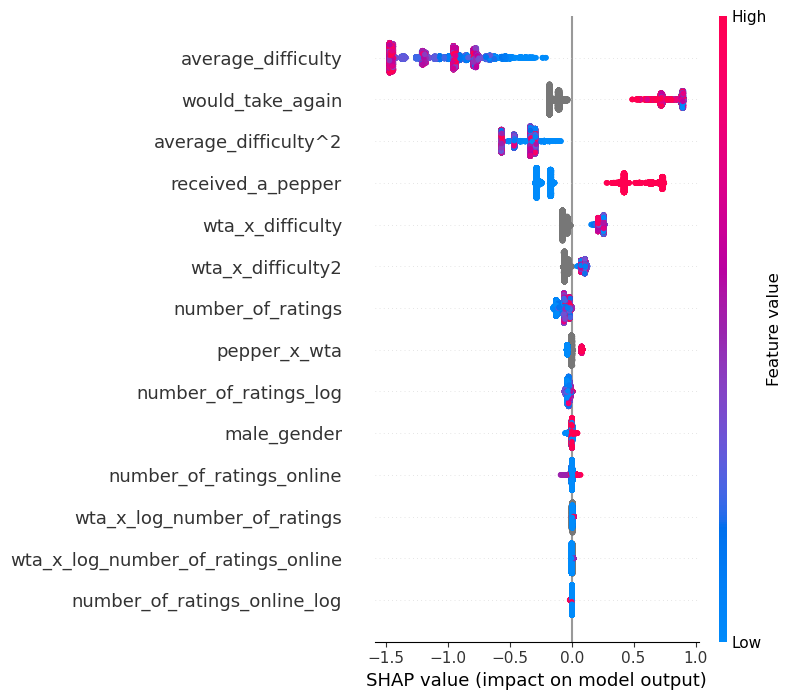

In [79]:
# shapley values
explainer = shap.TreeExplainer(lgbm_pipe.named_steps["model"])
shap_values = explainer.shap_values(x_train_7)   

# plot 
shap.summary_plot(shap_values, x_train_7)

`average_difficulty` is the single strongest driver of predictions. Low difficulty values consistently increase predicted ratings, while high difficulty values decrease them. The wide spread of SHAP values shows a strong nonlinear effect, which LightGBM captures directly through splits rather than relying on engineered polynomial terms.

`would_take_again` is the second most influential feature and has a strong, monotonic positive impact. Higher values reliably push predictions upward across almost all observations, confirming that student willingness to retake a professor is the most stable sentiment signal in the data.

`received_a_pepper`  has a positive but smaller effect. Its SHAP values are more dispersed, indicating that the pepper signal matters, but only conditionally and less consistently than the two dominant variables.

All remaining features, including engineered interactions, squared terms, counts, and demographic indicators, have SHAP values concentrated near zero. They contribute little to predictions once difficulty and willingness to retake are accounted for.

In short, LightGBM’s performance gains are driven almost entirely by three variables: average difficulty, willingness to take the professor again, and pepper status. Everything else is secondary or redundant. Now we will assess Xgboost. 

#### Xgboost 

We now again are going to evaluate Whether Xgboos benefits from our tuned KNN imputation compared to simpler missing-value strategies. As with Lightgbm, we compare four preprocessing options, tuned KNN imputation, mean imputation, median imputation, and no imputation. For each option, we measure cross-validated RMSE and R² using the same 5-fold split to ensure a fair comparison.

After selecting the imputation strategy that yields the best cross-validated RMSE, we fix this preprocessing choice and tune the Xgboost hyperparameters with Optuna. 

In [67]:
# fixed cross-validation 
cv = KFold(n_splits = 5, 
           shuffle = True, 
           random_state = n_number)

# pipelines for comparison
pipelines_q7_xgboost = {
    "XGBRegressor (no imputation)": Pipeline([
        # model 
        ("model", XGBRegressor(
            objective="reg:squarederror",
            eval_metric="rmse",
            tree_method="hist",
            random_state=n_number,
            verbosity=0,
            n_jobs=1
        ))
    ]), 

    "XGBRegressor (KNNImputer)": Pipeline([
        # imputer
        ("imputer", KNNImputer(
            n_neighbors=20, 
            weights="uniform", 
            add_indicator=False
        )),

        # model 
        ("model", XGBRegressor(
            objective="reg:squarederror",
            eval_metric="rmse",
            tree_method="hist",
            random_state=n_number,
            verbosity = 0,
            n_jobs=1
        )) 
    ]),

    "XGBRegressor (SimpleImputer - mean)": Pipeline([
        # imputer
        ("imputer", SimpleImputer(
            strategy="mean", 
            add_indicator=False
        )),

        # model 
        ("model", XGBRegressor(
            objective="reg:squarederror",
            eval_metric="rmse",
            tree_method="hist",
            random_state=n_number,
            verbosity = 0,
            n_jobs=1
        )) 
    ]), 

    "XGBRegressor (SimpleImputer - median)": Pipeline([
        # imputer
        ("imputer", SimpleImputer(
            strategy="median", 
            add_indicator=False
        )),

        # model 
        ("model", XGBRegressor(
            objective="reg:squarederror",
            eval_metric="rmse",
            tree_method="hist",
            random_state=n_number,
            verbosity = 0,
            n_jobs=1
        )) 
    ]),
}

# compare and cross_validate the pipelines 
rows_xgboost = []
for name, pipe in pipelines_q7_xgboost.items():
    results_xgboost = cross_validate(
        pipe,
        x_train_7,
        y_train_7,
        cv=cv,
        scoring=("r2", "neg_root_mean_squared_error"),
        return_train_score=False,
        n_jobs=-1
    )
    rows_xgboost.append({
        "model": name,
        "R2_mean": results_xgboost["test_r2"].mean(),
        "RMSE_mean": (-results_xgboost["test_neg_root_mean_squared_error"]).mean()
    })

# create a dataframe for comparison
compare_xgboost_df = (
    pd.DataFrame(rows_xgboost)
      .sort_values("RMSE_mean", ascending=True)
      .reset_index(drop=True)
)

# check the results
compare_xgboost_df


,model,R2_mean,RMSE_mean
0,XGBRegressor (no imputation),0.623180,0.567048
1,XGBRegressor (SimpleImputer - mean),0.623084,0.567136
2,XGBRegressor (SimpleImputer - median),0.622830,0.567313
3,XGBRegressor (KNNImputer),0.606813,0.579235


The best XGBoost specification without imputation achieves a CV RMSE of approximately 0.567 and an R² of about 0.623, which is comparable to but slightly worse than LightGBM’s CV RMSE of roughly 0.554. Mean and median imputation lead to nearly identical results, while KNN imputation substantially degrades performance, increasing RMSE to approximately 0.579.

These results suggest that, similar to LightGBM, XGBoost does not benefit from explicit imputation and may leverage missingness implicitly. 

In [68]:
# fixed cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=n_number)

# pipeline for XGBoost
xgb_pipe = Pipeline([
    # scaler 
    ("scaler", StandardScaler()), 

    # model itself 
    ("model", XGBRegressor(
        objective="reg:squarederror",
        random_state=n_number,
        n_jobs=1,              
        tree_method="hist",
        eval_metric="rmse"
    ))
])

# optuna objective
def objective_xgb(trial):
    params = {
        # core tree shape
        "model__max_depth": trial.suggest_int("model__max_depth", 2, 12),
        "model__min_child_weight": trial.suggest_float("model__min_child_weight", 1.0, 50.0, log=True),
        "model__gamma": trial.suggest_float("model__gamma", 0.0, 5.0),

        # learning
        "model__n_estimators": trial.suggest_int("model__n_estimators", 200, 3000),
        "model__learning_rate": trial.suggest_float("model__learning_rate", 0.005, 0.2, log=True),

        # subsampling
        "model__subsample": trial.suggest_float("model__subsample", 0.6, 1.0),
        "model__colsample_bytree": trial.suggest_float("model__colsample_bytree", 0.6, 1.0),
        "model__colsample_bylevel": trial.suggest_float("model__colsample_bylevel", 0.6, 1.0),

        # regularization
        "model__reg_alpha": trial.suggest_float("model__reg_alpha", 1e-8, 10.0, log=True),
        "model__reg_lambda": trial.suggest_float("model__reg_lambda", 1e-8, 50.0, log=True),

        # split control
        "model__max_delta_step": trial.suggest_int("model__max_delta_step", 0, 10),
    }

    pipe = clone(xgb_pipe)
    pipe.set_params(**params)

    scores = cross_val_score(
        pipe,
        x_train_7,
        y_train_7,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1
    )

    return -scores.mean()

# run optuna
study_xgb = start_study_optuna(
    objective=objective_xgb,
    n_trials=50,
    sampler_seed=n_number,
    direction="minimize"
)

# after tuning, set best params and cross-validate for R2 + RMSE
xgb_pipe.set_params(**study_xgb.best_params)

# raw results 
cv_results_raw_xgb = cross_validate(
    xgb_pipe,
    x_train_7,
    y_train_7,
    cv=cv,
    scoring=("r2", "neg_root_mean_squared_error"),
    return_train_score=False,
    return_estimator=True
)

# append the results 
cv_results_7.append({
    "model": "XGBoost",
    "R2_mean": cv_results_raw_xgb["test_r2"].mean(),
    "RMSE_mean": -cv_results_raw_xgb["test_neg_root_mean_squared_error"].mean()
})


# show and save as pdf 
compare_models_q7_df = (pd.DataFrame(cv_results_7).sort_values("RMSE_mean").reset_index(drop=True)
)
compare_models_q7_df


[I 2026-01-25 21:34:56,365] A new study created in memory with name: no-name-b091515e-4b47-4235-8f07-d923b59177b9
[I 2026-01-25 21:34:56,979] Trial 0 finished with value: 0.5559412732941522 and parameters: {'model__max_depth': 4, 'model__min_child_weight': 3.7418704964074134, 'model__gamma': 2.6090390391207032, 'model__n_estimators': 738, 'model__learning_rate': 0.0187723140292542, 'model__subsample': 0.7445336836373633, 'model__colsample_bytree': 0.6408023967045857, 'model__colsample_bylevel': 0.7213948926440281, 'model__reg_alpha': 0.06280715236841564, 'model__reg_lambda': 0.02406388335281008, 'model__max_delta_step': 2}. Best is trial 0 with value: 0.5559412732941522.
[I 2026-01-25 21:34:59,126] Trial 1 finished with value: 0.5538878694442019 and parameters: {'model__max_depth': 9, 'model__min_child_weight': 42.49859240110514, 'model__gamma': 1.4297819017777784, 'model__n_estimators': 2628, 'model__learning_rate': 0.010515474453343615, 'model__subsample': 0.6286895037328117, 'model_

Best Params: {'model__max_depth': 4, 'model__min_child_weight': 4.830420846165837, 'model__gamma': 0.6268791916067082, 'model__n_estimators': 2823, 'model__learning_rate': 0.0050935955202186, 'model__subsample': 0.6707873089683427, 'model__colsample_bytree': 0.7877809002405042, 'model__colsample_bylevel': 0.8929741163866015, 'model__reg_alpha': 1.6292010203633038, 'model__reg_lambda': 0.08465563648315001, 'model__max_delta_step': 9}


,model,R2_mean,RMSE_mean
0,XGBoost,0.641070,0.553379
1,LightGBM (no imputation),0.640371,0.553919
2,"ElasticNetCV (Interactions, reduced variables)",0.625382,0.565384
3,ElasticNet CV (interactions),0.622001,0.567917
4,LassoCV (with transformations and reduced vari...,0.620632,0.568949
5,ElasticNetCV (with transformations and reduced...,0.620632,0.568950
6,LassoCV (reduced features),0.616401,0.572178
7,ElasticNetCV (with transformations),0.616248,0.572240
8,LassoCV (all features),0.601358,0.583260


Based on cross-validation performance alone, there is no justification to pursue XGBoost further. Although XGBoost marginally outperforms LightGBM in R², the difference in RMSE is negligible, and both models fall well within the same performance range. Given the additional tuning complexity and reduced interpretability of XGBoost, further analysis of its test-set performance or feature importance is unwarranted.

Among nonlinear models, LightGBM offers the best balance of predictive accuracy and practical interpretability, achieving strong performance while still allowing partial explanation through feature importance and SHAP values. When performance is the sole objective, LightGBM is therefore the preferred model.

From a perspective that balances explainability and performance, the LassoCV model with nonlinear transformations and a reduced feature set remains the most appropriate choice. It delivers competitive predictive accuracy relative to other linear specifications while maintaining transparent and stable coefficient interpretations.

## Q8 - Build a regression model predicting average ratings from all tags (the ones in the rmpCapstoneTags.csv) file. Make sure to include the R2 and RMSE of this model. Which of these tags is most strongly predictive of average rating?



In [22]:
# copy the data for the question
df_8 = df_filtered_final[df_tags_column_names + ["average_rating"]].copy()

In [23]:
# information about the dataset
df_8.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18422 entries, 5 to 89890
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   tough_grader                          18422 non-null  float64
 1   good_feedback                         18422 non-null  float64
 2   respected                             18422 non-null  float64
 3   lots_to_read                          18422 non-null  float64
 4   participation_matters                 18422 non-null  float64
 5   dont_skip_class_or_you_will_not_pass  18422 non-null  float64
 6   lots_of_homework                      18422 non-null  float64
 7   inspirational                         18422 non-null  float64
 8   pop_quizzes                           18422 non-null  float64
 9   accessible                            18422 non-null  float64
 10  so_many_papers                        18422 non-null  float64
 11  clear_grading       

In [24]:
# split the data into x and y 
# x 
x_8 = df_8.drop(columns = "average_rating")

# y 
y_8 = df_8["average_rating"]

# split the data into train and test data 
x_train_8, x_test_8, y_train_8, y_test_8 = train_test_split(x_8, y_8, test_size=0.2, random_state=n_number)

# check distributions of the data 
print(f'Number of rows for train data:{y_train_8.shape[0]}\n')
print(f'Number of rows for test data:{y_test_8.shape[0]}\n')

Number of rows for train data:14737

Number of rows for test data:3685



In [25]:
# correlation of predictors with the target 
corr_8_y = x_train_8.corrwith(y_train_8, 
                              method = 'pearson').sort_values(ascending= False)

# check 
corr_8_y

respected                               0.461602
caring                                  0.426650
good_feedback                           0.417428
amazing_lectures                        0.381139
inspirational                           0.362387
hilarious                               0.303961
clear_grading                           0.215989
accessible                              0.142289
extra_credit                            0.098251
participation_matters                   0.036851
group_projects                         -0.129535
pop_quizzes                            -0.135454
graded_by_few_things                   -0.168164
so_many_papers                         -0.225736
test_heavy                             -0.272839
dont_skip_class_or_you_will_not_pass   -0.283200
lots_to_read                           -0.298097
lots_of_homework                       -0.339177
lecture_heavy                          -0.370611
tough_grader                           -0.665928
dtype: float64

These correlations reveal a strong and structured relationship between course characteristics and average ratings. On the positive side, teaching quality and instructor behavior dominate. Being respected shows the highest positive correlation with ratings (0.46), followed closely by caring (0.43) and good feedback (0.42). Engaging delivery also matters. Amazing lectures (0.38), inspirational teaching (0.36), and being humorous (0.30) all show moderate positive associations. Clear grading (0.22) and accessibility (0.14) contribute positively but with smaller magnitudes, while extra credit has only a minor association (0.10).

Negative correlations are even more pronounced and largely reflect course rigor and grading strictness. Tough grading exhibits the strongest relationship in absolute value (-0.67), making it the single most influential correlate in the list. Lecture-heavy formats (-0.37), lots of homework (-0.34), lots to read (-0.30), and strict attendance or assessment rules such as dont skip class (-0.28) and test heavy (-0.27) are all associated with substantially lower ratings. Smaller but still negative effects appear for so many papers (-0.23), graded by few things (-0.17), pop quizzes (-0.14), and group projects (-0.13).

At the same time, these magnitudes suggest substantial overlap across predictors. Many workload-related tags cluster tightly in the range from about -0.27 to -0.37, while instructor-quality tags cluster between roughly 0.30 and 0.46. This raises concerns that individual coefficients in a multivariate model may reflect shared signal rather than distinct effects.

For this reason, the next step focuses on assessing multicollinearity among these variables, to determine how much redundancy exists and how it may affect coefficient stability and interpretation.

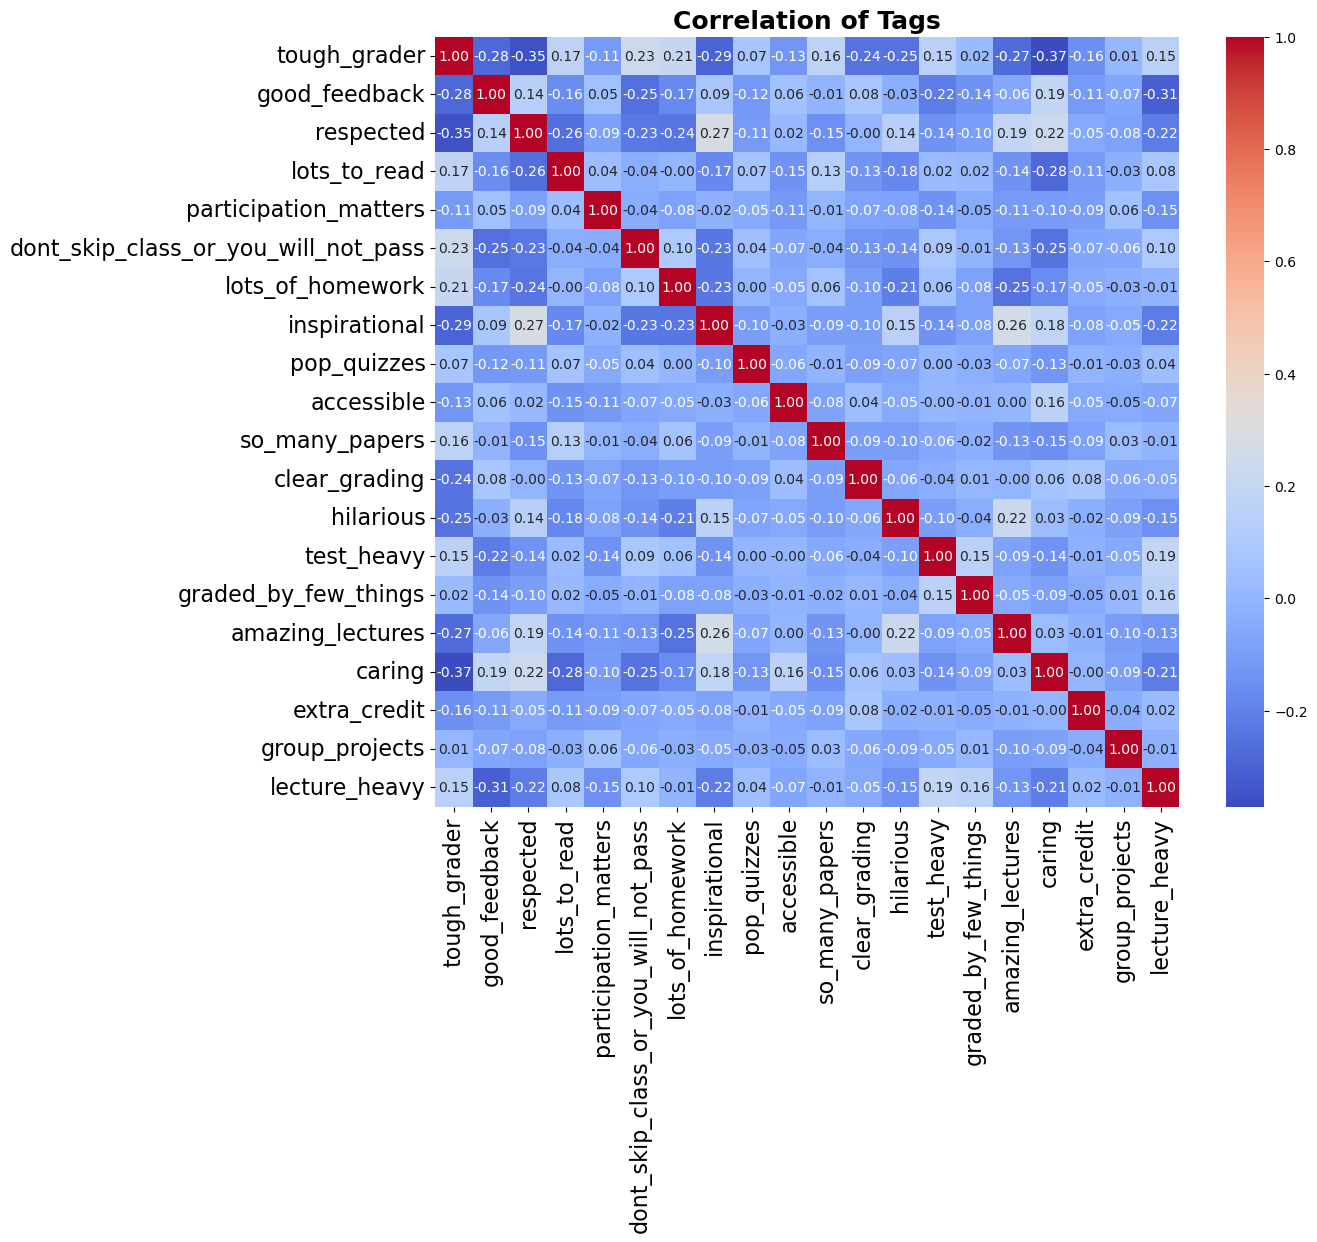

In [187]:
# plot the heatmap of correlations between predictors 

# figure size 
plt.figure(figsize = (12, 10))

# plot itself 
sns.heatmap(x_train_8.corr(), 
            annot = True, 
            cmap = "coolwarm", 
            fmt = ".2f")

# aesthetics 
# title 
plt.title("Correlation of Tags", 
          fontweight = "bold", 
          fontsize = 18)

# ticks
plt.tick_params(labelsize = 16)

# show the plot
plt.show()


The correlation matrix shows limited multicollinearity among the tag variables. Most pairwise correlations fall between -0.30 and 0.30, well below common concern thresholds. The strongest relationships appear where expected but remain moderate. For example, tough grader correlates negatively with caring (-0.37) and respected (-0.35), while respected correlates positively with caring (0.22) and inspirational (0.27). Workload-related tags such as lots of homework, lots to read, lecture heavy, and test heavy show correlations mostly in the -0.20 to -0.30 range.

There are no clusters with correlations approaching 0.7 or higher. While several tags capture related aspects of teaching quality or course rigor, the overlap is not strong enough to raise serious multicollinearity concerns.

Given this, we proceed to fit a linear regression model using the tag variables jointly, with coefficient estimates expected to remain stable and interpretable.

### Linear Regression

In [188]:
# fixed CV
cv = KFold(n_splits=5, shuffle=True, random_state=n_number)

# pipelines for linear model comparison (no imputation)
pipelines_linear = {
    "LinearRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),

    "RidgeCV": Pipeline([
        ("scaler", StandardScaler()),
        ("model", RidgeCV(
            alphas=np.logspace(-4, 4, 50),
            cv=cv
        ))
    ]),

    "LassoCV": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LassoCV(
            alphas=100,
            cv=cv,
            random_state=n_number,
            max_iter=10000
        ))
    ]),

    "ElasticNetCV": Pipeline([
        ("scaler", StandardScaler()),
        ("model", ElasticNetCV(
            l1_ratio=[0.1, 0.5, 0.9],
            alphas=100,
            cv=cv,
            random_state=n_number,
            max_iter=10000
        ))
    ])
}

# compare models
rows = []
for name, pipe in pipelines_linear.items():
    results = cross_validate(
        pipe,
        x_train_8,
        y_train_8,
        cv=cv,
        scoring=("r2", "neg_root_mean_squared_error"),
        n_jobs=-1,
        return_train_score=False
    )

    rows.append({
        "model": name,
        "R2_mean": results["test_r2"].mean(),
        "RMSE_mean": (-results["test_neg_root_mean_squared_error"]).mean()
    })

compare_models_q8_df = (
    pd.DataFrame(rows)
      .sort_values("RMSE_mean", ascending=True)
      .reset_index(drop=True)
)

# check results 
compare_models_q8_df

,model,R2_mean,RMSE_mean
0,LinearRegression,0.707867,0.499387
1,RidgeCV,0.707794,0.499451
2,LassoCV,0.707458,0.499734
3,ElasticNetCV,0.707454,0.499736


In [189]:
# check models on test data
for name, pipe in pipelines_linear.items():
    print(f"\nModel: {name}")
    print(score_model(
        pipe,
        x_train_8,
        x_test_8,
        y_train_8,
        y_test_8
    ))



Model: LinearRegression
{'Training RMSE': 0.4979435829188301, 'Training R2': 0.7097575302232528, 'Testing RMSE': 0.5042372449577667, 'Testing R2': 0.7130761569995572}

Model: RidgeCV
{'Training RMSE': 0.49794704012042723, 'Training R2': 0.7097534999264568, 'Testing RMSE': 0.5041681838058732, 'Testing R2': 0.7131547467282382}

Model: LassoCV
{'Training RMSE': 0.4982272648019333, 'Training R2': 0.709426729758896, 'Testing RMSE': 0.50375740902208, 'Testing R2': 0.7136219749260221}

Model: ElasticNetCV
{'Training RMSE': 0.49822805334740133, 'Training R2': 0.7094258099761668, 'Testing RMSE': 0.5037613859746959, 'Testing R2': 0.713617453240341}


We fitted several linear models using the tag variables, including ordinary least squares, Ridge, Lasso, and Elastic Net, under an identical cross-validation and preprocessing setup. All four models deliver virtually identical performance. Cross-validated R² is approximately 0.708 across specifications, and RMSE is tightly clustered around 0.50. Differences in error are extremely small, on the order of 0.0003 to 0.0004, indicating that regularization does not materially affect predictive accuracy in this setting.

Hold-out test results confirm the same pattern. Training and testing metrics are closely aligned for all models, with test RMSE around 0.504 and test R² around 0.713. This consistency indicates stable generalization and reinforces the conclusion that plain linear regression already captures most of the available signal.

These findings are consistent with the earlier multicollinearity analysis. Since the tag variables exhibit only moderate pairwise correlations, coefficient instability is limited, and shrinkage provides little benefit in terms of prediction. Ridge and Elastic Net therefore offer no practical advantage over ordinary least squares.

Despite this, Lasso remains a reasonable choice for the final linear specification. Although its predictive performance is nearly indistinguishable from the other models, Lasso introduces coefficient shrinkage and implicit feature selection. This improves interpretability and provides a safeguard against overfitting if additional or noisier predictors are introduced.

We therefore proceed with the Lasso model and examine its estimated coefficients. The next step is to assess whether removing weak predictors identified by Lasso improves predictive performance or simply yields a more parsimonious model with comparable accuracy.

#### Lasso Regression

In [190]:
# fixed CV 
cv = KFold(n_splits=5, shuffle=True, random_state=n_number)

# pipeline for Lasso Regression model 
pipeline_q8 = Pipeline([
    # scaler 
    ("scaler", StandardScaler()), 

    # model 
    ("model", LassoCV(
        cv=cv,
        random_state=n_number,
        alphas=100,
        max_iter=10000
    ))
])

# fit 
pipeline_q8.fit(x_train_8, 
                y_train_8)

# extract feature weights from the model
model = pipeline_q8.named_steps["model"]

# feature names
feature_names = x_train_8.columns.to_list()
# coefficients
coef = model.coef_

# build dataframe
weights_df_8 = pd.DataFrame({
    "tag": feature_names,
    "weight": coef
})

# sort by absolute weight
weights_df_8["abs_weight"] = weights_df_8["weight"].abs()
weights_df_8 = weights_df_8.sort_values("abs_weight", ascending=False)

# cleanup
weights_df_8 = weights_df_8.drop(columns="abs_weight").reset_index(drop=True)
# check 
weights_df_8

,tag,weight
0,good_feedback,0.273575
1,amazing_lectures,0.222494
2,respected,0.205246
3,caring,0.195609
4,tough_grader,-0.182800
5,hilarious,0.172745
6,clear_grading,0.150468
7,extra_credit,0.129644
8,inspirational,0.121778
9,participation_matters,0.104290


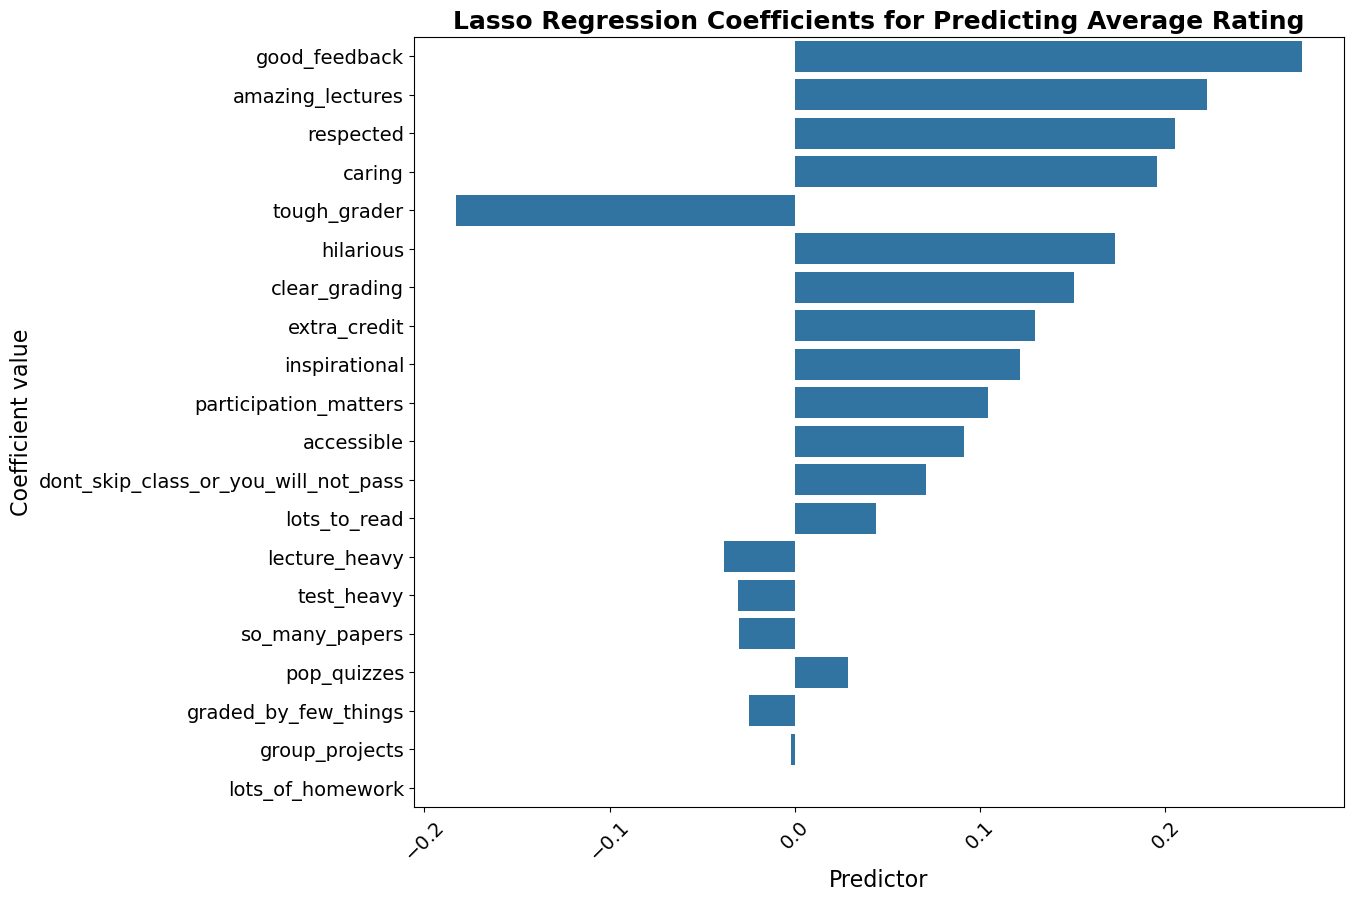

In [191]:
# plot weights of the multiple linear regression model 
# figure size 
plt.figure(figsize = (12, 10))

# bar plot 
sns.barplot(x=weights_df_8["weight"],
        y = weights_df_8["tag"])

# aesthetics
# title 
plt.title("Lasso Regression Coefficients for Predicting Average Rating", 
          fontweight="bold", 
          fontsize=18)

# axis labels
plt.xlabel("Predictor", fontsize=16)
plt.ylabel("Coefficient value", fontsize=16)

# ticks
plt.tick_params(axis="both", labelsize=14)
plt.xticks(rotation=45)

# show plot
plt.show()

We retain only predictors with an absolute standardized coefficient of at least 0.05. This cutoff removes variables whose estimated effects are close to zero after controlling for other tags, while keeping those with meaningful influence on predicted ratings.

Applying this threshold substantially reduces the feature set without discarding signal. Most excluded variables have coefficients near zero, indicating limited marginal contribution in the presence of stronger teaching quality and grading indicators.

We now refit the model using this reduced set of predictors and compare its performance to the full specification to assess whether parsimony is achieved without loss in predictive accuracy.

In [192]:
# reduce to only significant features (|weight| >= 0.07)
selected_features_8 = weights_df_8[weights_df_8["weight"].abs() >= 0.05]["tag"].tolist()

# reduce training and testing data
x_train_reduced_8 = x_train_8[selected_features_8]
x_test_reduced_8 = x_test_8[selected_features_8]

# cross-validation
# fixed CV
cv = KFold(n_splits = 5, 
           shuffle = True, 
           random_state = n_number)

# pipeline for Lasso regression with reduced features 
pipeline_q8_reduced = Pipeline([ 
    # scaler 
    ("scaler", StandardScaler()), 

    # model 
    ("LassoCV (reduced features)", LassoCV(
        cv = cv, 
        random_state = n_number, 
        alphas = 100, 
        max_iter = 10000))

])

# run cross_validation 
cv_results_raw_8_reduced = cross_validate(
    pipeline_q8_reduced, 
    x_train_reduced_8, 
    y_train_8, 
    cv = cv,
    n_jobs = -1, 
    scoring = ("r2", 
               "neg_root_mean_squared_error")
)

# save results 
cv_results_8_reduced = {
    "R2_mean": cv_results_raw_8_reduced["test_r2"].mean(),
    "RMSE_mean": (-cv_results_raw_8_reduced["test_neg_root_mean_squared_error"]).mean()
}

# append to comparison dataframe
compare_models_q8_df = pd.concat([
    compare_models_q8_df, 
    pd.DataFrame([{
        "model": "LassoCV (reduced variables)",
        "R2_mean": cv_results_8_reduced["R2_mean"],
        "RMSE_mean": cv_results_8_reduced["RMSE_mean"]
    }])
], ignore_index=True).sort_values(by="RMSE_mean").reset_index(drop=True)

# check results 
compare_models_q8_df

,model,R2_mean,RMSE_mean
0,LinearRegression,0.707867,0.499387
1,RidgeCV,0.707794,0.499451
2,LassoCV,0.707458,0.499734
3,ElasticNetCV,0.707454,0.499736
4,LassoCV (reduced variables),0.700520,0.505618


In [193]:
# LassoCV with reduced number variables on test data
print("LassoCV with 13 variables:\n")
score_model(pipeline_q8_reduced,
            x_train_reduced_8, 
            x_test_reduced_8, 
            y_train_8, 
            y_test_8)

LassoCV with 13 variables:



{'Training RMSE': 0.5049335771218008,
 'Training R2': 0.701551648794648,
 'Testing RMSE': 0.5110011741347643,
 'Testing R2': 0.7053268316940405}

In [194]:
# LassoCV on test data 
print("LassoCV with 20 variables:\n")
score_model(pipeline_q8,
            x_train_8, 
            x_test_8, 
            y_train_8, 
            y_test_8)

LassoCV with 20 variables:



{'Training RMSE': 0.4982272648019333,
 'Training R2': 0.709426729758896,
 'Testing RMSE': 0.50375740902208,
 'Testing R2': 0.7136219749260221}

The reduction is reasonable and consistent with the cross-validation results.

Under the same 5-fold cross-validation setup, LassoCV with all 20 variables achieves a mean R² of about 0.707 and an RMSE of roughly 0.499. After restricting the model to 13 variables based on coefficient magnitude, cross-validated R² drops to about 0.701 and RMSE increases to approximately 0.506. The difference is small but systematic across folds, indicating a real, though limited, loss of predictive signal.

Evaluation on the held-out test set mirrors this pattern. The full model attains a test R² of about 0.714 and RMSE near 0.504, while the reduced model reaches a test R² of roughly 0.705 with RMSE around 0.511. Training and testing metrics remain well aligned in both cases, suggesting stable generalization rather than overfitting.

Overall, cross-validation confirms the trade-off. Removing low-weight predictors slightly degrades performance, but the loss is modest. The reduced model remains competitive while offering improved parsimony and interpretability.

We now extend the specification by introducing interaction terms among the retained predictors to test whether non-additive relationships can recover the small performance gap observed after variable reduction.

### Extra: Interactions

In [195]:
# cv for interaction model
cv = KFold(n_splits=5, shuffle=True, random_state=n_number)

# pipeline for interactions model 
pipeline_q8_interactions = Pipeline([
    # polynomial features for interactions
    ("poly", PolynomialFeatures(
        degree=2,
        interaction_only=True,
        include_bias=False, 
    )),

    # scaler
    ("scaler", StandardScaler()),
    
    # model itself 
    ("model", LassoCV(
        cv=cv,
        random_state=n_number,
        alphas=100,
        max_iter=10000
    ))
])

# cross-validation with interactions
cv_results_raw_8_interactions = cross_validate(
    pipeline_q8_interactions,
    x_train_reduced_8,
    y_train_8,
    cv=cv,
    scoring=("r2", "neg_root_mean_squared_error"),
    return_train_score=False
)

# save results
cv_results_8_interactions = {
    "R2_mean": cv_results_raw_8_interactions["test_r2"].mean(),
    "RMSE_mean": (-cv_results_raw_8_interactions["test_neg_root_mean_squared_error"]).mean()
}

# add 
compare_models_q8_df = pd.concat([
    compare_models_q8_df, 
    pd.DataFrame([{
        "model": "LassoCV (interactions)",
        "R2_mean": cv_results_8_interactions["R2_mean"],
        "RMSE_mean": cv_results_8_interactions["RMSE_mean"]
    }])
], ignore_index=True).sort_values(by="RMSE_mean").reset_index(drop=True)

# check results 
compare_models_q8_df

,model,R2_mean,RMSE_mean
0,LassoCV (interactions),0.717432,0.491130
1,LinearRegression,0.707867,0.499387
2,RidgeCV,0.707794,0.499451
3,LassoCV,0.707458,0.499734
4,ElasticNetCV,0.707454,0.499736
5,LassoCV (reduced variables),0.700520,0.505618


In [196]:
# LassoCV with interactions on test data 
print("LassoCV with interactions:\n")
score_model(pipeline_q8_interactions,
            x_train_reduced_8, 
            x_test_reduced_8, 
            y_train_8, 
            y_test_8)

LassoCV with interactions:



{'Training RMSE': 0.48727670540989354,
 'Training R2': 0.7220594059550136,
 'Testing RMSE': 0.49837832707517826,
 'Testing R2': 0.7197051666794557}

In [197]:
# LassoCV with reduced number variables on test data
print("LassoCV with 13 variables:\n")
score_model(pipeline_q8_reduced,
            x_train_reduced_8, 
            x_test_reduced_8, 
            y_train_8, 
            y_test_8)

LassoCV with 13 variables:



{'Training RMSE': 0.5049335771218008,
 'Training R2': 0.701551648794648,
 'Testing RMSE': 0.5110011741347643,
 'Testing R2': 0.7053268316940405}

Lasso with interaction terms delivers a clear improvement over all linear baselines. Cross-validated RMSE drops from about 0.50 to 0.49, and R² increases from roughly 0.708 to 0.717. On the test set, RMSE decreases from 0.511 to 0.498 and R² rises from 0.714 to 0.720. This gap is no longer marginal. The improvement is consistent across cross-validation and hold-out data, and the train-test gap remains small, which suggests genuine signal rather than overfitting.

At the same time, this interaction model is not parsimonious. The current specification introduces all pairwise interactions among the 13 retained tags, which substantially increases model complexity. The gain in accuracy therefore comes at the cost of many additional terms, most of which may contribute little individually.

Because of this, the interaction result should be treated as an upper bound rather than a final specification. The next step is to inspect the interaction coefficients and remove weak interaction terms, keeping only those with meaningful weight > 0.05. The goal is to determine whether a smaller subset of interactions can retain most of the performance gain while restoring interpretability and parsimony.

In [198]:
# fit once on full training data
pipeline_q8_interactions.fit(x_train_reduced_8, y_train_8)

# get trained pieces
poly = pipeline_q8_interactions.named_steps["poly"]
model = pipeline_q8_interactions.named_steps["model"]

# feature names after interactions
feature_names = poly.get_feature_names_out(x_train_reduced_8.columns)

# coefficients
coef = model.coef_

# weights table
weights_df_8_interactions = pd.DataFrame({
    "tag": feature_names,
    "weight": coef
})

# sort by absolute weight
weights_df_8_interactions["abs_weight"] = weights_df_8_interactions["weight"].abs()
weights_df_8_interactions = (
    weights_df_8_interactions
      .sort_values("abs_weight", ascending=False)
      .drop(columns="abs_weight")
      .reset_index(drop=True)
)

# check only the most important ones
weights_df_8_interactions_view = weights_df_8_interactions.loc[
    weights_df_8_interactions["weight"].abs() >= 0.05
]

weights_df_8_interactions_view


,tag,weight
0,good_feedback,0.332617
1,amazing_lectures,0.320037
2,respected,0.260714
3,tough_grader,-0.228613
4,caring,0.226441
5,clear_grading,0.182601
6,hilarious,0.170710
7,inspirational,0.155756
8,extra_credit,0.099512
9,participation_matters,0.092025


In [199]:
# recreate interactions
# train data 
x_train_i = x_train_8.copy()
x_test_i = x_test_8.copy()

x_train_i["good_feedback respected"] = x_train_i["good_feedback"] * x_train_i["respected"]
x_train_i["amazing_lectures respected"] = x_train_i["amazing_lectures"] * x_train_i["respected"]

# test data 
x_test_i["good_feedback respected"] = x_test_i["good_feedback"] * x_test_i["respected"]
x_test_i["amazing_lectures respected"] = x_test_i["amazing_lectures"] * x_test_i["respected"]

# filter train and test data for the variables needed 
keep_cols = weights_df_8_interactions_view["tag"].tolist()

x_train_reduced_interactions_8 = x_train_i[keep_cols]
x_test_reduced_interactions_8 = x_test_i[keep_cols]

# cv for reduced interaction model
cv = KFold(n_splits=5, shuffle=True, random_state=n_number)

# pipeline for reduced interactions model 
pipeline_q8_reduced_interactions = Pipeline([
    # scaler
    ("scaler", StandardScaler()),
    
    # model itself 
    ("model", LassoCV(
        cv=cv,
        random_state=n_number,
        alphas=100,
        max_iter=10000
    ))
])

# cross-validation with reduced interactions
cv_results_raw_8_reduced_interactions = cross_validate(
    pipeline_q8_reduced_interactions,
    x_train_reduced_interactions_8,
    y_train_8,
    cv=cv,
    scoring=("r2", "neg_root_mean_squared_error"),
    return_train_score=False
)

# save results
cv_results_8_reduced_interactions = {
    "R2_mean": cv_results_raw_8_reduced_interactions["test_r2"].mean(),
    "RMSE_mean": (-cv_results_raw_8_reduced_interactions["test_neg_root_mean_squared_error"]).mean()
}

# add 
compare_models_q8_df = pd.concat([
    compare_models_q8_df, 
    pd.DataFrame([{
        "model": "LassoCV (reduced interactions)",
        "R2_mean": cv_results_8_reduced_interactions["R2_mean"],
        "RMSE_mean": cv_results_8_reduced_interactions["RMSE_mean"]
    }])
], ignore_index=True).sort_values(by="RMSE_mean").reset_index(drop=True)

# check results 
compare_models_q8_df


,model,R2_mean,RMSE_mean
0,LassoCV (interactions),0.717432,0.491130
1,LinearRegression,0.707867,0.499387
2,RidgeCV,0.707794,0.499451
3,LassoCV,0.707458,0.499734
4,ElasticNetCV,0.707454,0.499736
5,LassoCV (reduced interactions),0.701141,0.505108
6,LassoCV (reduced variables),0.700520,0.505618


In [200]:
# LassoCV with interactions on test data 
print("LassoCV with reduced interactions:\n")
score_model(pipeline_q8_reduced_interactions,
            x_train_reduced_interactions_8, 
            x_test_reduced_interactions_8, 
            y_train_8, 
            y_test_8)

LassoCV with reduced interactions:



{'Training RMSE': 0.504477066738796,
 'Training R2': 0.7020910590768956,
 'Testing RMSE': 0.5089678229596092,
 'Testing R2': 0.7076672644020363}

In [201]:
# LassoCV with 13 variables 
print("LassoCV with 13 variables:\n")
score_model(pipeline_q8_reduced,
            x_train_reduced_8, 
            x_test_reduced_8, 
            y_train_8, 
            y_test_8)

LassoCV with 13 variables:



{'Training RMSE': 0.5049335771218008,
 'Training R2': 0.701551648794648,
 'Testing RMSE': 0.5110011741347643,
 'Testing R2': 0.7053268316940405}

The full interaction Lasso delivers the best performance. Cross-validated RMSE drops from about 0.499 to 0.491, while R² increases from roughly 0.708 to 0.717. On the test set, RMSE improves from about 0.504 to 0.498 and R² rises from around 0.714 to 0.720. This is a real gain, around 1.5 to 2 percent in RMSE, which is meaningful in this setting.

The reduced interaction model does not perform well. Once interactions are restricted to only a small subset, performance deteriorates. Cross-validated RMSE increases to about 0.505 and test RMSE to about 0.509. This pushes the model back toward the reduced main-effects level.

The comparison with the 13-variable model confirms this. Both models perform almost identically, which suggests that manually pruning interactions removes useful signal rather than improving generalization. Regularization already controls complexity, so extra pruning is unnecessary here.

The takeaway is clean.

Main effects explain most of the variance.
Interactions add signal, but only when included broadly.
Hand-picking a few interactions is too restrictive.
Lasso regularization already keeps the model from blowing up.

If interpretability is the goal, the 13-variable Lasso without interactions remains the preferred model. If prediction accuracy is the goal within a linear framework, the full interaction Lasso is the best choice and earns its added complexity.

Next, we shift the focus fully to prediction accuracy. We test non-linear boosting models, LightGBM and XGBoost, using the same cross-validation metrics, RMSE and R². This mirrors the Q7 workflow and checks whether tree-based models extract additional structure without manual feature engineering.

### Extra: Prediction Accuracy Optimization

#### LightGBM

In [203]:
# fixed cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=n_number)

# pipeline for LightGBM
lgbm_pipe_q8 = Pipeline([
    # scaler
    ("scaler", StandardScaler()), 

    # model 
    ("model", LGBMRegressor(
        objective="regression",
        metric="rmse",
        random_state=n_number,
        n_jobs=1,
        verbosity=-1
    ))
])

# optuna objective
def objective_lgbm(trial):
    params = {
        # core tree shape
        "model__num_leaves": trial.suggest_int("model__num_leaves", 15, 255),
        "model__max_depth": trial.suggest_int("model__max_depth", -1, 16),
        "model__min_child_samples": trial.suggest_int("model__min_child_samples", 5, 200),

        # learning
        "model__n_estimators": trial.suggest_int("model__n_estimators", 300, 3000),
        "model__learning_rate": trial.suggest_float("model__learning_rate", 0.005, 0.2, log=True),

        # subsampling
        "model__subsample": trial.suggest_float("model__subsample", 0.6, 1.0),
        "model__subsample_freq": trial.suggest_int("model__subsample_freq", 0, 10),
        "model__colsample_bytree": trial.suggest_float("model__colsample_bytree", 0.6, 1.0),

        # regularization
        "model__reg_alpha": trial.suggest_float("model__reg_alpha", 1e-8, 10.0, log=True),
        "model__reg_lambda": trial.suggest_float("model__reg_lambda", 1e-8, 10.0, log=True),

        # split control
        "model__min_split_gain": trial.suggest_float("model__min_split_gain", 0.0, 0.5),
    }

    # clone parameters and model pipeline
    pipe = clone(lgbm_pipe_q8)
    pipe.set_params(**params)

    # cross-validation
    scores = cross_val_score(
        pipe,
        x_train_8,
        y_train_8,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1
    )

    return -scores.mean()

# start optuna study 
study_lgbm = start_study_optuna(
    objective=objective_lgbm,
    n_trials=50,
    sampler_seed=n_number,
    direction="minimize"
)




[I 2026-01-18 18:26:59,799] A new study created in memory with name: no-name-f0655e33-705c-475f-98d0-dd1131dd921c
[I 2026-01-18 18:27:04,013] Trial 0 finished with value: 0.47560645217636566 and parameters: {'model__num_leaves': 77, 'model__max_depth': 5, 'model__min_child_samples': 107, 'model__n_estimators': 819, 'model__learning_rate': 0.0187723140292542, 'model__subsample': 0.7445336836373633, 'model__subsample_freq': 1, 'model__colsample_bytree': 0.7213948926440281, 'model__reg_alpha': 0.06280715236841564, 'model__reg_lambda': 0.008346099527215496, 'model__min_split_gain': 0.10123579979867697}. Best is trial 0 with value: 0.47560645217636566.
[I 2026-01-18 18:27:10,166] Trial 1 finished with value: 0.4765045017437419 and parameters: {'model__num_leaves': 168, 'model__max_depth': 16, 'model__min_child_samples': 61, 'model__n_estimators': 2642, 'model__learning_rate': 0.010515474453343615, 'model__subsample': 0.6286895037328117, 'model__subsample_freq': 6, 'model__colsample_bytree':

Best Params: {'model__num_leaves': 234, 'model__max_depth': 11, 'model__min_child_samples': 40, 'model__n_estimators': 1415, 'model__learning_rate': 0.005988624561994345, 'model__subsample': 0.6754722760446807, 'model__subsample_freq': 9, 'model__colsample_bytree': 0.6491043199553179, 'model__reg_alpha': 3.5313794619542234e-06, 'model__reg_lambda': 2.6827269512574077, 'model__min_split_gain': 0.26630378425107254}


In [204]:
# cross-validate the model with best parameters
# set the best parameters to the pipeline
lgbm_pipe_q8.set_params(**study_lgbm.best_params)

cv_results_raw_lgbm_q8 = cross_validate(
    lgbm_pipe_q8,
    x_train_8,
    y_train_8,
    cv=cv,
    scoring=("r2", "neg_root_mean_squared_error"),
    return_train_score=False, 
    return_estimator = True
)

# results
cv_results_lgbm_q8 = {
    "R2_mean": cv_results_raw_lgbm_q8["test_r2"].mean(),
    "RMSE_mean": (-cv_results_raw_lgbm_q8["test_neg_root_mean_squared_error"]).mean()
}

# append to comparison dataframe
compare_models_q8_df = pd.concat([
    compare_models_q8_df, 
    pd.DataFrame([{
        "model": "LightGBM (tuned)",
        "R2_mean": cv_results_lgbm_q8["R2_mean"],
        "RMSE_mean": cv_results_lgbm_q8["RMSE_mean"]
    }])
], ignore_index=True).sort_values(by="RMSE_mean").reset_index(drop=True)

c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [205]:
# evaluate our baseline model 
# against lgbm model 
print("LightGBM model performance:\n")
score_model(
    lgbm_pipe_q8,
    x_train_8,
    x_test_8,
    y_train_8,
    y_test_8
)

LightGBM model performance:



c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


{'Training RMSE': 0.39550889601149036,
 'Training R2': 0.8168895230644453,
 'Testing RMSE': 0.47499090099766234,
 'Testing R2': 0.7453947367878017}

In [206]:
# evaluate our baseline model (knn imputer + linear regression with the most important features)
# against lgbm model 
print("Interactions model performance:\n")
score_model(
    pipeline_q8_interactions,
    x_train_reduced_8,
    x_test_reduced_8,
    y_train_8,
    y_test_8
)

Interactions model performance:



{'Training RMSE': 0.48727670540989354,
 'Training R2': 0.7220594059550136,
 'Testing RMSE': 0.49837832707517826,
 'Testing R2': 0.7197051666794557}

In [207]:
# check CV results 
compare_models_q8_df

,model,R2_mean,RMSE_mean
0,LightGBM (tuned),0.736447,0.474296
1,LassoCV (interactions),0.717432,0.491130
2,LinearRegression,0.707867,0.499387
3,RidgeCV,0.707794,0.499451
4,LassoCV,0.707458,0.499734
5,ElasticNetCV,0.707454,0.499736
6,LassoCV (reduced interactions),0.701141,0.505108
7,LassoCV (reduced variables),0.700520,0.505618


On cross-validation, LightGBM achieves an RMSE of about 0.474 and an R² of 0.736. The best linear alternative, Lasso with interactions, reaches an RMSE of about 0.491 and an R² of 0.717. This is not marginal. The RMSE reduction is roughly 0.017, around a 3-4 percent improvement, which is meaningful at this scale.

The hold-out results confirm the same pattern. Test RMSE drops from about 0.498 to 0.475, and test R² increases from roughly 0.720 to 0.745. The gain is consistent across training, cross-validation, and testing. This is real signal extraction rather than noise.

Linear models cluster tightly around RMSE ≈ 0.50. Adding interactions improves performance modestly. LightGBM goes further by capturing non-linear structure that linear models cannot represent, even with interaction terms and regularization.

At this point, LightGBM offers the best accuracy-complexity tradeoff observed so far. The improvement is larger than any gain achieved through feature pruning or interaction engineering within the linear framework.

Before concluding, we will evaluate XGBoost under the same setup to check whether a different boosting implementation can extract additional signal beyond LightGBM.

#### XGBoost 

In [208]:
# fixed cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=n_number)

# pipeline for XGBoost
xgb_pipe_q8 = Pipeline([
    # scaler
    ("scaler", StandardScaler()),

    # model
    ("model", XGBRegressor(
        objective="reg:squarederror",
        eval_metric="rmse",
        tree_method="hist",
        random_state=n_number,
        n_jobs=1,
        verbosity=0
    ))
])

# optuna objective
def objective_xgb(trial):
    params = {
        # core tree shape
        "model__max_depth": trial.suggest_int("model__max_depth", 2, 12),
        "model__min_child_weight": trial.suggest_float("model__min_child_weight", 1e-2, 50.0, log=True),

        # learning
        "model__n_estimators": trial.suggest_int("model__n_estimators", 300, 3000),
        "model__learning_rate": trial.suggest_float("model__learning_rate", 0.005, 0.2, log=True),

        # subsampling
        "model__subsample": trial.suggest_float("model__subsample", 0.6, 1.0),
        "model__colsample_bytree": trial.suggest_float("model__colsample_bytree", 0.6, 1.0),

        # regularization
        "model__reg_alpha": trial.suggest_float("model__reg_alpha", 1e-8, 10.0, log=True),
        "model__reg_lambda": trial.suggest_float("model__reg_lambda", 1e-8, 10.0, log=True),

        # split control
        "model__gamma": trial.suggest_float("model__gamma", 0.0, 0.5),

        # extra capacity control
        "model__max_delta_step": trial.suggest_int("model__max_delta_step", 0, 10),
    }

    # clone parameters and model pipeline
    pipe = clone(xgb_pipe_q8)
    pipe.set_params(**params)

    # cross-validation
    scores = cross_val_score(
        pipe,
        x_train_8,
        y_train_8,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1
    )

    return -scores.mean()

# start optuna study
study_xgb = start_study_optuna(
    objective=objective_xgb,
    n_trials=50,
    sampler_seed=n_number,
    direction="minimize"
)


[I 2026-01-18 18:33:51,104] A new study created in memory with name: no-name-eb0cbfd9-fce5-4b9d-808a-d40e2a7f2fb6
[I 2026-01-18 18:33:52,983] Trial 0 finished with value: 0.4778291726580631 and parameters: {'model__max_depth': 4, 'model__min_child_weight': 0.17689663027883612, 'model__n_estimators': 1709, 'model__learning_rate': 0.010162654352368208, 'model__subsample': 0.7434522575663386, 'model__colsample_bytree': 0.7445336836373633, 'model__reg_alpha': 8.280449747344628e-08, 'model__reg_lambda': 5.3874727250769205e-06, 'model__gamma': 0.3776671724026525, 'model__max_delta_step': 7}. Best is trial 0 with value: 0.4778291726580631.
[I 2026-01-18 18:33:55,997] Trial 1 finished with value: 0.48144083029150553 and parameters: {'model__max_depth': 4, 'model__min_child_weight': 2.2755784987429224, 'model__n_estimators': 2888, 'model__learning_rate': 0.014357845660171998, 'model__subsample': 0.9468649720171275, 'model__colsample_bytree': 0.6806109309369683, 'model__reg_alpha': 4.42093199059

Best Params: {'model__max_depth': 11, 'model__min_child_weight': 39.14646272937078, 'model__n_estimators': 593, 'model__learning_rate': 0.00938056282279371, 'model__subsample': 0.6398621058691094, 'model__colsample_bytree': 0.6972525777604038, 'model__reg_alpha': 8.027099280343022e-08, 'model__reg_lambda': 0.33555238306532664, 'model__gamma': 0.3496986221306756, 'model__max_delta_step': 0}


In [213]:
# cross-validate the model with best parameters
# set the best parameters to the pipeline
xgb_pipe_q8.set_params(**study_xgb.best_params)

cv_results_raw_xgb_q8 = cross_validate(
    xgb_pipe_q8,
    x_train_8,
    y_train_8,
    cv=cv,
    scoring=("r2", "neg_root_mean_squared_error"),
    return_train_score=False, 
    return_estimator = True
)

# results
cv_results_xgb_q8 = {
    "R2_mean": cv_results_raw_xgb_q8["test_r2"].mean(),
    "RMSE_mean": (-cv_results_raw_xgb_q8["test_neg_root_mean_squared_error"]).mean()
}

# append to comparison dataframe
compare_models_q8_df = pd.concat([
    compare_models_q8_df, 
    pd.DataFrame([{
        "model": "XGBoost (tuned)",
        "R2_mean": cv_results_xgb_q8["R2_mean"],
        "RMSE_mean": cv_results_xgb_q8["RMSE_mean"]
    }])
], ignore_index=True).sort_values(by="RMSE_mean").reset_index(drop=True)

In [214]:
# evaluate tuned XGBoost pipeline
print("XGBoost (tuned) model performance:\n")
score_model(
    xgb_pipe_q8,
    x_train_8,
    x_test_8,
    y_train_8,
    y_test_8
)


XGBoost (tuned) model performance:



{'Training RMSE': 0.39554370658159865,
 'Training R2': 0.8168572888433202,
 'Testing RMSE': 0.47481262361693977,
 'Testing R2': 0.7455858218852724}

In [215]:
print("LightGBM (tuned) model performance:\n")
score_model(
    lgbm_pipe_q8,
    x_train_8,
    x_test_8,
    y_train_8,
    y_test_8
)

LightGBM (tuned) model performance:



c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


{'Training RMSE': 0.39550889601149036,
 'Training R2': 0.8168895230644453,
 'Testing RMSE': 0.47499090099766234,
 'Testing R2': 0.7453947367878017}

In [220]:
compare_models_q8_df

,model,R2_mean,RMSE_mean
0,XGBoost (tuned),0.736882,0.473906
1,LightGBM (tuned),0.736447,0.474296
2,LassoCV (interactions),0.717432,0.491130
3,LinearRegression,0.707867,0.499387
4,RidgeCV,0.707794,0.499451
5,LassoCV,0.707458,0.499734
6,ElasticNetCV,0.707454,0.499736
7,LassoCV (reduced interactions),0.701141,0.505108
8,LassoCV (reduced variables),0.700520,0.505618


Final conclusion.

Two distinct modeling objectives guide the final choice.

`Interpretability and parsimony.`
Within the linear family, the **reduced Lasso model with 13 variables** is the preferred specification. Cross-validation shows that removing weak predictors slightly lowers predictive accuracy, but the loss is modest and controlled. The reduced model remains competitive while being substantially easier to interpret. Coefficients correspond to clear teaching-quality signals rather than noise, and the model avoids unnecessary complexity. This specification provides a clean, transparent summary of the main drivers of ratings. When explanation, communication, or policy relevance matters, the 13-variable reduced Lasso is the correct final model.

`Predictive performance.`
When the objective shifts from interpretability to accuracy, linear models reach their ceiling. Interaction-augmented Lasso improves performance, but the largest gains come from non-linear methods. LightGBM delivers a clear improvement, reducing cross-validated RMSE from about 0.50 to about 0.47 and increasing R² from roughly 0.71 to about 0.74. This improvement is consistent across folds and the hold-out set.

XGBoost was evaluated as a further step. Its performance is effectively identical to LightGBM, with differences well below practical relevance. Given that LightGBM trains faster, is easier to tune, and achieves the same accuracy, it is selected as the final high-performance model. There is no justification for preferring XGBoost in this setting.

Final model choices.

- `Interpretability first:` reduced Lasso with 13 variables.

- `Accuracy first:` tuned LightGBM.

These two models represent the best solutions under different priorities. Linear structure explains most of the variation in ratings, but non-linear boosting extracts additional signal when prediction accuracy is the sole objective.


## Q9. Build a regression model predicting average difficulty from all tags (the ones in the rmpCapstoneTags.csv) file. Make sure to include the R2 and RMSE of this model. Which of these tags is most strongly predictive of average difficulty? 

### Linear Regression

In [26]:
# first, make a subset of all variables that are needed. 
df_9 = df_filtered_final[["average_difficulty"] + df_tags_column_names].copy()

# check 
df_9.info()



<class 'pandas.core.frame.DataFrame'>
Index: 18422 entries, 5 to 89890
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   average_difficulty                    18422 non-null  float64
 1   tough_grader                          18422 non-null  float64
 2   good_feedback                         18422 non-null  float64
 3   respected                             18422 non-null  float64
 4   lots_to_read                          18422 non-null  float64
 5   participation_matters                 18422 non-null  float64
 6   dont_skip_class_or_you_will_not_pass  18422 non-null  float64
 7   lots_of_homework                      18422 non-null  float64
 8   inspirational                         18422 non-null  float64
 9   pop_quizzes                           18422 non-null  float64
 10  accessible                            18422 non-null  float64
 11  so_many_papers      

In [27]:
# separate y (dependent variable) and x(independent variables)
y = df_9["average_difficulty"]
x = df_9.drop(columns = "average_difficulty")

# check 
x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18422 entries, 5 to 89890
Data columns (total 20 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   tough_grader                          18422 non-null  float64
 1   good_feedback                         18422 non-null  float64
 2   respected                             18422 non-null  float64
 3   lots_to_read                          18422 non-null  float64
 4   participation_matters                 18422 non-null  float64
 5   dont_skip_class_or_you_will_not_pass  18422 non-null  float64
 6   lots_of_homework                      18422 non-null  float64
 7   inspirational                         18422 non-null  float64
 8   pop_quizzes                           18422 non-null  float64
 9   accessible                            18422 non-null  float64
 10  so_many_papers                        18422 non-null  float64
 11  clear_grading       

In [28]:
# split the data
x_train_q9, x_test_q9, y_train_q9, y_test_q9 = train_test_split(x, y, test_size=0.2, random_state=n_number)

# check distributions of the data 
print(f'Number of rows for train data:{y_train_q9.shape[0]}\n')
print(f'Number of rows for test data:{y_test_q9.shape[0]}\n')

Number of rows for train data:14737

Number of rows for test data:3685



Quite good amount of rows both in training and test data, we can proceed with the analysis. 

In [29]:
# correlations between y and x predictors 
# based on training data
corr_yx_q9= x_train_q9.corrwith(y_train_q9, 
                            method = 'pearson').sort_values(ascending= False)
# check 
corr_yx_q9

tough_grader                            0.656348
dont_skip_class_or_you_will_not_pass    0.288862
lots_of_homework                        0.270708
lots_to_read                            0.249985
test_heavy                              0.243723
lecture_heavy                           0.177278
so_many_papers                          0.147911
pop_quizzes                             0.107886
accessible                              0.013982
graded_by_few_things                   -0.004150
group_projects                         -0.018438
participation_matters                  -0.091428
extra_credit                           -0.178687
amazing_lectures                       -0.208105
good_feedback                          -0.247711
clear_grading                          -0.268268
inspirational                          -0.271053
hilarious                              -0.283272
respected                              -0.339784
caring                                 -0.349328
dtype: float64

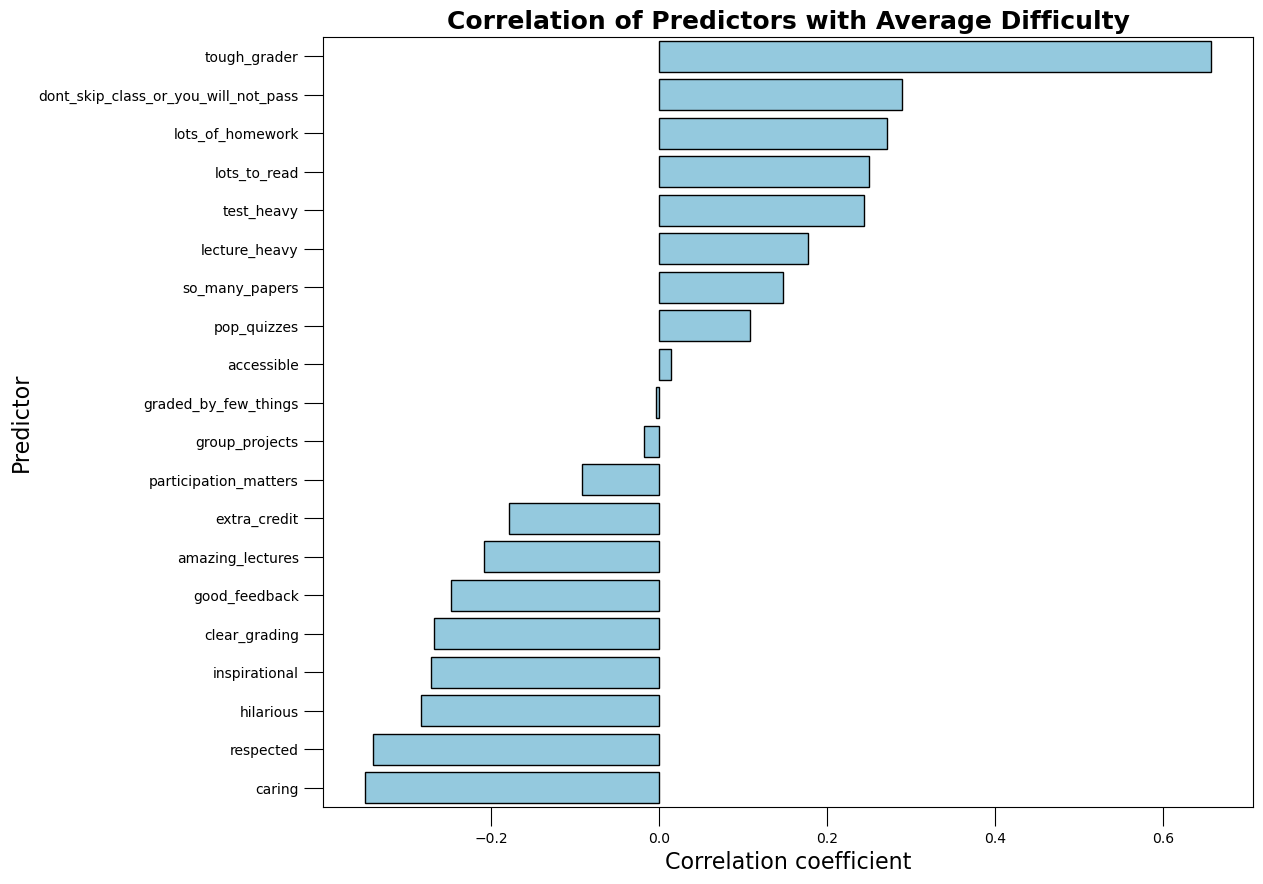

In [30]:
# plot correlation of y and x 
plt.figure(figsize= (12, 10))

# plot itself 
sns.barplot(corr_yx_q9, 
            orient= 'h', 
            color = 'skyblue', 
            edgecolor = 'black')

# title 
plt.title("Correlation of Predictors with Average Difficulty", 
          fontsize = 18, 
          fontweight = "bold")

# xlabel
plt.xlabel("Correlation coefficient", 
           fontsize = 16)
# ylabel 
plt.ylabel("Predictor", 
           fontsize = 16)
# ticks 
plt.tick_params(size = 14)

These correlations describe how students associate course characteristics with perceived difficulty.

Difficulty is driven primarily by grading strictness and workload.
The strongest positive correlation is tough grader (0.66). This dominates all other predictors and clearly anchors students’ notion of difficulty. Additional workload signals reinforce this perception. Don’t skip class or you will not pass (0.29), lots of homework (0.27), lots to read (0.25), test heavy (0.24), and lecture heavy (0.18) all move in the same direction. These tags describe time pressure, assessment intensity, and rigid structure, which students consistently interpret as higher difficulty.

Administrative and minor course features matter little.
Tags such as accessible (0.01), graded by few things (-0.00), and group projects (-0.02) show near-zero correlation. They do not meaningfully influence perceived difficulty.

Teaching quality works in the opposite direction.
All strong negative correlations reflect instructor quality and classroom experience. Caring (-0.35), respected (-0.34), hilarious (-0.28), inspirational (-0.27), clear grading (-0.27), good feedback (-0.25), and amazing lectures (-0.21) are associated with lower perceived difficulty. Students interpret clarity, support, and engagement as making courses feel easier, even when content may still be demanding.

In [31]:
# correlation matrix among tags
corr_xx_q9 = x_train_q9.corr()

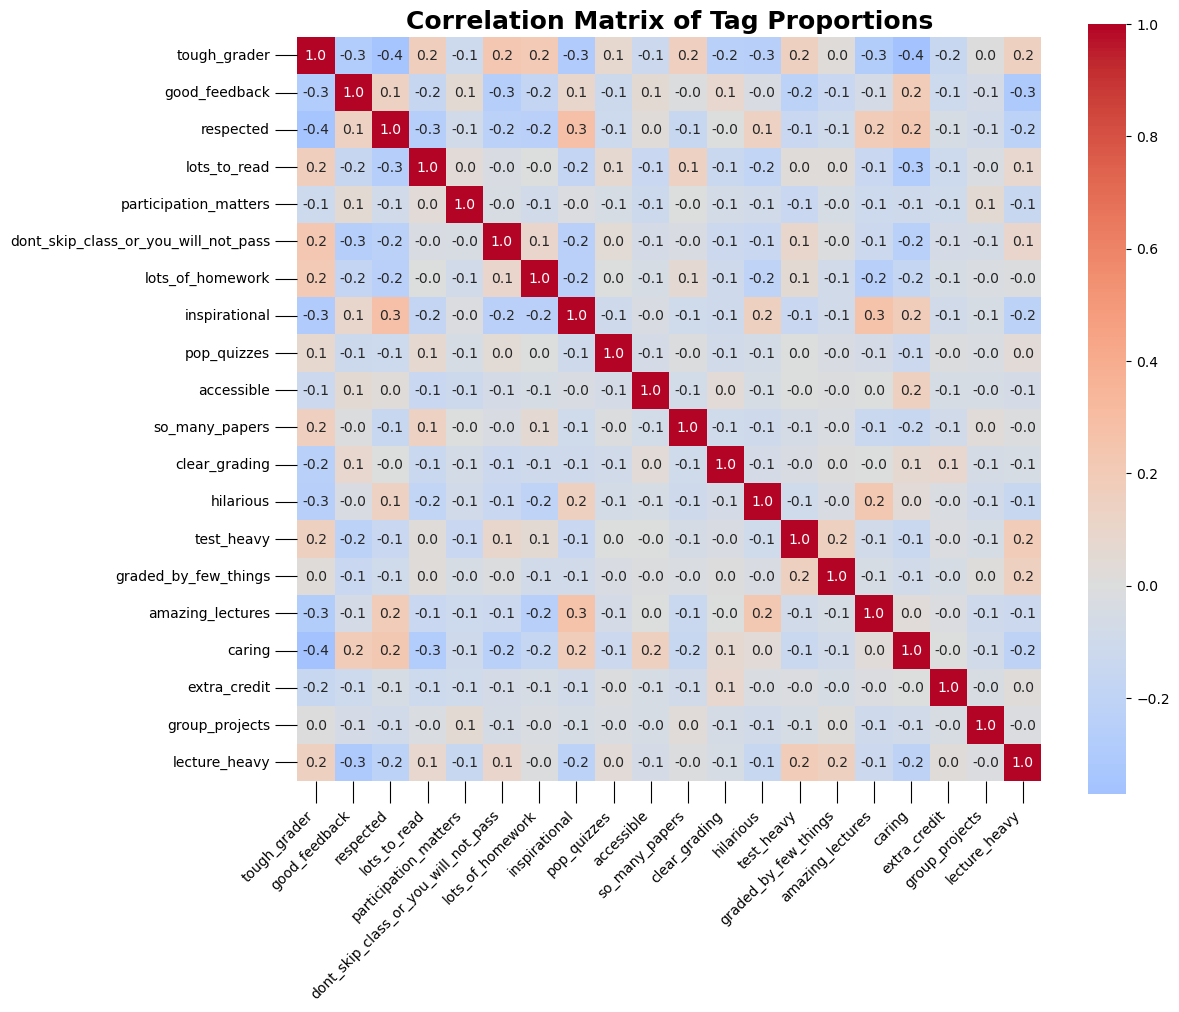

In [32]:
# plot correlation between predictors 
plt.figure(figsize= (12, 10))

# plot itself
sns.heatmap(
    corr_xx_q9,
    cmap="coolwarm",
    center=0,
    square=True,
    cbar=True,
    annot=True,
    fmt=".1f"
)

# title 
plt.title("Correlation Matrix of Tag Proportions", 
          fontweight = 'bold', 
          fontsize = 18)

# tickts 
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tick_params(size = 16)

plt.show()

This correlation matrix confirms the absence of multicollinearity among the tag proportions.

All pairwise correlations remain well below 0.7. Most values lie between -0.4 and 0.4, with no tightly coupled clusters. Even conceptually related tags, such as caring, respected, amazing lectures, and inspirational, show only moderate correlations. Workload-related tags also move together weakly rather than forming a single block.

This means the tags capture distinct dimensions of course experience rather than redundant information. As a result, linear models do not suffer from coefficient instability driven by multicollinearity, and regularization is not required for numerical reasons.

This supports the modeling choices in Q9. We can interpret coefficients directly and attribute effects to individual tags with confidence, without concern that strong correlations are distorting estimates.

We therefore fit and compare three linear specifications: ordinary least squares, Ridge, Lasso, and ElasticNet using the same cross-validation setup.

The purpose here is not to resolve multicollinearity, since the correlation analysis shows no problematic dependence among predictors, but to verify whether regularization improves stability or predictive performance. Ordinary least squares serves as the baseline. Ridge tests whether mild shrinkage improves generalization when predictors are moderately correlated. Lasso tests whether automatic feature selection yields a more parsimonious model without sacrificing accuracy.

Comparing these three models allows us to confirm whether regularization provides any practical benefit in this setting and to justify the final linear specification on empirical grounds rather than assumption.

In [34]:
# fixed CV
cv = KFold(n_splits=5, shuffle=True, random_state=n_number)

# pipelines for linear model comparison (no imputation)
pipelines_linear_q9 = {
    "LinearRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),

    "RidgeCV": Pipeline([
        ("scaler", StandardScaler()),
        ("model", RidgeCV(
            alphas=np.logspace(-4, 4, 50),
            cv=cv
        ))
    ]),

    "LassoCV": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LassoCV(
            alphas=100,
            cv=cv,
            random_state=n_number,
            max_iter=10000
        ))
    ]),

    "ElasticNetCV": Pipeline([
        ("scaler", StandardScaler()),
        ("model", ElasticNetCV(
            l1_ratio=[0.1, 0.5, 0.9],
            alphas=100,
            cv=cv,
            random_state=n_number,
            max_iter=10000
        ))
    ])
}

# compare models
rows = []
for name, pipe in pipelines_linear_q9.items():
    results = cross_validate(
        pipe,
        x_train_q9,
        y_train_q9,
        cv=cv,
        scoring=("r2", "neg_root_mean_squared_error"),
        n_jobs=-1,
        return_train_score=False
    )

    rows.append({
        "model": name,
        "R2_mean": results["test_r2"].mean(),
        "RMSE_mean": (-results["test_neg_root_mean_squared_error"]).mean()
    })

compare_models_q9_df = (
    pd.DataFrame(rows)
      .sort_values("RMSE_mean", ascending=True)
      .reset_index(drop=True)
)

# check results 
compare_models_q9_df

,model,R2_mean,RMSE_mean
0,LinearRegression,0.550526,0.540656
1,ElasticNetCV,0.550509,0.540673
2,LassoCV,0.550499,0.540679
3,RidgeCV,0.550294,0.540797


In [35]:
# check models on test data
for name, pipe in pipelines_linear_q9.items():
    print(f"\nModel: {name}")
    print(score_model(
        pipe,
        x_train_q9,
        x_test_q9,
        y_train_q9,
        y_test_q9
    ))


Model: LinearRegression
{'Training RMSE': 0.5393303456368387, 'Training R2': 0.5528540217842544, 'Testing RMSE': 0.5413209790590664, 'Testing R2': 0.5472489239116027}

Model: RidgeCV
{'Training RMSE': 0.5394170440708603, 'Training R2': 0.5527102510050688, 'Testing RMSE': 0.5409324647369647, 'Testing R2': 0.5478985833966541}

Model: LassoCV
{'Training RMSE': 0.5394458846539484, 'Training R2': 0.5526624199542269, 'Testing RMSE': 0.5409324377512, 'Testing R2': 0.5478986285050655}

Model: ElasticNetCV
{'Training RMSE': 0.5395375221190879, 'Training R2': 0.5525104256027569, 'Testing RMSE': 0.540793927305372, 'Testing R2': 0.5481301278231343}


All four linear models perform almost identically. Cross-validated RMSE differs by less than 0.001, and test-set RMSE and R² are essentially the same across specifications. These differences are far below any practical significance threshold.

Given this, model choice should be driven by structure and interpretability rather than marginal performance.

Lasso is preferred for three reasons.

First, it delivers comparable predictive accuracy to OLS, Ridge, and Elastic Net. There is no meaningful loss in fit.

Second, it enforces sparsity. Coefficients for weak or redundant tags are shrunk exactly to zero, yielding a simpler model that is easier to explain and reason about.

Third, it aligns with the goal of identifying the most influential teaching attributes rather than stabilizing all coefficients. Ridge and Elastic Net improve numerical stability, but earlier analysis showed no serious multicollinearity. That benefit is therefore unnecessary here.

For these reasons, we proceed with the Lasso model as the final linear specification in Q9. The choice reflects a deliberate preference for parsimony and interpretability, not a tradeoff in predictive performance.

#### Lasso Regression

In [36]:
# fixed CV 
cv = KFold(n_splits=5, shuffle=True, random_state=n_number)

# pipeline for Lasso Regression model 
pipeline_q9 = Pipeline([
    # scaler 
    ("scaler", StandardScaler()), 

    # model 
    ("model", LassoCV(
        cv=cv,
        random_state=n_number,
        alphas=100,
        max_iter=10000
    ))
])

# fit 
pipeline_q9.fit(x_train_q9, 
                y_train_q9)

# extract feature weights from the model
model_q9 = pipeline_q9.named_steps["model"]

# feature names
feature_names_q9 = x_train_q9.columns.to_list()
# coefficients
coef_q9 = model_q9.coef_

# build dataframe
weights_df_q9 = pd.DataFrame({
    "tag": feature_names_q9,
    "weight": coef_q9
})

# sort by absolute weight
weights_df_q9["abs_weight"] = weights_df_q9["weight"].abs()
weights_df_q9 = weights_df_q9.sort_values("abs_weight", ascending=False)

# cleanup
weights_df_q9 = weights_df_q9.drop(columns="abs_weight").reset_index(drop=True)
# check 
weights_df_q9

,tag,weight
0,tough_grader,0.292539
1,clear_grading,-0.143320
2,hilarious,-0.137110
3,caring,-0.126269
4,extra_credit,-0.116804
5,respected,-0.101465
6,participation_matters,-0.085235
7,good_feedback,-0.081337
8,inspirational,-0.067888
9,test_heavy,0.067648


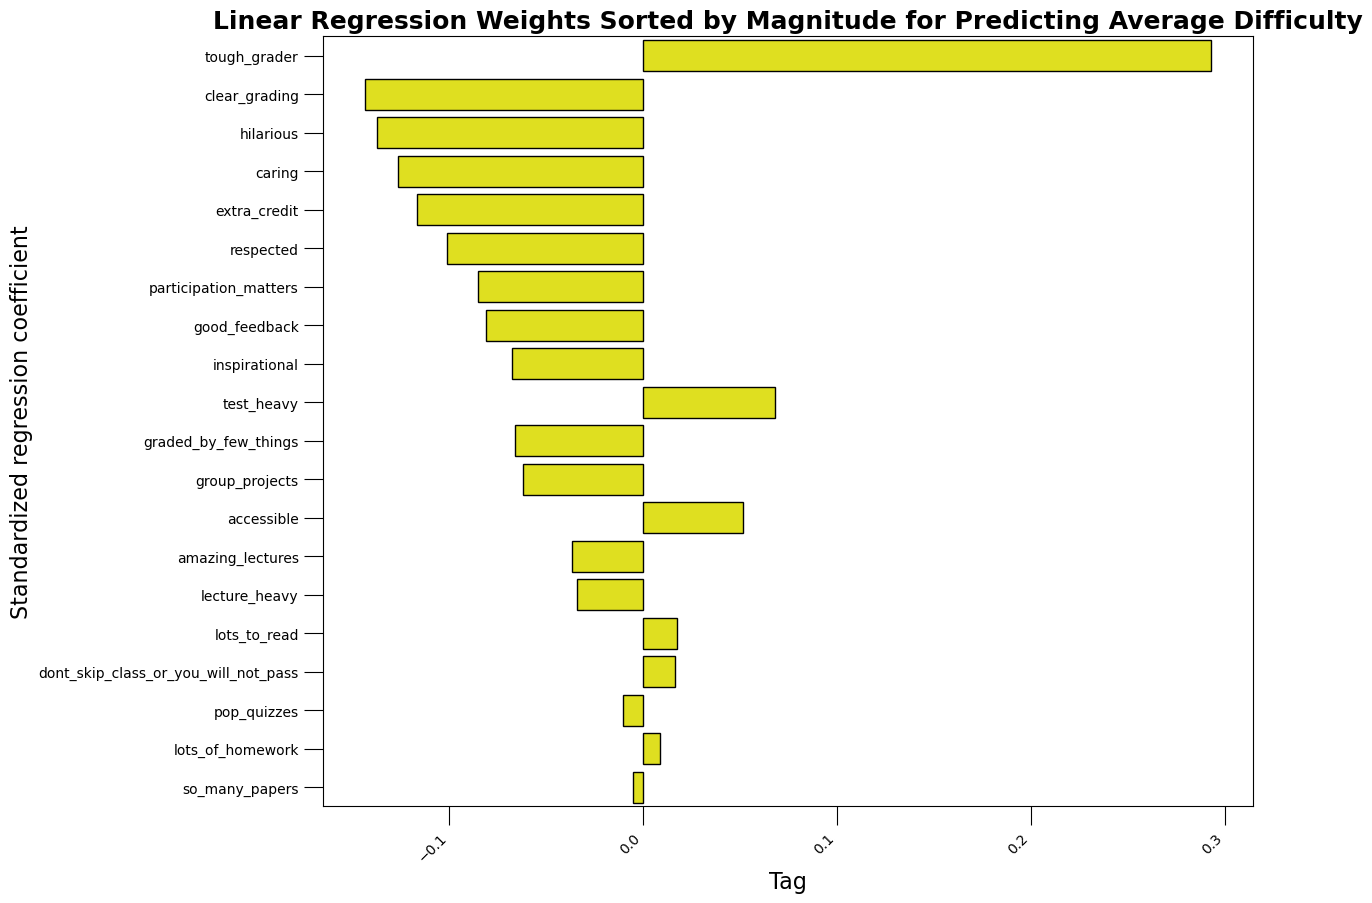

In [37]:
# Plot weights (coefficients)
# figure size 
plt.figure(figsize=(12, 10))

# plot itself 
sns.barplot(
    data=weights_df_q9,
    x="weight",
    y="tag",
    color="yellow",
    edgecolor="black", 
    orient= "h"
)

# title 
plt.title("Linear Regression Weights Sorted by Magnitude for Predicting Average Difficulty", 
          fontsize = 18, 
          fontweight = "bold")

# xlabel 
plt.xlabel("Tag", fontsize = 16)
# ylabel
plt.ylabel("Standardized regression coefficient", 
           fontsize = 16)

# ticks
plt.xticks(rotation=45, ha="right")
plt.tick_params(size = 14)

# show the plot 
plt.show()

In [38]:
# reduce to only significant features (|weight| >= 0.05)
selected_features_q9 = weights_df_q9[weights_df_q9["weight"].abs() >= 0.05]["tag"].tolist()

# reduce training and testing data
x_train_reduced_q9 = x_train_q9[selected_features_q9]
x_test_reduced_q9 = x_test_q9[selected_features_q9]

# cross-validation
# fixed CV
cv = KFold(n_splits = 5, 
           shuffle = True, 
           random_state = n_number)

# pipeline for Lasso regression with reduced features 
pipeline_q9_reduced = Pipeline([ 
    # scaler 
    ("scaler", StandardScaler()), 

    # model 
    ("LassoCV (reduced features)", LassoCV(
        cv = cv, 
        random_state = n_number, 
        alphas = 100, 
        max_iter = 10000))

])

# run cross_validation 
cv_results_raw_9_reduced = cross_validate(
    pipeline_q9_reduced, 
    x_train_reduced_q9, 
    y_train_q9, 
    cv = cv,
    n_jobs = -1, 
    scoring = ("r2", 
               "neg_root_mean_squared_error")
)

# save results 
cv_results_9_reduced = {
    "R2_mean": cv_results_raw_9_reduced["test_r2"].mean(),
    "RMSE_mean": (-cv_results_raw_9_reduced["test_neg_root_mean_squared_error"]).mean()
}

# append to comparison dataframe
compare_models_q9_df = pd.concat([
    compare_models_q9_df, 
    pd.DataFrame([{
        "model": "LassoCV (reduced variables)",
        "R2_mean": cv_results_9_reduced["R2_mean"],
        "RMSE_mean": cv_results_9_reduced["RMSE_mean"]
    }])
], ignore_index=True).sort_values(by="RMSE_mean").reset_index(drop=True)

# check results 
compare_models_q9_df

,model,R2_mean,RMSE_mean
0,LinearRegression,0.550526,0.540656
1,ElasticNetCV,0.550509,0.540673
2,LassoCV,0.550499,0.540679
3,RidgeCV,0.550294,0.540797
4,LassoCV (reduced variables),0.547207,0.542652


In [39]:
# score the model on test data
print("Model performance with the most important features:\n")
score_model(pipeline_q9_reduced, 
            x_train_reduced_q9, 
            x_test_reduced_q9, 
            y_train_q9, 
            y_test_q9)

Model performance with the most important features:



{'Training RMSE': 0.5421035753372501,
 'Training R2': 0.5482437614927931,
 'Testing RMSE': 0.5436101276702867,
 'Testing R2': 0.5434116224137642}

In [40]:
# score the model on test data 
print("Model performance with all features:\n")
score_model(pipeline_q9, 
            x_train_q9, 
            x_test_q9, 
            y_train_q9, 
            y_test_q9)

Model performance with all features:



{'Training RMSE': 0.5394458846539484,
 'Training R2': 0.5526624199542269,
 'Testing RMSE': 0.5409324377512,
 'Testing R2': 0.5478986285050655}

Reducing the model from 20 tag features to 13 selected predictors, the Lasso regression achieves a testing RMSE of 0.544 and an R² of 0.543, compared to RMSE = 0.541 and R² = 0.548 for the full model. Training performance shows a similarly small difference.

The performance gap between the two models is minor. Removing six lower-importance tags leads to only a slight reduction in predictive accuracy, indicating that most of the explanatory signal is concentrated in a subset of the original features. The excluded tags provide limited incremental information beyond the retained set.

These results suggest that average difficulty ratings are primarily driven by a core group of teaching characteristics, while additional tags exhibit diminishing marginal returns. The reduced model therefore offers improved interpretability with minimal loss in performance, making it a reasonable and defensible simplification.

Having established a strong and interpretable baseline, we next shift focus from explanation to performance evaluation. In the following step, we examine whether higher-capacity approaches, such as interaction terms and nonlinear models, can capture conditional structure or nonlinear effects that are not represented by linear regularization alone, and whether such complexity yields meaningful improvements in predictive accuracy.

### Extra: Interactions

In [ ]:
# pipeline for interactions and higher-order terms 
pipeline_interactions_q9 = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, 
                               interaction_only=False
                               include_bias=False)),
    ("model", LassoCV(
        cv = 5, 
        random_state = n_number,
        n_alphas= 100, 
        max_iter= 10000
    ))
])

# cv 
cv = KFold(n_splits=5, 
           shuffle=True, 
           random_state=n_number)

# run cross-validation
cv_results_interactions_raw_q9 = cross_validate(
    pipeline_interactions_q9,
    x_train_q9,
    y_train_q9,
    cv=cv,
    scoring=("r2", "neg_root_mean_squared_error"),
    return_train_score=False, 
    return_estimator = True
)

cv_results_interactions_q9 = {
    "R2_mean": cv_results_interactions_raw_q9["test_r2"].mean(),
    "RMSE_mean": (-cv_results_interactions_raw_q9["test_neg_root_mean_squared_error"]).mean()
}

# append to comparison dataframe
compare_models_q9_df = pd.concat([
    compare_models_q9_df, 
    pd.DataFrame([{
        "model": "LassoCV (interactions)",
        "R2_mean": cv_results_interactions_q9["R2_mean"],
        "RMSE_mean": cv_results_interactions_q9["RMSE_mean"]
    }])
], ignore_index=True).sort_values(by="RMSE_mean").reset_index(drop=True)

# check results 
compare_models_q9_df

c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1663: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1663: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1663: FutureWarning: 'n_alphas' was depre

,model,R2_mean,RMSE_mean
0,LassoCV (interactions),0.568309,0.529863
1,LassoCV (interactions and high-order terms),0.568221,0.529919
2,LinearRegression,0.550526,0.540656
3,ElasticNetCV,0.550509,0.540673
4,LassoCV,0.550499,0.540679
5,RidgeCV,0.550294,0.540797
6,LassoCV (reduced variables),0.547207,0.542652


In [43]:
# check on test data
print("Model performance with interactions:\n")
score_model(pipeline_interactions_q9, 
            x_train_q9, 
            x_test_q9,
            y_train_q9, 
            y_test_q9)

Model performance with interactions:



c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1663: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


{'Training RMSE': 0.522411730566773,
 'Training R2': 0.5804676487418022,
 'Testing RMSE': 0.5306823722914298,
 'Testing R2': 0.5648699288732404}

In [44]:
# check on test data (most important features only, no interactions)
print("Model performance with the most important features:\n")
score_model(pipeline_q9_reduced, 
            x_train_reduced_q9, 
            x_test_reduced_q9, 
            y_train_q9, 
            y_test_q9)

Model performance with the most important features:



{'Training RMSE': 0.5421035753372501,
 'Training R2': 0.5482437614927931,
 'Testing RMSE': 0.5436101276702867,
 'Testing R2': 0.5434116224137642}

Interactions clearly improve predictive performance. Allowing pairwise interactions across all 20 variables raises cross-validated R² from about 0.55 to roughly 0.57 and reduces RMSE from about 0.54 to about 0.53. Test-set results confirm the same pattern. From a pure accuracy standpoint, the interaction Lasso is the best linear model in this question.

At the same time, this improvement comes at a cost. The interaction model includes all pairwise interactions among 20 variables, which produces a large number of terms. Even though Lasso regularization shrinks many coefficients, the resulting model is no longer easily interpretable. Effects are conditional on combinations of tags rather than on individual attributes, which makes coefficient-level interpretation difficult and closer to a black-box linear expansion.

If interpretability remains a priority, the reduced Lasso model is the preferred specification. It uses a smaller, stable set of variables with clear directional effects and only a modest loss in predictive accuracy. The RMSE difference relative to the interaction model is small, while the gain in transparency is substantial.

The tradeoff is therefore explicit.

If the goal is performance within a linear framework, the full interaction Lasso is optimal.
If the goal is interpretability and clear coefficient-level insights, the reduced Lasso model remains the correct choice.


In [47]:
# fit once on full training data
pipeline_interactions_q9.fit(x_train_q9, y_train_q9)

# get trained pieces
poly = pipeline_interactions_q9.named_steps["poly"]
model = pipeline_interactions_q9.named_steps["model"]

# feature names after interactions
feature_names = poly.get_feature_names_out(x_train_q9.columns)

# coefficients
coef = model.coef_

# weights table
weights_df_q9_interactions = pd.DataFrame({
    "tag": feature_names,
    "weight": coef
})

# sort by absolute weight
weights_df_q9_interactions["abs_weight"] = weights_df_q9_interactions["weight"].abs()
weights_df_q9_interactions = (
    weights_df_q9_interactions
      .sort_values("abs_weight", ascending=False)
      .drop(columns="abs_weight")
      .reset_index(drop=True)
)

# check only the most important ones
weights_df_q9_interactions_view = weights_df_q9_interactions.loc[
    weights_df_q9_interactions["weight"].abs() >= 0.05
]

weights_df_q9_interactions_view


c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1663: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


,tag,weight
0,tough_grader,0.439708
1,clear_grading,-0.113692
2,test_heavy,0.107714
3,hilarious,-0.085379
4,accessible,0.079678
5,extra_credit,-0.077994
6,caring,-0.068237
7,dont_skip_class_or_you_will_not_pass,0.060464
8,lots_to_read,0.058648
9,graded_by_few_things,-0.055747


An interesting result emerges from the interaction model. None of the interaction terms receive a weight above the 5 percent threshold. All coefficients that survive with meaningful magnitude correspond to main effects. This indicates that the performance gain from the interaction Lasso does not come from a small number of strong, interpretable interactions. Instead, the improvement comes from spreading signal across many weak interaction terms. In other words, accuracy increases through redundancy rather than through a few economically meaningful interaction effects.

This confirms the earlier tradeoff. Interactions improve predictive performance, but they do so in a way that is difficult to interpret. The reduced Lasso remains the most interpretable linear specification, while the full interaction model acts more like a black box.

At this point, linear modeling is exhausted. As in the previous questions, we now shift focus fully to predictive performance and evaluate nonlinear models, specifically LightGBM and XGBoost, to determine whether they can extract additional signal beyond what linear methods allow.

### Extra: Performance Optimization 

#### LightGBM 

In [48]:
# fixed cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=n_number)

# pipeline for LightGBM
lgbm_pipe_q9 = Pipeline([
    # scaler
    ("scaler", StandardScaler()), 

    # model 
    ("model", LGBMRegressor(
        objective="regression",
        metric="rmse",
        random_state=n_number,
        n_jobs=1,
        verbosity=-1
    ))
])

# optuna objective
def objective_lgbm(trial):
    params = {
        # core tree shape
        "model__num_leaves": trial.suggest_int("model__num_leaves", 15, 255),
        "model__max_depth": trial.suggest_int("model__max_depth", -1, 16),
        "model__min_child_samples": trial.suggest_int("model__min_child_samples", 5, 200),

        # learning
        "model__n_estimators": trial.suggest_int("model__n_estimators", 300, 3000),
        "model__learning_rate": trial.suggest_float("model__learning_rate", 0.005, 0.2, log=True),

        # subsampling
        "model__subsample": trial.suggest_float("model__subsample", 0.6, 1.0),
        "model__subsample_freq": trial.suggest_int("model__subsample_freq", 0, 10),
        "model__colsample_bytree": trial.suggest_float("model__colsample_bytree", 0.6, 1.0),

        # regularization
        "model__reg_alpha": trial.suggest_float("model__reg_alpha", 1e-8, 10.0, log=True),
        "model__reg_lambda": trial.suggest_float("model__reg_lambda", 1e-8, 10.0, log=True),

        # split control
        "model__min_split_gain": trial.suggest_float("model__min_split_gain", 0.0, 0.5),
    }

    # clone parameters and model pipeline
    pipe = clone(lgbm_pipe_q9)
    pipe.set_params(**params)

    # cross-validation
    scores_q9 = cross_val_score(
        pipe,
        x_train_q9,
        y_train_q9,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1
    )

    return -scores_q9.mean()

# start optuna study 
study_lgbm_q9 = start_study_optuna(
    objective=objective_lgbm,
    n_trials=50,
    sampler_seed=n_number,
    direction="minimize"
)




[I 2026-01-19 17:53:19,167] A new study created in memory with name: no-name-f6a7a934-cf58-4dbc-b34b-7c0b5a901023
[I 2026-01-19 17:53:25,065] Trial 0 finished with value: 0.526583498888807 and parameters: {'model__num_leaves': 77, 'model__max_depth': 5, 'model__min_child_samples': 107, 'model__n_estimators': 819, 'model__learning_rate': 0.0187723140292542, 'model__subsample': 0.7445336836373633, 'model__subsample_freq': 1, 'model__colsample_bytree': 0.7213948926440281, 'model__reg_alpha': 0.06280715236841564, 'model__reg_lambda': 0.008346099527215496, 'model__min_split_gain': 0.10123579979867697}. Best is trial 0 with value: 0.526583498888807.
[I 2026-01-19 17:53:33,996] Trial 1 finished with value: 0.529524302338432 and parameters: {'model__num_leaves': 168, 'model__max_depth': 16, 'model__min_child_samples': 61, 'model__n_estimators': 2642, 'model__learning_rate': 0.010515474453343615, 'model__subsample': 0.6286895037328117, 'model__subsample_freq': 6, 'model__colsample_bytree': 0.72

Best Params: {'model__num_leaves': 162, 'model__max_depth': 11, 'model__min_child_samples': 95, 'model__n_estimators': 1064, 'model__learning_rate': 0.005141676976678985, 'model__subsample': 0.6496477196107173, 'model__subsample_freq': 5, 'model__colsample_bytree': 0.773433899507043, 'model__reg_alpha': 1.1128577777320194, 'model__reg_lambda': 3.497571215194022e-08, 'model__min_split_gain': 0.09322844332467389}


In [57]:
# optimization history diagnostics 
plot_optimization_history(study_lgbm_q9)

The optimization history shows fast convergence and an early plateau. Most of the RMSE improvement happens within the first 10-15 trials. After that point, new trials fluctuate around the same objective value without producing sustained gains. The best RMSE stabilizes near 0.52 and does not meaningfully improve as the number of trials increases.

This pattern indicates that the search space was sufficiently explored and the optimizer quickly located a near-optimal region. Additional trials mainly sample equivalent configurations rather than discovering better ones. The absence of a downward trend in later trials suggests that further hyperparameter tuning will not reduce error in a systematic way.

The key takeaway is that optimization is not limited by hyperparameters anymore. The model has effectively saturated given the current feature set and data. At this stage, further diagnostics or extended tuning are unnecessary, since they would only confirm the same plateau rather than reveal new improvement paths.

In [60]:
# cross-validate the model with best parameters
# set the best parameters to the pipeline
lgbm_pipe_q9.set_params(**study_lgbm_q9.best_params)

cv_results_raw_lgbm_q9 = cross_validate(
    lgbm_pipe_q9,
    x_train_q9,
    y_train_q9,
    cv=cv,
    scoring=("r2", "neg_root_mean_squared_error"),
    return_train_score=False, 
    return_estimator = True
)

# results
cv_results_lgbm_q9 = {
    "R2_mean": cv_results_raw_lgbm_q9["test_r2"].mean(),
    "RMSE_mean": (-cv_results_raw_lgbm_q9["test_neg_root_mean_squared_error"]).mean()
}

# append to comparison dataframe
compare_models_q9_df = pd.concat([
    compare_models_q9_df, 
    pd.DataFrame([{
        "model": "LightGBM (tuned)",
        "R2_mean": cv_results_lgbm_q9["R2_mean"],
        "RMSE_mean": cv_results_lgbm_q9["RMSE_mean"]
    }])
], ignore_index=True).sort_values(by="RMSE_mean").reset_index(drop=True)

# check results 
compare_models_q9_df

c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



,model,R2_mean,RMSE_mean
0,LightGBM (tuned),0.575454,0.525458
1,LightGBM (tuned),0.575454,0.525458
2,LassoCV (interactions),0.568309,0.529863
3,LassoCV (interactions and high-order terms),0.568221,0.529919
4,LinearRegression,0.550526,0.540656
5,ElasticNetCV,0.550509,0.540673
6,LassoCV,0.550499,0.540679
7,RidgeCV,0.550294,0.540797
8,LassoCV (reduced variables),0.547207,0.542652


In [62]:
# lgbm model on test data 
print("LightGBM (tuned) model performance:\n")
score_model(
    lgbm_pipe_q9,
    x_train_q9,
    x_test_q9,
    y_train_q9,
    y_test_q9
)

LightGBM (tuned) model performance:



c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



{'Training RMSE': 0.47703227279858335,
 'Training R2': 0.6501876496828302,
 'Testing RMSE': 0.5271785372064124,
 'Testing R2': 0.5705968605269278}

In [64]:
# interactions model on test data 
print("Interactions model performance:\n")
score_model(
    pipeline_interactions_q9,
    x_train_q9,
    x_test_q9,
    y_train_q9,
    y_test_q9
)

Interactions model performance:



c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1663: FutureWarning:

'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.



{'Training RMSE': 0.522411730566773,
 'Training R2': 0.5804676487418022,
 'Testing RMSE': 0.5306823722914298,
 'Testing R2': 0.5648699288732404}

LightGBM delivers the strongest overall performance. Cross-validated RMSE drops to about 0.525, compared with roughly 0.530 for the interaction Lasso and about 0.541 for the best main-effects linear models. Cross-validated R² increases to approximately 0.575, exceeding all linear specifications.

The hold-out results confirm this pattern. LightGBM achieves a test RMSE of about 0.527 and a test R² of roughly 0.571. The interaction Lasso improves over simple linear models, but remains clearly weaker, with test RMSE around 0.531 and test R² near 0.565.

The gap between LightGBM and the interaction Lasso is not marginal. RMSE improves by about 0.004 to 0.005, which is close to a one percent reduction in error. In this setting, that is a meaningful gain. At the same time, the training and testing errors for LightGBM remain reasonably close, indicating controlled overfitting rather than memorization.

The comparison clarifies the tradeoff.

Main-effects linear models underfit the data.
Adding interactions improves performance, but requires hundreds of derived features and sacrifices interpretability.
LightGBM captures nonlinearities and interactions implicitly, without expanding the feature space.

As a result, LightGBM is both lighter and more effective than the full interaction linear model. It operates on the original variables, avoids feature explosion, and achieves better generalization.

#### XGBoost

In [65]:
# fixed cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=n_number)

# pipeline for XGBoost
xgb_pipe_q9 = Pipeline([
    # scaler
    ("scaler", StandardScaler()),

    # model
    ("model", XGBRegressor(
        objective="reg:squarederror",
        eval_metric="rmse",
        tree_method="hist",
        random_state=n_number,
        n_jobs=1,
        verbosity=0
    ))
])

# optuna objective
def objective_xgb(trial):
    params = {
        # core tree shape
        "model__max_depth": trial.suggest_int("model__max_depth", 2, 12),
        "model__min_child_weight": trial.suggest_float("model__min_child_weight", 1e-2, 50.0, log=True),

        # learning
        "model__n_estimators": trial.suggest_int("model__n_estimators", 300, 3000),
        "model__learning_rate": trial.suggest_float("model__learning_rate", 0.005, 0.2, log=True),

        # subsampling
        "model__subsample": trial.suggest_float("model__subsample", 0.6, 1.0),
        "model__colsample_bytree": trial.suggest_float("model__colsample_bytree", 0.6, 1.0),

        # regularization
        "model__reg_alpha": trial.suggest_float("model__reg_alpha", 1e-8, 10.0, log=True),
        "model__reg_lambda": trial.suggest_float("model__reg_lambda", 1e-8, 10.0, log=True),

        # split control
        "model__gamma": trial.suggest_float("model__gamma", 0.0, 0.5),

        # extra capacity control
        "model__max_delta_step": trial.suggest_int("model__max_delta_step", 0, 10),
    }

    # clone parameters and model pipeline
    pipe = clone(xgb_pipe_q9)
    pipe.set_params(**params)

    # cross-validation
    scores = cross_val_score(
        pipe,
        x_train_q9,
        y_train_q9,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1
    )

    return -scores.mean()

# start optuna study
study_xgb_q9 = start_study_optuna(
    objective=objective_xgb,
    n_trials=50,
    sampler_seed=n_number,
    direction="minimize"
)


[I 2026-01-19 18:22:26,577] A new study created in memory with name: no-name-3e51b8dc-f9fa-446f-a530-823358cdf120
[I 2026-01-19 18:22:32,288] Trial 0 finished with value: 0.5277211771451726 and parameters: {'model__max_depth': 4, 'model__min_child_weight': 0.17689663027883612, 'model__n_estimators': 1709, 'model__learning_rate': 0.010162654352368208, 'model__subsample': 0.7434522575663386, 'model__colsample_bytree': 0.7445336836373633, 'model__reg_alpha': 8.280449747344628e-08, 'model__reg_lambda': 5.3874727250769205e-06, 'model__gamma': 0.3776671724026525, 'model__max_delta_step': 7}. Best is trial 0 with value: 0.5277211771451726.
[I 2026-01-19 18:22:38,863] Trial 1 finished with value: 0.5320438303663559 and parameters: {'model__max_depth': 4, 'model__min_child_weight': 2.2755784987429224, 'model__n_estimators': 2888, 'model__learning_rate': 0.014357845660171998, 'model__subsample': 0.9468649720171275, 'model__colsample_bytree': 0.6806109309369683, 'model__reg_alpha': 4.420931990594

Best Params: {'model__max_depth': 5, 'model__min_child_weight': 1.6789497167793066, 'model__n_estimators': 816, 'model__learning_rate': 0.008935964303402311, 'model__subsample': 0.6420676513879109, 'model__colsample_bytree': 0.7454459236227584, 'model__reg_alpha': 3.571207584452806, 'model__reg_lambda': 0.007446420851903203, 'model__gamma': 0.0629387425657615, 'model__max_delta_step': 3}


In [67]:
# optimization history diagnostics 
plot_optimization_history(study_xgb_q9)


The optimization history shows a very clear convergence pattern. In the early trials, RMSE varies substantially, with several configurations performing poorly. However, by roughly trials 15 to 20, the best RMSE stabilizes around 0.526-0.527. After that point, nearly all trials cluster tightly around this value.

This tells me three things.

First, the search space is well chosen. Optuna finds a strong region quickly, which suggests the ranges for learning rate, tree depth, and number of estimators are appropriate.

Second, performance is data-limited rather than tuning-limited. Once the plateau is reached, additional trials do not meaningfully improve RMSE. Small fluctuations after that point are noise, not real gains.

Third, the number of trials is sufficient. Running more than 50 trials would increase computation time without producing a meaningful improvement in generalization.

Overall, this plot confirms that the tuned XGBoost model has essentially reached its performance ceiling on this dataset. Further improvements will require better features, more data, or a different modeling approach rather than more aggressive hyperparameter tuning.

In [69]:
# cross-validate the model with best parameters
# set the best parameters to the pipeline
xgb_pipe_q9.set_params(**study_xgb_q9.best_params)

cv_results_raw_xgb_q9 = cross_validate(
    xgb_pipe_q9,
    x_train_q9,
    y_train_q9,
    cv=cv,
    scoring=("r2", "neg_root_mean_squared_error"),
    return_train_score=False, 
    return_estimator = True
)

# results
cv_results_xgb_q9 = {
    "R2_mean": cv_results_raw_xgb_q9["test_r2"].mean(),
    "RMSE_mean": (-cv_results_raw_xgb_q9["test_neg_root_mean_squared_error"]).mean()
}

# append to comparison dataframe
compare_models_q9_df = pd.concat([
    compare_models_q9_df, 
    pd.DataFrame([{
        "model": "XGBoost (tuned)",
        "R2_mean": cv_results_xgb_q9["R2_mean"],
        "RMSE_mean": cv_results_xgb_q9["RMSE_mean"]
    }])
], ignore_index=True).sort_values(by="RMSE_mean").reset_index(drop=True)

# check results 
compare_models_q9_df

,model,R2_mean,RMSE_mean
0,LightGBM (tuned),0.575454,0.525458
1,LightGBM (tuned),0.575454,0.525458
2,XGBoost (tuned),0.574082,0.526301
3,LassoCV (interactions),0.568309,0.529863
4,LassoCV (interactions and high-order terms),0.568221,0.529919
5,LinearRegression,0.550526,0.540656
6,ElasticNetCV,0.550509,0.540673
7,LassoCV,0.550499,0.540679
8,RidgeCV,0.550294,0.540797
9,LassoCV (reduced variables),0.547207,0.542652


In [70]:
# Xgboost on test data 
print("XGBoost (tuned) model performance:\n")
score_model(
    xgb_pipe_q9,
    x_train_q9,
    x_test_q9,
    y_train_q9,
    y_test_q9
)

XGBoost (tuned) model performance:



{'Training RMSE': 0.4942329191798338,
 'Training R2': 0.6245060419701752,
 'Testing RMSE': 0.5261980166376388,
 'Testing R2': 0.572192703405713}

In [71]:
print("LightGBM (tuned) model performance:\n")
score_model(
    lgbm_pipe_q9,
    x_train_q9,
    x_test_q9,
    y_train_q9,
    y_test_q9
)

LightGBM (tuned) model performance:



c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

c:\Users\nyuss\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



{'Training RMSE': 0.47703227279858335,
 'Training R2': 0.6501876496828302,
 'Testing RMSE': 0.5271785372064124,
 'Testing R2': 0.5705968605269278}

Across all models and specifications, LightGBM delivers the best performance. In cross-validation, it achieves the lowest RMSE at about 0.525 and the highest R² at about 0.575. XGBoost performs almost identically, but the difference is small and consistently favors LightGBM. On the held-out test set, both models generalize well, with LightGBM again slightly ahead and no signs of severe overfitting.

Linear models establish a clear baseline. Ordinary least squares, Ridge, Lasso, and Elastic Net all cluster around RMSE ≈ 0.54 and R² ≈ 0.55. Regularization does not materially improve predictive accuracy in this setting. Reduced Lasso improves interpretability but comes at a small cost in performance.

Adding interactions improves linear models. Lasso with interactions lowers RMSE from about 0.54 to about 0.53 and increases R² meaningfully. However, these gains rely on a large number of interaction terms, which sharply reduces interpretability. The coefficient analysis shows that no interaction term has a dominant weight, suggesting performance improves through redundancy rather than clear, interpretable effects.

This leads to a clear model selection tradeoff.

For interpretability and parsimony, the preferred model is the reduced Lasso with 13 variables. It provides a clean, stable specification with clear coefficient interpretation and only a modest loss in accuracy.

For predictive performance, LightGBM is the best choice. It outperforms all linear models, including interaction-heavy specifications, while remaining computationally efficient. XGBoost offers no meaningful advantage here and is slower to train, so LightGBM dominates on both accuracy and practicality.

At this point, further gains from linear modeling or additional hyperparameter tuning are unlikely. Meaningful improvements would require richer features, different target definitions, or substantially more data rather than more complex regression structures.

## Q10. Build a classification model that predicts whether a professor receives a “pepper” from all available factors (both tags and numerical). Make sure to include model quality metrics such as AU(RO)C and also address class imbalance concerns.

In [80]:
# first, make a subset of all variables that are needed. 
df_10 = df_filtered_final.copy()

# check 
df_10.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18422 entries, 5 to 89890
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   average_rating                        18422 non-null  float64
 1   average_difficulty                    18422 non-null  float64
 2   number_of_ratings                     18422 non-null  float64
 3   received_a_pepper                     18422 non-null  float64
 4   would_take_again                      8849 non-null   float64
 5   number_of_ratings_online              18422 non-null  float64
 6   male_gender                           18422 non-null  int64  
 7   female_gender                         18422 non-null  int64  
 8   major                                 18422 non-null  object 
 9   university                            18422 non-null  object 
 10  state                                 18422 non-null  object 
 11  tough_grader        

In [81]:
# drop female_gender as it is redundant 
df_10 = df_10.drop(columns = ['female_gender', 
                            'major', 
                            'university', 
                            'state'])
# check 
df_10.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18422 entries, 5 to 89890
Data columns (total 27 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   average_rating                        18422 non-null  float64
 1   average_difficulty                    18422 non-null  float64
 2   number_of_ratings                     18422 non-null  float64
 3   received_a_pepper                     18422 non-null  float64
 4   would_take_again                      8849 non-null   float64
 5   number_of_ratings_online              18422 non-null  float64
 6   male_gender                           18422 non-null  int64  
 7   tough_grader                          18422 non-null  float64
 8   good_feedback                         18422 non-null  float64
 9   respected                             18422 non-null  float64
 10  lots_to_read                          18422 non-null  float64
 11  participation_matter

We drop female_gender because gender is already fully captured by the male_gender indicator. Including both would introduce perfect redundancy without adding information.

We also remove major, university, and state. These variables are high-cardinality identifiers and do not have a clear behavioral relationship with whether a professor receives a pepper. The pepper reflects student perception of teaching style and engagement, which is already directly captured by the tag variables and numerical ratings. Once these behavioral signals are included, institutional or geographic identifiers are unlikely to add meaningful, generalizable information.

From a modeling perspective, keeping major, university, or state would substantially increase dimensionality and the risk of overfitting while primarily capturing dataset-specific patterns rather than transferable structure. Since the goal is to build a behavior-driven classification model that generalizes beyond specific institutions, these identifiers are excluded.

In [85]:
# split the data to x and y 
x_10 = df_10.drop(columns = "received_a_pepper")
y_10 = df_10["received_a_pepper"]

# split between train and test data 
x_train_q10, x_test_q10, y_train_q10, y_test_q10 = train_test_split(x_10, y_10, test_size=0.2, random_state=n_number)

# correlations between y and x predictors 
corr_yx_10 = x_train_q10.corrwith(y_train_q10)

# check 
corr_yx_10.sort_values(ascending=False)

average_rating                          0.454502
would_take_again                        0.428006
inspirational                           0.242657
amazing_lectures                        0.241193
respected                               0.224496
good_feedback                           0.194023
caring                                  0.191757
hilarious                               0.185234
number_of_ratings                       0.115272
clear_grading                           0.048618
extra_credit                            0.037686
accessible                              0.030346
participation_matters                   0.008651
number_of_ratings_online               -0.003086
male_gender                            -0.011120
pop_quizzes                            -0.061330
group_projects                         -0.074662
so_many_papers                         -0.113264
graded_by_few_things                   -0.113841
test_heavy                             -0.134382
lots_to_read        

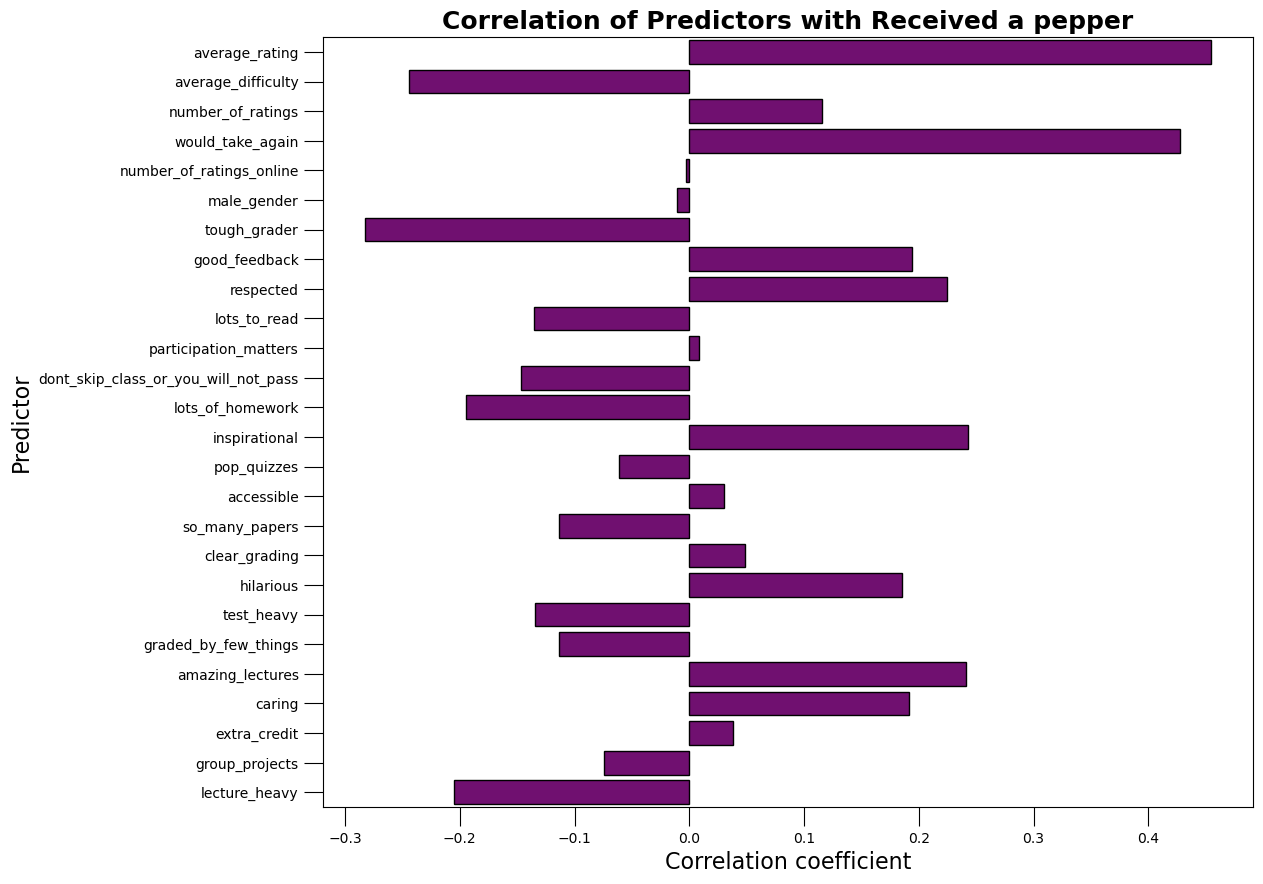

In [86]:
# plot correlation of y and x 
plt.figure(figsize= (12, 10))

# plot itself 
sns.barplot(corr_yx_10, 
            orient= 'h', 
            color = 'purple', 
            edgecolor = 'black')

# title 
plt.title("Correlation of Predictors with Received a pepper", 
          fontsize = 18, 
          fontweight = "bold")

# xlabel
plt.xlabel("Correlation coefficient", 
           fontsize = 16)
# ylabel 
plt.ylabel("Predictor", 
           fontsize = 16)
# ticks 
plt.tick_params(size = 14)

The correlation analysis provides a clear first look at which factors are associated with receiving a pepper. The strongest positive relationships are driven by overall student sentiment. Average rating shows the highest correlation at about 0.45, followed closely by would take again at about 0.43. This is expected. Peppers are primarily awarded to professors students genuinely like.

Teaching quality tags also matter. Inspirational, amazing lectures, respected, good feedback, caring, and hilarious all show moderate positive correlations in the 0.18-0.25 range. These variables capture engagement, clarity, and emotional connection, which aligns well with the informal nature of the pepper signal.

Course popularity plays a smaller role. Number of ratings is positively correlated at around 0.11, suggesting that more visible professors are slightly more likely to receive a pepper, but exposure alone is not a dominant factor.

On the negative side, difficulty and workload clearly work against receiving a pepper. Tough grader shows the strongest negative correlation at about -0.28. Average difficulty, lecture heavy, lots of homework, lots to read, and test heavy all fall between roughly -0.13 and -0.24. This indicates that stricter and heavier courses reduce the likelihood of a pepper, even if teaching quality is strong.

Administrative or structural factors have little impact. Male gender, number of online ratings, participation matters, accessible, and extra credit all sit close to zero, suggesting minimal direct association with receiving a pepper.

In [87]:
# correlation matrix among tags
corr_xx = x_train_q10.corr()

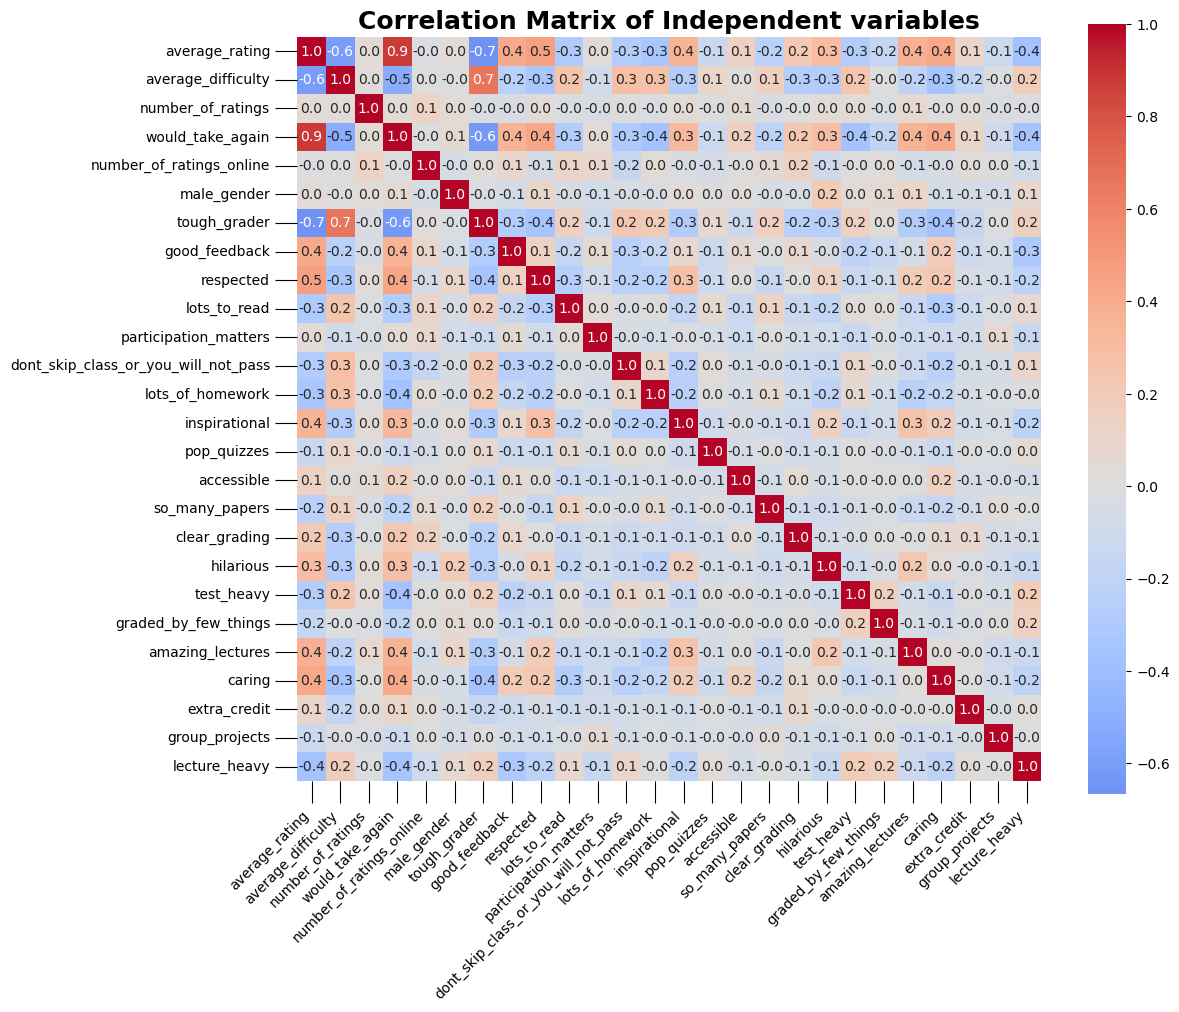

In [88]:
# plot correlation between predictors 
plt.figure(figsize= (12, 10))

# plot itself
sns.heatmap(
    corr_xx,
    cmap="coolwarm",
    center=0,
    square=True,
    cbar=True,
    annot=True,
    fmt=".1f"
)

# title 
plt.title("Correlation Matrix of Independent variables", 
          fontweight = 'bold', 
          fontsize = 18)

# tickts 
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tick_params(size = 16)

plt.show()

The correlation matrix reveals clear multicollinearity among several key predictors. In particular, average rating and would take again are extremely strongly correlated, with a correlation close to 0.9. Both variables also show strong correlations with multiple teaching quality tags such as good feedback, respected, caring, and amazing lectures. This indicates that these variables capture overlapping aspects of overall student satisfaction rather than independent signals.

Difficulty-related variables form a second correlated block. Tough grader, average difficulty, lecture heavy, lots of homework, and test heavy are moderately to strongly correlated with each other, reflecting a shared underlying dimension of course rigor.

While most other pairwise correlations remain below common concern thresholds, the presence of these tightly connected clusters implies that a plain logistic regression model would suffer from coefficient instability and inflated variance. This does not necessarily harm prediction, but it does undermine interpretability and reliability of individual coefficients.

To address this issue, regularization is required. Ridge logistic regression is particularly appropriate in this setting, as it stabilizes coefficients under multicollinearity without arbitrarily discarding correlated predictors. Lasso will also be considered for sparsity and feature selection, but ridge provides a more principled baseline when predictors are strongly correlated rather than redundant.

Before fitting any classification model, we also need to explicitly address class imbalance. Receiving a pepper is a relatively rare outcome, so accuracy alone would be misleading. Model evaluation will therefore rely on metrics such as ROC-AUC, and we will consider class weighting or resampling strategies to ensure the minority class is properly learned.

In [89]:
# check distributions of the data 
print(f'Number of rows for train data:{y_train_q10.shape[0]}\n')
print(f'Number of rows for test data:{y_test_q10.shape[0]}\n')

Number of rows for train data:14737

Number of rows for test data:3685



In [90]:
# check classes in train data
y_train_q10.value_counts()

received_a_pepper
0.0    8504
1.0    6233
Name: count, dtype: int64

Both classes are reasonably well represented. The training set contains 8,504 observations without a pepper and 6,233 with a pepper, which corresponds to roughly a 58-42 split. This is not a severe imbalance, so extreme remedies such as aggressive resampling are unnecessary. However, the classes are still not perfectly balanced, so evaluation will rely on threshold-independent metrics such as ROC-AUC rather than accuracy.

Given this setup, we proceed without class resampling and instead focus on model specification and preprocessing choices. As a first step, we tune KNN imputation within a regular logistic regression framework. This allows us to assess whether a more sophisticated imputation strategy meaningfully improves predictive performance compared to simpler alternatives such as mean or median imputation. Once the best imputation approach is identified, we will carry it forward to the regularized logistic models.

### Logisic Regression

#### KNN Imputation 

In [97]:
# fixed cross-validation (classification needs stratification)
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=n_number
)
# pipeline for tuning 
knn_pipe_q10 = Pipeline([
    # imputer 
    ("imputer", KNNImputer()),

    # model 
    ("model", LogisticRegression(
        max_iter=10000,
        solver="lbfgs"
    ))
])

# define objective function for optuna
def objective(trial):
    # parameters to tune (numeric imputer only)
    params = {
        "imputer__n_neighbors": trial.suggest_int("imputer__n_neighbors", 2, 25),
        "imputer__weights": trial.suggest_categorical("imputer__weights", ["uniform", "distance"]),
        "imputer__add_indicator": False
    }

    # clone our model and set parameters
    pipe = clone(knn_pipe_q10)
    pipe.set_params(**params)

    # cross-validation score with tuned parameters (classification metric)
    scores = cross_val_score(
        pipe,
        x_train_q10,
        y_train_q10,
        cv=cv,
        scoring="roc_auc",
        n_jobs=-1
    )

    # maximize ROC-AUC
    return scores.mean()

# start the study for knn imputer tuning
study_knn_q10 = start_study_optuna(
    objective=objective,
    n_trials=25,
    sampler_seed=n_number,
    direction="maximize"
)

# set the best parameters to the pipeline
knn_pipe_q10.set_params(**study_knn_q10.best_params)

# assess 
score_classifier(
    knn_pipe_q10,
    x_train_q10,
    x_test_q10,
    y_train_q10,
    y_test_q10
)

[I 2026-01-19 19:18:43,003] A new study created in memory with name: no-name-aab61182-6e68-4723-b361-66248855e40c
[I 2026-01-19 19:18:52,877] Trial 0 finished with value: 0.7907050133440378 and parameters: {'imputer__n_neighbors': 8, 'imputer__weights': 'distance'}. Best is trial 0 with value: 0.7907050133440378.
[I 2026-01-19 19:19:00,484] Trial 1 finished with value: 0.7906667168464394 and parameters: {'imputer__n_neighbors': 6, 'imputer__weights': 'distance'}. Best is trial 0 with value: 0.7907050133440378.
[I 2026-01-19 19:19:07,071] Trial 2 finished with value: 0.7905358512424672 and parameters: {'imputer__n_neighbors': 4, 'imputer__weights': 'distance'}. Best is trial 0 with value: 0.7907050133440378.
[I 2026-01-19 19:19:13,307] Trial 3 finished with value: 0.7906170361356528 and parameters: {'imputer__n_neighbors': 17, 'imputer__weights': 'distance'}. Best is trial 0 with value: 0.7907050133440378.
[I 2026-01-19 19:19:18,373] Trial 4 finished with value: 0.7907282443922973 and p

Best Params: {'imputer__n_neighbors': 23, 'imputer__weights': 'uniform'}


{'Training ROC-AUC': 0.7922666491992746,
 'Testing ROC-AUC': 0.7929209599661109,
 'Training Accuracy': 0.7168351767659632,
 'Testing Accuracy': 0.7177747625508819,
 'Training Precision': 0.6591470951792336,
 'Testing Precision': 0.662227602905569,
 'Training Recall': 0.6844216268249639,
 'Testing Recall': 0.6941624365482234,
 'Testing Specificity': np.float64(0.7354196301564723),
 'Training F1': 0.6715466351829988,
 'Testing F1': 0.677819083023544,
 'Confusion Matrix (test)': [[np.int64(1551), np.int64(558)],
  [np.int64(482), np.int64(1094)]]}

The tuned logistic regression with KNN imputation performs well and generalizes cleanly. ROC-AUC is about 0.793 on both training and test data, indicating strong discriminative ability with no signs of overfitting. The near-identical train and test AUC confirms stable generalization. The use of Stratified K-Fold cross-validation ensures that class proportions are preserved across folds, so these results are not driven by sampling artifacts.

Overall accuracy is roughly 0.72, which is reasonable given the subjective and noisy nature of pepper assignments. Test precision is about 0.66, meaning roughly two thirds of professors predicted to receive a pepper actually do. Test recall is about 0.69, so the model identifies close to 70 percent of true pepper cases. Specificity is about 0.74, indicating slightly better performance at identifying non-pepper cases. The F1 score of approximately 0.68 reflects a balanced tradeoff between precision and recall.

The confusion matrix confirms this balance. Errors are distributed across both classes, and there is no evidence that the model systematically favors one class over the other. Class imbalance is therefore not a limiting factor in this setting, and no reweighting or resampling is required at this stage.

With this strong and stable baseline in place, the next step is to compare different imputation strategies. We will evaluate whether simpler imputers, such as mean or median imputation, perform comparably to the tuned KNN imputer, or whether the added complexity of KNN imputation provides a measurable advantage in classification performance.

In [100]:
# fixed cross-validation (classification needs stratification)
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=n_number
)

# pipelines for comparison
pipelines_q10 = {
    "KNNImputer (tuned)": Pipeline([
        # imputer
        ("imputer", KNNImputer(
            n_neighbors=23,
            weights="uniform",
            add_indicator=False
        )),

        # scaler
        ("scaler", StandardScaler()),

        # model
        ("model", LogisticRegression(
            max_iter=10000,
            solver="lbfgs",
            random_state=n_number
        ))
    ]),

    "SimpleImputer (mean)": Pipeline([
        ("imputer", SimpleImputer(
            strategy="mean",
            add_indicator=False
        )),
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(
            max_iter=10000,
            solver="lbfgs",
            random_state=n_number
        ))
    ]),

    "SimpleImputer (median)": Pipeline([
        ("imputer", SimpleImputer(
            strategy="median",
            add_indicator=False
        )),
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(
            max_iter=10000,
            solver="lbfgs",
            random_state=n_number
        ))
    ]),
}

# compare the pipelines
rows = []
for name, pipe in pipelines_q10.items():
    results = cross_validate(
        pipe,
        x_train_q10,
        y_train_q10,
        cv=cv,
        scoring={
            "roc_auc": "roc_auc",
            "accuracy": "accuracy",
            "precision": "precision",
            "recall": "recall",
            "f1": "f1"
        },
        return_train_score=False,
        n_jobs=-1
    )

    rows.append({
        "model": name,
        "ROC_AUC_mean": results["test_roc_auc"].mean(),
        "Accuracy_mean": results["test_accuracy"].mean(),
        "Precision_mean": results["test_precision"].mean(),
        "Recall_mean": results["test_recall"].mean(),
        "F1_mean": results["test_f1"].mean()
    })

# create a dataframe for comparison
compare_imputers_df_q10 = (
    pd.DataFrame(rows)
      .sort_values("ROC_AUC_mean", ascending=False)
      .reset_index(drop=True)
)

# check the results
compare_imputers_df_q10

,model,ROC_AUC_mean,Accuracy_mean,Precision_mean,Recall_mean,F1_mean
0,SimpleImputer (mean),0.791396,0.718259,0.663622,0.677520,0.670429
1,SimpleImputer (median),0.791193,0.716766,0.661483,0.677039,0.669092
2,KNNImputer (tuned),0.790725,0.716902,0.660016,0.682333,0.670917


All three imputation strategies yield nearly identical classification performance. ROC-AUC remains stable at approximately 0.79 across specifications, and accuracy and F1 scores differ only at the third decimal place. This indicates that model performance is insensitive to the choice of imputation method in this setting. Given the absence of meaningful gains from KNN imputation and its higher computational cost, we proceed with mean imputation for the final classification model.

Next, we tune and compare regularized logistic regression models. Specifically, we evaluate standard logistic regression, Ridge logistic regression, and Lasso logistic regression under the same stratified cross-validation setup. Model comparison is based on ROC-AUC to assess overall discriminative ability independently of any fixed probability threshold. Precision, recall, and related metrics are examined only after the final model is selected, during threshold analysis.

#### Logistic / Lasso / Ridge / ElasticNet Regression

In [106]:
# cv 
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=n_number
)

# pipelines for logistic models
pipelines_q10_logistic = {
    # each separate pipeline
    "LogisticRegression": Pipeline([
        # imputer 
        ("imputer", SimpleImputer(strategy="mean")),
        # scaler 
        ("scaler", StandardScaler()),
        # model itself 
        ("model", LogisticRegression(
            max_iter=10000,
            solver="lbfgs",
            random_state=n_number
        ))
    ]),

    "Ridge Logistic (L2)": Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("model", LogisticRegressionCV(
            use_legacy_attributes=False,
            # use l1_ratios instead of penalty for sklearn >= 1.8
            l1_ratios=(0.0,),
            Cs=np.logspace(-4, 4, 20),
            solver="lbfgs",
            cv=cv,
            scoring="roc_auc",
            max_iter=10000,
            random_state=n_number
        ))
    ]),

    "Lasso Logistic (L1)": Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("model", LogisticRegressionCV(
            use_legacy_attributes=False,
            l1_ratios=(1.0,),
            Cs=np.logspace(-4, 4, 20),
            solver="saga",
            cv=cv,
            scoring="roc_auc",
            max_iter=10000,
            random_state=n_number
        ))
    ]),

    "ElasticNet Logistic": Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("model", LogisticRegressionCV(
            use_legacy_attributes=False, 
            l1_ratios=[0.1, 0.5, 0.9],
            Cs=np.logspace(-4, 4, 20),
            solver="saga",
            cv=cv,
            scoring="roc_auc",
            max_iter=10000,
            random_state=n_number
        ))
    ])
}


# compare models using ROC-AUC
rows = []
for name, pipe in pipelines_q10_logistic.items():
    results = cross_validate(
        pipe,
        x_train_q10,
        y_train_q10,
        cv=cv,
        scoring={
            "roc_auc": "roc_auc",
            "accuracy": "accuracy",
            "precision": "precision",
            "recall": "recall",
            "f1": "f1"
        },
        n_jobs=-1,
        return_train_score=False
    )

    rows.append({
        "model": name,
        "ROC_AUC_mean": results["test_roc_auc"].mean(),
        "Accuracy_mean": results["test_accuracy"].mean(),
        "Precision_mean": results["test_precision"].mean(),
        "Recall_mean": results["test_recall"].mean(),
        "F1_mean": results["test_f1"].mean()
    })

# save to the dataset 
compare_models_q10_logistic_df = (
    pd.DataFrame(rows)
      .sort_values("ROC_AUC_mean", ascending=False)
      .reset_index(drop=True)
)

# check 
compare_models_q10_logistic_df

,model,ROC_AUC_mean,Accuracy_mean,Precision_mean,Recall_mean,F1_mean
0,LogisticRegression,0.791396,0.718259,0.663622,0.677520,0.670429
1,Lasso Logistic (L1),0.791375,0.718191,0.663510,0.677520,0.670373
2,Ridge Logistic (L2),0.791360,0.717784,0.663164,0.676718,0.669796
3,ElasticNet Logistic,0.791325,0.717852,0.663154,0.677039,0.669949


In [107]:
for name, pipe in pipelines_q10_logistic.items():
    print(f"\nModel: {name}")
    print(score_classifier(
        pipe,
        x_train_q10,
        x_test_q10,
        y_train_q10,
        y_test_q10,
        threshold=0.5
    ))


Model: LogisticRegression
{'Training ROC-AUC': 0.7929667095251671, 'Testing ROC-AUC': 0.7934841734601286, 'Training Accuracy': 0.7177173101716767, 'Testing Accuracy': 0.7137042062415196, 'Training Precision': 0.6627925239516256, 'Testing Precision': 0.6603076923076923, 'Training Recall': 0.6770415530242259, 'Testing Recall': 0.6808375634517766, 'Testing Specificity': np.float64(0.7382645803698435), 'Training F1': 0.6698412698412698, 'Testing F1': 0.6704154951577632, 'Confusion Matrix (test)': [[np.int64(1557), np.int64(552)], [np.int64(503), np.int64(1073)]]}

Model: Ridge Logistic (L2)
{'Training ROC-AUC': 0.7929839530408883, 'Testing ROC-AUC': 0.7935217811987783, 'Training Accuracy': 0.717853023003325, 'Testing Accuracy': 0.7131614654002714, 'Training Precision': 0.6629495837914245, 'Testing Precision': 0.6594960049170252, 'Training Recall': 0.6772019894111985, 'Testing Recall': 0.6808375634517766, 'Testing Specificity': np.float64(0.7373162636320532), 'Training F1': 0.67, 'Testing 

All four logistic models achieve virtually identical performance. ROC-AUC is stable at about 0.79 across specifications, and accuracy, precision, recall, and F1 differ only at the fourth decimal place. This confirms that predictive performance is largely insensitive to the choice of regularization in this setting.

Given this equivalence, model selection should be guided by statistical considerations rather than performance. Plain logistic regression offers no protection against multicollinearity. Ridge stabilizes coefficients but retains all predictors. Lasso enforces sparsity but can behave unstably when predictors are correlated.

Elastic Net provides the most balanced solution. It combines L1 shrinkage, which encourages sparsity, with L2 regularization, which stabilizes coefficients in the presence of multicollinearity. Since several predictors such as average rating and would take again are strongly correlated, Elastic Net is a convenient and defensible choice.

We therefore select Elastic Net logistic regression as the final classification model. The choice reflects a preference for stability and interpretability without sacrificing predictive performance.

#### ElasticNet Regression

In [109]:
# cv (stratified for classification)
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=n_number
)

# pipeline for ElasticNet logistic regression
elastic_pipe_q10 = Pipeline([
    # imputer
    ("imputer", SimpleImputer(strategy="mean")),
    # scaler
    ("scaler", StandardScaler()),
    # model
    ("model", LogisticRegressionCV(
        use_legacy_attributes = False,
        l1_ratios=[0.1, 0.5, 0.9],
        Cs=np.logspace(-4, 4, 20),
        solver="saga",
        cv=cv,
        scoring="roc_auc",
        max_iter=10000,
        random_state=n_number,
        n_jobs=-1
    ))
])

# fit on full training data
elastic_pipe_q10.fit(x_train_q10, y_train_q10)

# extract weights from the fitted model
elastic_model = elastic_pipe_q10.named_steps["model"]

# feature names after preprocessing
feature_names = elastic_pipe_q10.named_steps["imputer"].get_feature_names_out(
    x_train_q10.columns
)

# coefficients (binary classification -> 1D)
coef = elastic_model.coef_.ravel()

# build dataframe of weights
weights_df_q10_elastic = pd.DataFrame({
    "feature": feature_names,
    "weight": coef
})

# sort by absolute weight
weights_df_q10_elastic["abs_weight"] = weights_df_q10_elastic["weight"].abs()
weights_df_q10_elastic = (
    weights_df_q10_elastic
      .sort_values("abs_weight", ascending=False)
      .drop(columns="abs_weight")
      .reset_index(drop=True)
)

# check
weights_df_q10_elastic

,feature,weight
0,average_rating,1.149160
1,number_of_ratings,0.299738
2,tough_grader,0.268805
3,inspirational,0.266010
4,hilarious,0.259662
5,good_feedback,0.246310
6,amazing_lectures,0.241981
7,lots_to_read,0.198060
8,caring,0.182064
9,extra_credit,0.179040


<Figure size 1200x1000 with 0 Axes>

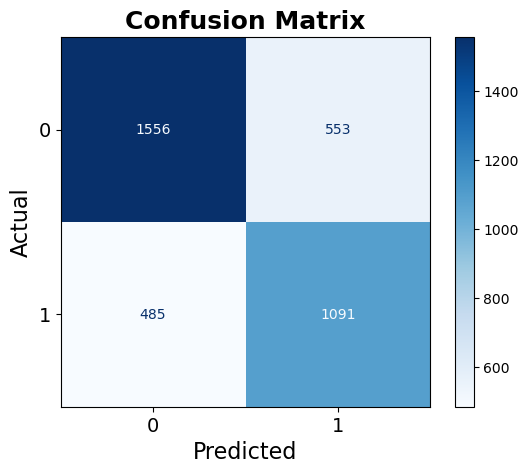

In [ ]:
# confusion matrix 
cm = confusion_matrix(y_test, y_test_pred)

# figure size 
plt.figure(figsize=(12, 10))

# confusion matrix parameters 
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")

# title 
plt.title("Confusion Matrix", fontsize=18, fontweight="bold")

# xlabel
plt.xlabel("Predicted", fontsize=16)
#ylabel
plt.ylabel("Actual", fontsize=16)

# ticks
plt.tick_params(labelsize=14)

plt.show()

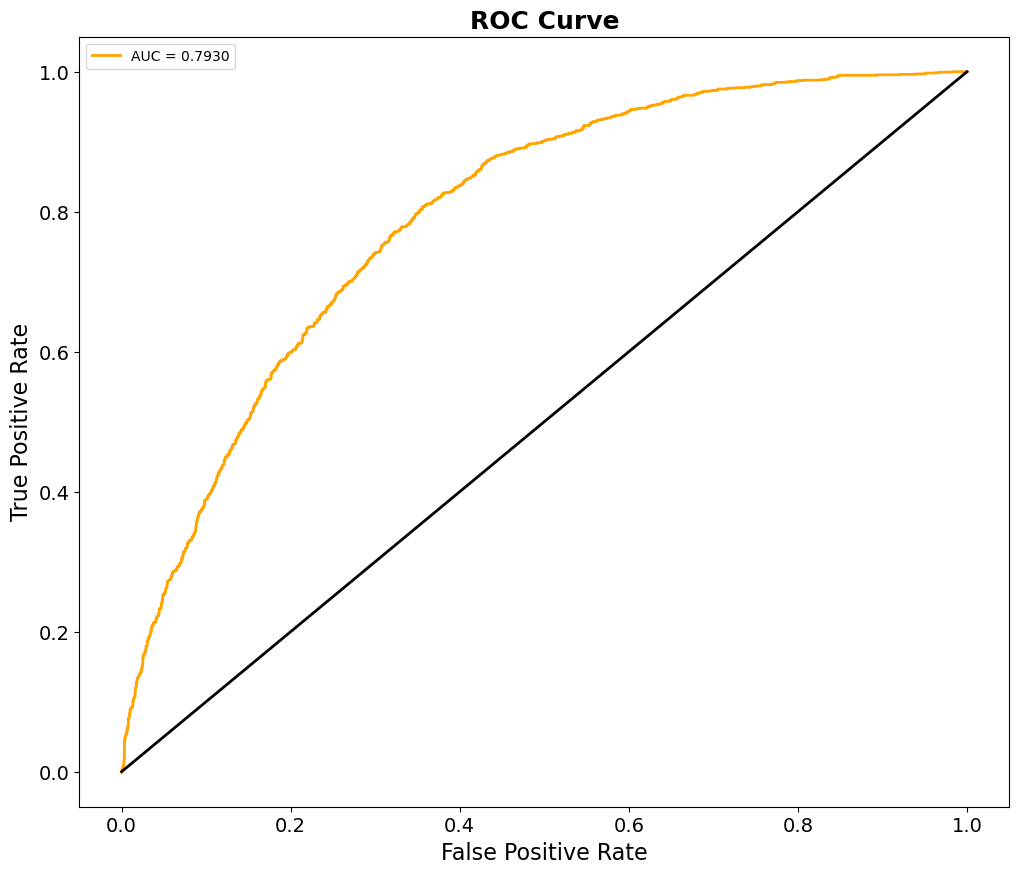

In [289]:
# extract false positive and true positive rates
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
# compute roc_auc
roc_auc = auc(fpr, tpr)

# plot
plt.figure(figsize=(12, 10))

# plot itself
plt.plot(fpr, tpr, color="orange", linewidth=2, label=f"AUC = {roc_auc:.4f}")
# mean line
plt.plot([0, 1], [0, 1], color="black", linewidth=2)

# title 
plt.title("ROC Curve", fontsize=18, fontweight="bold")

# xlabel
plt.xlabel("False Positive Rate", fontsize=16)

# ylabel
plt.ylabel("True Positive Rate", fontsize=16)

# tickparams
plt.tick_params(labelsize=14)

# legend
plt.legend(frameon = True, 
           loc = 'upper left')

# show the plot
plt.show()

The confusion matrix shows that the model correctly identifies 1,091 professors who received a pepper and 1,556 who did not. There are 485 false negatives, professors who received a pepper but were missed, and 553 false positives, professors incorrectly flagged as having received a pepper. Given our stated objective that false negatives are more costly than false positives, this error profile is acceptable. The model captures a large share of true pepper recipients while tolerating some overprediction.

Next, we fine-tune the decision threshold to further reduce false negatives by prioritizing recall, and examine how recall and precision trade off across different thresholds before selecting the final operating point. From our perspective, false negatives are more costly than false positives. A false negative corresponds to a professor who actually received a pepper but is not identified by the model, meaning we fail to recognize a genuinely high-quality instructor. In contrast, a false positive only results in incorrectly flagging a professor who did not receive a pepper, which is less harmful in this context. For this reason, we prioritize maximizing recall for the positive class. By adjusting the decision threshold, we aim to capture as many true pepper recipients as possible, even if this increases the number of false positives, and then select an operating point that maintains reasonable precision while minimizing missed positive cases.

In [284]:
# predicted probabilities on train set
y_train_prob = pipeline_q10_ridge_cv.predict_proba(x_train)[:, 1]

# thresholds
thresholds = np.linspace(0.01, 0.99, 50)
rows = []

# loop over many thresholds
for t in thresholds:
    y_pred_t = (y_train_prob >= t).astype(int)
    rows.append({
        "threshold": t,
        "recall": recall_score(y_train, y_pred_t),
        "precision": precision_score(y_train, y_pred_t),
        "f1": f1_score(y_train, y_pred_t)
    })

# check 
threshold_df_train = pd.DataFrame(rows)
threshold_df_train


,threshold,recall,precision,f1
0,0.01,1.000000,0.423783,0.595292
1,0.03,0.999679,0.437662,0.608793
2,0.05,0.997433,0.452837,0.622883
3,0.07,0.992459,0.465463,0.633714
4,0.09,0.985721,0.477093,0.642980
5,0.11,0.978181,0.487799,0.650972
6,0.13,0.970319,0.498475,0.658608
7,0.15,0.962458,0.508821,0.665705
8,0.17,0.954115,0.518709,0.672053
9,0.19,0.944168,0.527803,0.677098


Choosing a threshold of 0.35 reflects a deliberate preference for high recall. At this operating point, the model achieves a recall of ~0.85, meaning it correctly identifies about 85 percent of professors who received a pepper. Precision is ~0.60, indicating that a majority of professors flagged as pepper recipients are indeed true positives. The resulting F1 score of ~0.70 shows a strong overall balance between recall and precision while still emphasizing sensitivity to the positive class. This threshold substantially reduces false negatives compared to higher thresholds and aligns with our objective of minimizing missed pepper recipients, even at the cost of accepting additional false positives.

In [285]:
# apply chosen threshold
threshold = 0.35
y_test_prob = pipeline_q10_ridge_cv.predict_proba(x_test)[:, 1]
y_test_pred = (y_test_prob >= threshold).astype(int)

In [286]:
# final results 
final_results = {
    "Accuracy": accuracy_score(y_test, y_test_pred),
    "Recall": recall_score(y_test, y_test_pred),
    "Precision": precision_score(y_test, y_test_pred),
    "F1": f1_score(y_test, y_test_pred),
    "AUROC": roc_auc_score(y_test, y_test_prob)
}

# check 
final_results

{'Accuracy': 0.6985074626865672,
 'Recall': 0.8521573604060914,
 'Precision': 0.6046825754164791,
 'F1': 0.7074005794047933,
 'AUROC': 0.7929513470189398}

In [290]:
# classification summary
print(classification_report(y_test, y_test_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.8408    0.5837    0.6891      2109
         1.0     0.6047    0.8522    0.7074      1576

    accuracy                         0.6985      3685
   macro avg     0.7228    0.7179    0.6982      3685
weighted avg     0.7398    0.6985    0.6969      3685



In [292]:
# check the results
# classification report as dict
report_dict = classification_report(
    y_test,
    y_test_pred,
    digits=4,
    output_dict=True
)

# dataframe (rows = classes/averages, cols = metrics)
results_q10_df = pd.DataFrame(report_dict).T

# style with borders
styled1 = results_q10_df.style.set_properties(**{
    "background-color": "white",
    "color": "black",
    "border": "1px solid black"
}).format("{:.4f}")

styled1

,precision,recall,f1-score,support
0.0,0.8408,0.5837,0.6891,2109.0000
1.0,0.6047,0.8522,0.7074,1576.0000
accuracy,0.6985,0.6985,0.6985,0.6985
macro avg,0.7228,0.7179,0.6982,3685.0000
weighted avg,0.7398,0.6985,0.6969,3685.0000


<Figure size 1200x1000 with 0 Axes>

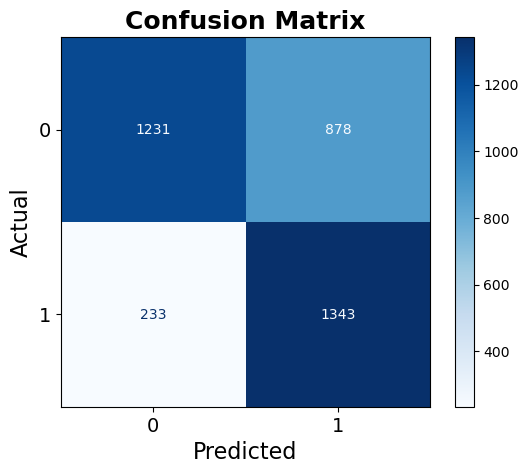

In [293]:
# confusion matrix 
cm = confusion_matrix(y_test, y_test_pred)

# figure size 
plt.figure(figsize=(12, 10))

# confusion matrix parameters 
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")

# title 
plt.title("Confusion Matrix", fontsize=18, fontweight="bold")

# xlabel
plt.xlabel("Predicted", fontsize=16)
#ylabel
plt.ylabel("Actual", fontsize=16)

# ticks
plt.tick_params(labelsize=14)

plt.show()

With the decision threshold set to 0.35, the model successfully shifts its behavior toward prioritizing recall for the positive class. The confusion matrix shows that 1,343 professors who received a pepper are correctly identified, while false negatives are reduced to 233, a substantial improvement compared to the default threshold. This aligns with our objective of minimizing missed pepper recipients. As expected, this comes at the cost of more false positives, with 878 non-pepper professors incorrectly flagged.

The classification report confirms this tradeoff. For the positive class, recall increases to 0.85, meaning the model now captures the vast majority of true pepper recipients, while precision remains moderate at 0.60. The resulting F1 score of 0.71 reflects a strong balance between sensitivity and precision under a recall-oriented operating point. Overall accuracy decreases slightly, which is expected when prioritizing recall, but the model remains effective for the intended goal. This final threshold represents a well-justified operating point given the higher cost of false negatives in this setting.